In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements, and eventually radial velocity measurements (in the next tutorial, :ref:`astrometric-rv`). For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [4]:
# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01"$ for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [6]:
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns

rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

# Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

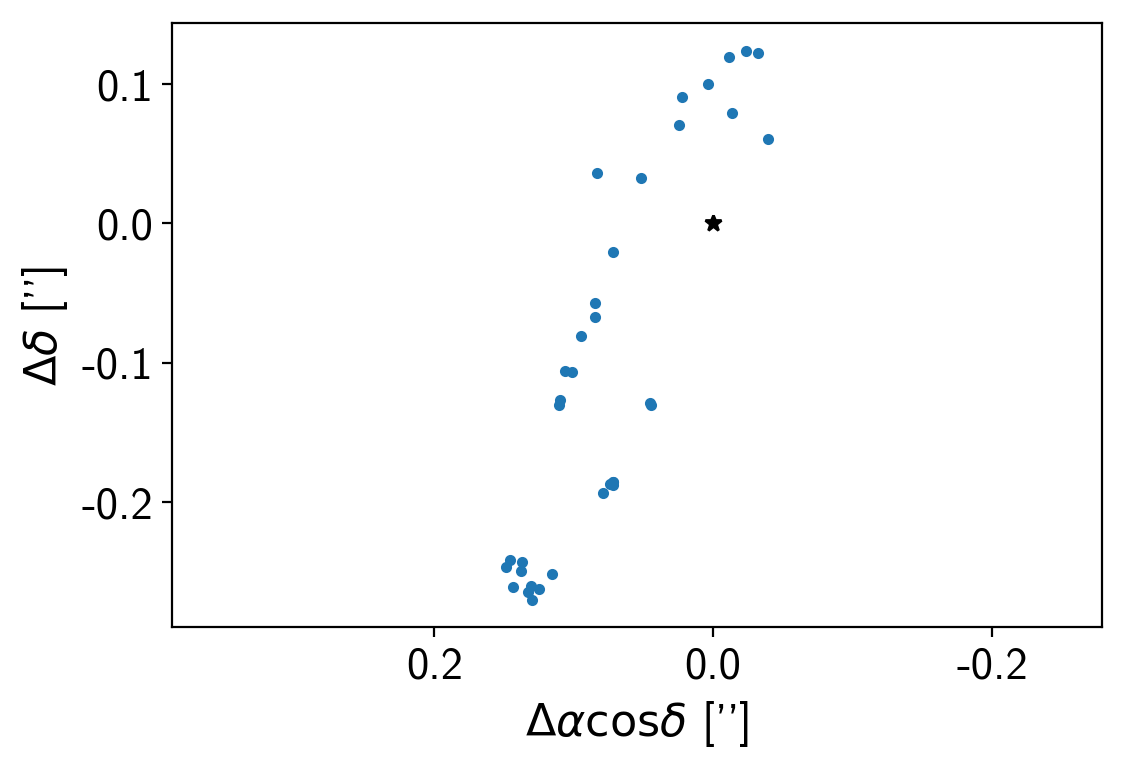

In [7]:
# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left

fig, ax = plt.subplots(nrows=1)

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

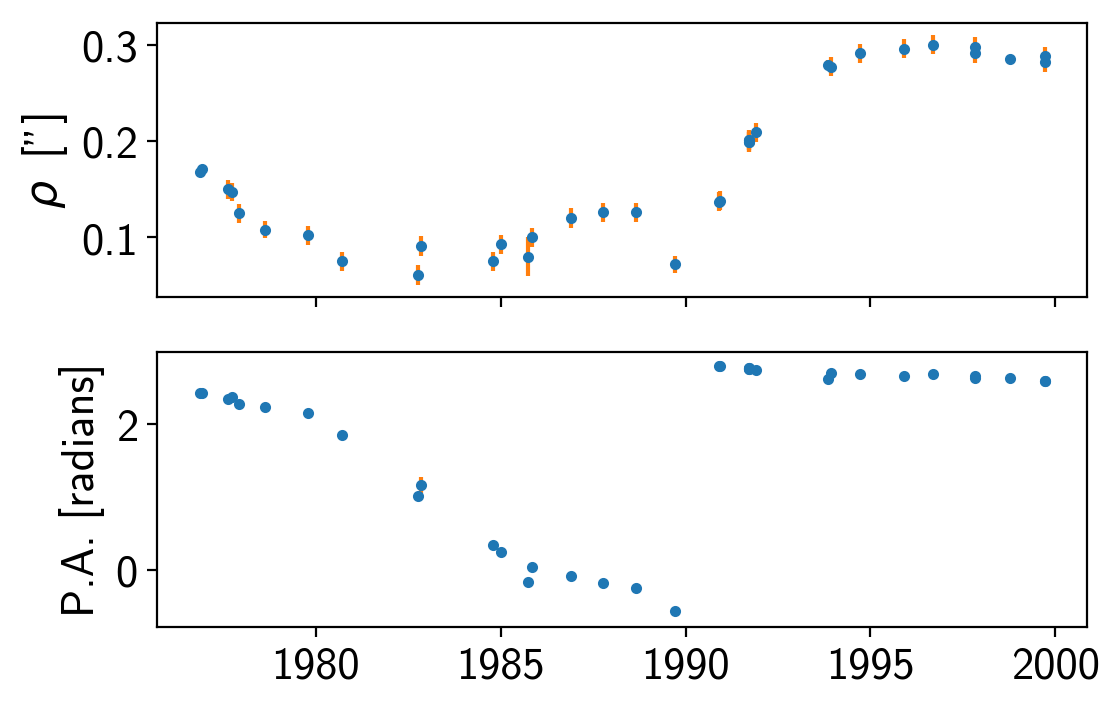

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(astro_yrs, rho_data, ".")
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, ".")
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

# Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

In [9]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

## A note on setting the scale of an orbit 

Orbits in *exoplanet* generally specify the semi-major axis in units of solar radii `R_sun`. For transits and RV orbits, you usually have enough external information (e..g., estimate of stellar mass from spectral type) to put a physical scale onto the orbit. For the most basic of astrometric orbits without parallax information, however, this information can be lacking and thus it makes sense to fit for the semi-major axis in units of `arcseconds`. But, `exoplanet` is modeling a real orbit (where semi-major axis is in units of `R_sun`), so we do need to at least provide a fake parallax to convert from arcseconds to `R_sun.`

In [10]:
# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

In [11]:
# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324 # arcsec
parallax = 1 # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

# n = 2 * np.pi / P
# t0 = (phi + w) / n

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega)

# make a theano function to get stuff from orbit 
times = tt.vector("times")

# pos = orbit.get_relative_position(times) # the X, Y, Z coordinates
# the position functions take an optional argument parallax to convert from physical units back to arcseconds
ang = orbit.get_relative_angles(times, parallax) # the rho, theta coordinates

# f_pos = theano.function([times], pos)
f_ang = theano.function([times], ang)

t = np.linspace(T0 - P, T0 + P, num=200) # days

# # anoms = f_anom(t)
# X, Y, Z = f_pos(t)
rho, theta = f_ang(t)

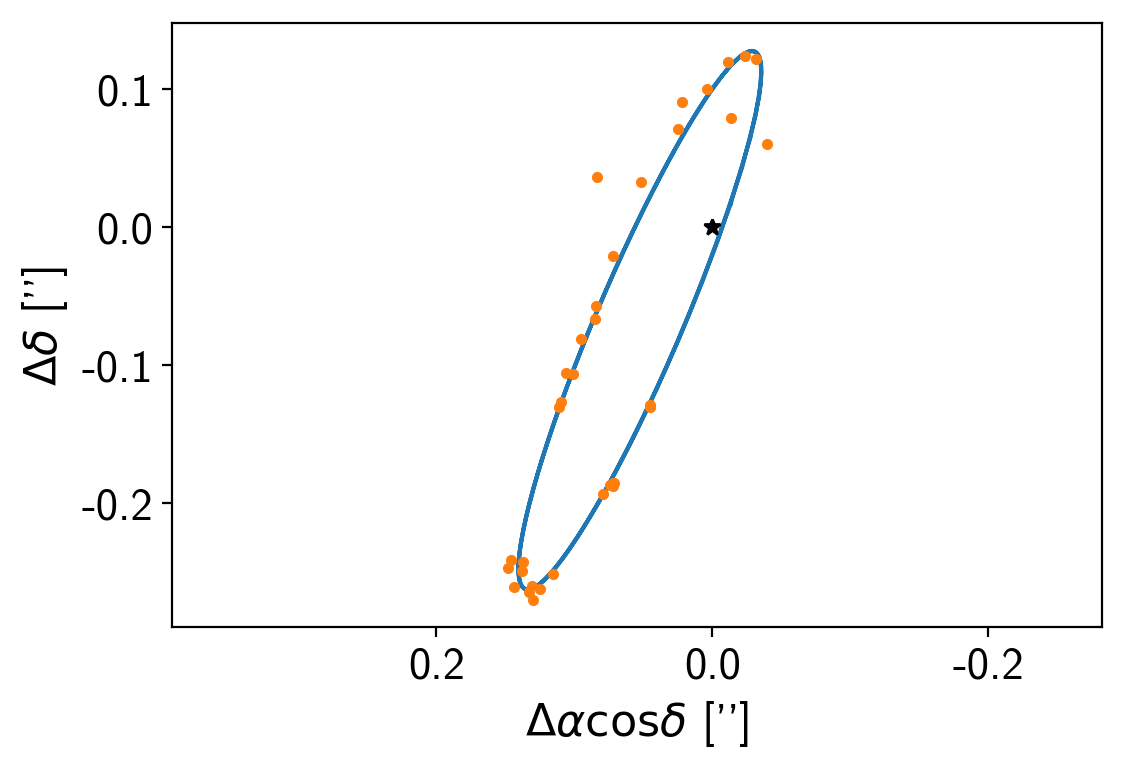

In [12]:
fig, ax = plt.subplots(nrows=1)

# plot the orbit 
xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

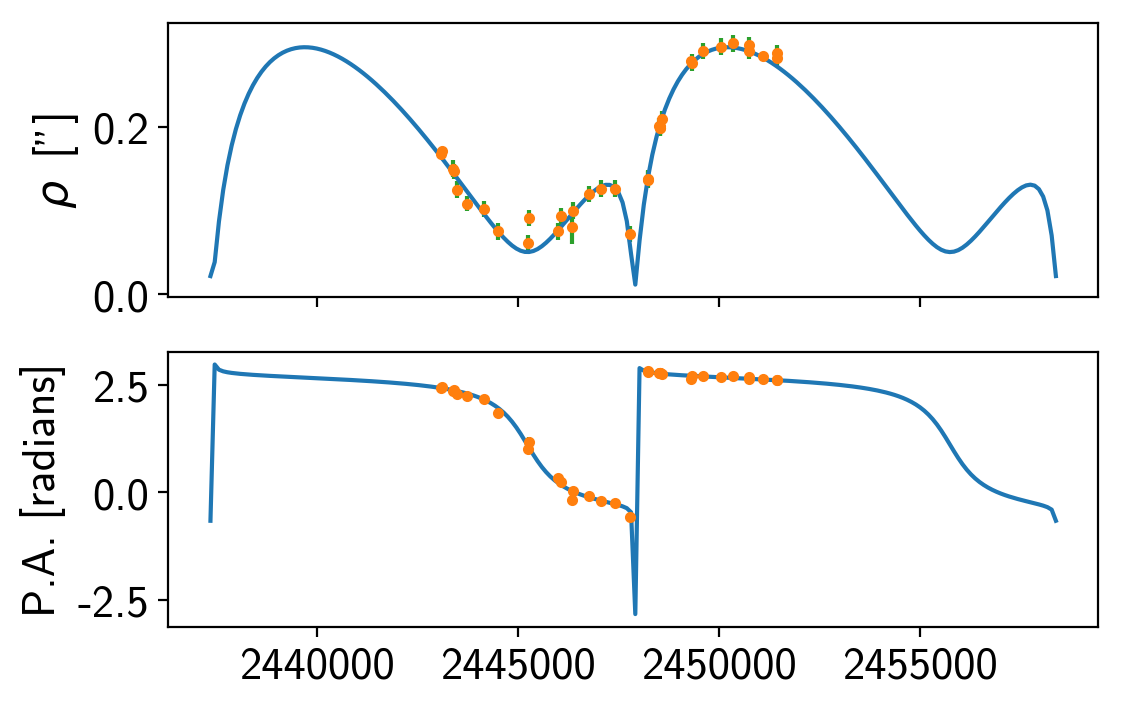

In [13]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(t, rho)
ax[0].plot(astro_jds, rho_data, ".")
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta)
ax[1].plot(astro_jds, theta_data, ".")
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

In [14]:
# Set up the model in PyMC3

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min(), astro_jds.max(), num=1000)

with pm.Model() as model:

    # A setup for a basic astrometric binary orbit
    # without an actual parallax measurement, we can model the orbit in units of arcseconds
    # by providing a fake_parallax and conversion constant
    parallax = 1 # arcsec 
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
    a = pm.Deterministic("a", a_ang * au_to_R_sun / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP))
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform prior on cos_incl (geometric)
    cos_incl = pm.Uniform("cosIncl", lower=-1, upper=1, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    orbit = xo.orbits.KeplerianOrbit(a=a, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega)
    
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
    
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # define the likelihood function, e.g., a Gaussian on both rho and theta
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    
    # n.b. that we want to be cognizant of the fact that theta wraps 
    # so the following is equivalent to 
    # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
    # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)
    
    # set up predicted orbits for later plotting 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    

In [15]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'logP_interval__', 'a_ang_interval__']


message: Optimization terminated successfully.
logp: 105.56753460346425 -> 195.2850833759547


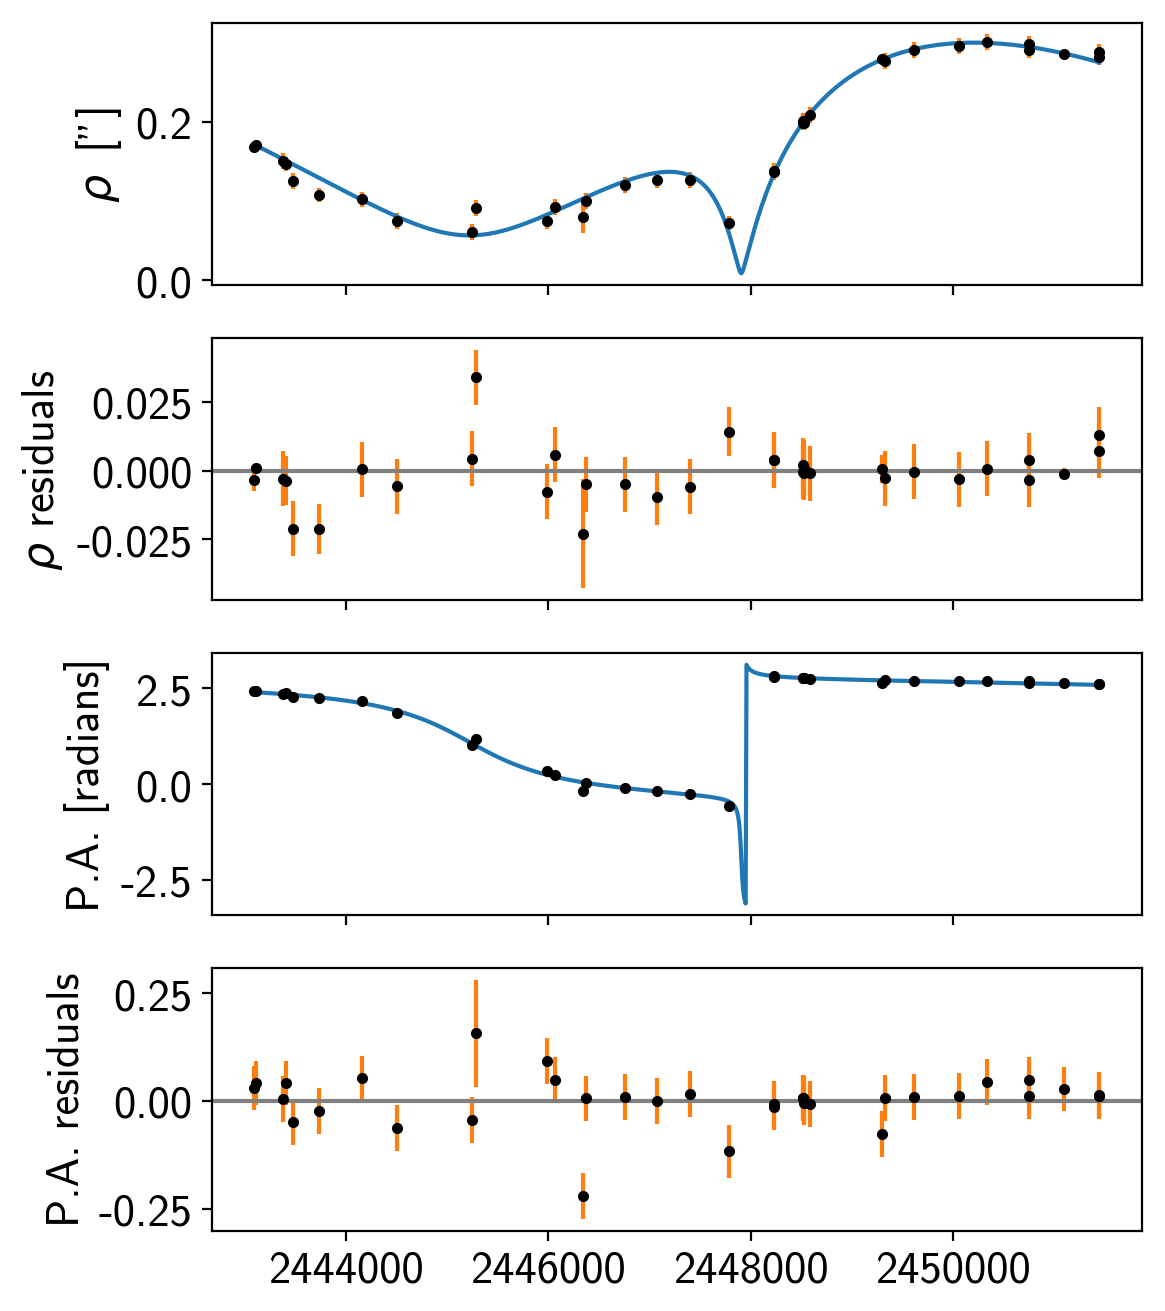

In [16]:
# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

with model:
    tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_sol["logRhoS"]))
    tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_sol["logThetaS"]))
        
    ax[0].plot(t_fine, xo.eval_in_model(rho_save, map_sol))
    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
    ax[1].axhline(0.0, color="0.5")
    ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), **pkw)
    ax[1].errorbar(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), yerr=tot_rho_err, **ekw)
    
        
    ax[2].plot(t_fine, xo.eval_in_model(theta_save, map_sol))
    ax[2].plot(astro_jds, theta_data, **pkw)
    ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
    ax[3].axhline(0.0, color="0.5")
    ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), **pkw)
    ax[3].errorbar(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), yerr=tot_theta_err, **ekw)   

In [17]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:06, 117.82draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:00<00:10, 73.60draws/s] 

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:15, 51.90draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:17, 43.95draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:19, 40.00draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:00<00:19, 39.47draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:00<00:20, 36.75draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:22, 34.66draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:01<00:22, 33.72draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:01<00:22, 34.00draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:01<00:22, 33.89draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:01<00:21, 34.60draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:01<00:21, 34.95draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:01<00:21, 34.02draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:01<00:21, 34.59draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:01<00:21, 33.95draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:02<00:21, 33.26draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:02<00:21, 33.87draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:02<00:21, 33.76draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:02<00:21, 34.10draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:02<00:21, 33.43draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:02<00:21, 32.87draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:02<00:21, 33.25draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:02<00:21, 33.13draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:03<00:22, 31.29draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:03<00:21, 32.18draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:03<00:19, 35.42draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:03<00:18, 36.19draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:03<00:19, 35.49draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:03<00:18, 35.80draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:03<00:18, 36.94draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:03<00:18, 35.91draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:04<00:17, 37.25draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:04<00:17, 37.88draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:04<00:17, 37.64draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:04<00:17, 36.55draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:04<00:18, 34.34draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:04<00:17, 37.50draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:04<00:17, 37.34draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:04<00:16, 37.89draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:04<00:16, 38.07draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:05<00:16, 37.06draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:05<00:16, 37.51draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:05<00:16, 38.18draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:05<00:16, 36.75draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:05<00:16, 36.12draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:05<00:16, 36.74draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:05<00:16, 36.92draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:05<00:16, 36.22draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:05<00:17, 33.45draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:06<00:17, 32.95draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:06<00:16, 35.38draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:06<00:17, 32.90draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:06<00:16, 35.07draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:06<00:15, 35.81draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:06<00:16, 34.13draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:06<00:16, 33.83draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:06<00:15, 35.12draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:07<00:16, 33.90draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:07<00:16, 33.77draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:07<00:15, 34.14draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:07<00:15, 35.54draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:07<00:15, 33.60draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:07<00:15, 34.04draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:07<00:15, 33.11draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:08<00:15, 32.84draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:08<00:14, 34.52draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:08<00:13, 36.61draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:08<00:14, 35.41draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:08<00:15, 33.26draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:08<00:15, 32.65draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:08<00:14, 33.12draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:08<00:14, 33.65draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:09<00:15, 31.98draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:09<00:14, 32.35draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:09<00:15, 31.72draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:09<00:13, 34.35draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:09<00:13, 35.02draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:09<00:13, 35.38draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:09<00:14, 32.84draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:09<00:13, 33.75draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:10<00:13, 33.48draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:10<00:13, 32.99draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:10<00:13, 31.79draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:10<00:13, 31.98draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:10<00:13, 32.49draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:10<00:12, 33.37draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:10<00:13, 32.58draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:10<00:12, 33.97draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:10<00:11, 35.55draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:11<00:11, 36.54draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:11<00:11, 36.96draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:11<00:10, 37.71draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:11<00:10, 37.43draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:11<00:11, 35.59draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:11<00:11, 34.33draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [00:11<00:10, 35.57draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:11<00:11, 32.58draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:12<00:11, 33.62draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:12<00:11, 33.17draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:12<00:10, 35.20draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:12<00:11, 32.75draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:12<00:10, 33.81draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:12<00:10, 33.16draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:12<00:11, 32.09draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [00:12<00:10, 32.37draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:13<00:10, 33.76draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:13<00:10, 32.84draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:13<00:09, 34.88draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:13<00:10, 31.78draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:13<00:10, 32.34draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:13<00:10, 32.75draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:13<00:09, 34.09draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:13<00:08, 36.84draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:14<00:08, 38.18draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:14<00:07, 41.99draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:14<00:08, 35.16draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:14<00:08, 35.74draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:14<00:08, 36.64draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:14<00:08, 35.94draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [00:14<00:08, 34.85draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:14<00:08, 33.08draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:15<00:07, 35.67draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:15<00:07, 37.73draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:15<00:07, 37.79draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:15<00:06, 39.77draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:15<00:07, 34.58draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:15<00:07, 34.05draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:15<00:07, 34.07draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:15<00:07, 34.30draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:16<00:06, 35.34draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:16<00:06, 35.94draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:16<00:06, 36.20draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:16<00:06, 36.20draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:16<00:06, 37.02draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [00:16<00:05, 37.52draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:16<00:05, 37.96draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:16<00:05, 38.67draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:16<00:05, 38.70draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:17<00:05, 34.22draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:17<00:05, 35.40draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:17<00:05, 35.61draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:17<00:05, 35.81draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:17<00:05, 34.83draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [00:17<00:05, 34.99draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:17<00:04, 35.80draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:17<00:05, 34.37draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:18<00:05, 32.99draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:18<00:04, 34.02draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:18<00:04, 33.75draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:18<00:04, 33.33draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [00:18<00:04, 32.42draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:18<00:04, 35.08draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:18<00:03, 37.12draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:18<00:03, 36.10draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:18<00:03, 34.25draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:19<00:03, 35.53draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:19<00:03, 35.83draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:19<00:03, 36.93draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:19<00:03, 37.34draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:19<00:02, 40.20draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:19<00:02, 42.55draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:19<00:02, 39.53draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:19<00:02, 37.93draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:20<00:02, 36.56draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:20<00:02, 30.94draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:20<00:02, 31.14draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:20<00:03, 25.07draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:20<00:03, 23.39draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:20<00:03, 21.97draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [00:20<00:03, 22.42draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:21<00:03, 22.37draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:21<00:03, 20.68draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [00:21<00:03, 17.99draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [00:21<00:03, 16.96draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:21<00:03, 16.04draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:21<00:03, 17.92draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:22<00:03, 17.38draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:22<00:03, 15.94draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:22<00:03, 14.64draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:22<00:03, 14.12draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:22<00:03, 13.81draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:22<00:03, 13.60draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:23<00:03, 13.48draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:23<00:02, 15.25draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:23<00:02, 14.71draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:23<00:02, 14.74draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:23<00:02, 15.59draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:23<00:01, 16.23draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:23<00:01, 16.63draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:23<00:01, 16.00draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:24<00:01, 18.13draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:24<00:01, 18.88draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:24<00:01, 17.95draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:24<00:01, 17.91draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:24<00:00, 17.28draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:24<00:00, 17.10draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:24<00:00, 16.52draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:25<00:00, 13.07draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:25<00:00, 11.59draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:25<00:00, 12.79draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:25<00:00, 11.18draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:26<00:00,  7.68draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:26<00:00, 30.38draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:02, 152.14draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:00<00:05, 70.44draws/s] 

Sampling 4 chains:   7%|▋         | 27/408 [00:00<00:06, 62.39draws/s]

Sampling 4 chains:   8%|▊         | 32/408 [00:00<00:06, 55.42draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:00<00:07, 47.76draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:07, 50.01draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:00<00:07, 50.07draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:01<00:07, 49.04draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:01<00:07, 48.05draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:01<00:08, 41.63draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:01<00:07, 45.79draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:01<00:07, 44.93draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:01<00:07, 45.64draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:01<00:06, 47.02draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:01<00:06, 47.80draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:01<00:06, 47.93draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:02<00:06, 49.72draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:02<00:05, 55.18draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:02<00:05, 53.24draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:02<00:05, 54.05draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:02<00:04, 56.92draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:02<00:04, 53.52draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:02<00:05, 51.66draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:02<00:04, 53.77draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:03<00:04, 53.56draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:03<00:04, 53.16draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:03<00:04, 53.15draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:03<00:04, 51.60draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:03<00:04, 51.97draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:03<00:04, 50.68draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:03<00:03, 55.90draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:03<00:04, 50.68draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:04<00:04, 46.02draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:04<00:04, 46.11draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:04<00:03, 51.58draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:04<00:03, 49.76draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:04<00:03, 48.89draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:04<00:03, 48.51draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:04<00:03, 47.64draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:04<00:03, 44.48draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:05<00:03, 44.92draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:05<00:03, 45.21draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:05<00:02, 47.13draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:05<00:02, 47.45draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:05<00:02, 47.13draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:05<00:02, 47.60draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:05<00:02, 45.26draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:05<00:02, 45.56draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:05<00:01, 54.14draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:06<00:01, 51.06draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:06<00:01, 45.99draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:06<00:01, 49.43draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:06<00:01, 52.00draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:06<00:01, 51.30draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:06<00:01, 43.95draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:06<00:01, 44.34draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:06<00:01, 47.74draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:07<00:00, 48.10draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:07<00:00, 45.12draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:07<00:00, 41.37draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:07<00:00, 39.08draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:07<00:00, 38.61draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:07<00:00, 27.81draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:08<00:00, 16.74draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:08<00:00, 14.86draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:09<00:00, 12.57draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:09<00:00, 14.79draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:09<00:00, 14.82draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:09<00:00, 13.44draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:09<00:00, 42.24draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:04, 168.27draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:09, 81.32draws/s] 

Sampling 4 chains:   3%|▎         | 28/808 [00:00<00:13, 57.99draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:00<00:15, 51.54draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:18, 40.53draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:00<00:19, 39.13draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:00<00:20, 36.86draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:01<00:17, 42.07draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:01<00:15, 47.06draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:14, 52.38draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:01<00:11, 63.80draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:01<00:08, 80.36draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:01<00:07, 92.85draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:01<00:05, 115.46draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:01<00:04, 138.38draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:01<00:03, 156.94draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:02<00:03, 181.84draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:02<00:02, 194.89draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:02<00:02, 216.35draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:02<00:02, 230.56draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:02<00:01, 238.45draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:02<00:01, 244.30draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:02<00:01, 213.68draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:02<00:01, 207.07draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:02<00:01, 204.77draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [00:03<00:01, 210.85draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:03<00:01, 224.96draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:03<00:01, 226.49draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:03<00:01, 215.41draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:03<00:01, 214.09draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:03<00:01, 223.87draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:03<00:00, 234.74draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:03<00:00, 253.47draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:03<00:00, 259.42draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:03<00:00, 267.85draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:04<00:00, 251.74draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:04<00:00, 238.38draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [00:04<00:00, 179.41draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:04<00:00, 128.28draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 166.07draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:00<00:15, 103.55draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:00<00:26, 59.40draws/s] 

Sampling 4 chains:   1%|▏         | 23/1608 [00:00<00:32, 48.16draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:00<00:34, 45.68draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:00<00:38, 40.72draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:00<00:41, 37.60draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:00<00:41, 38.12draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:00<00:43, 35.83draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:01<00:47, 32.84draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:01<00:46, 33.58draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:01<00:41, 37.20draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:01<00:36, 42.75draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:01<00:30, 49.98draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:01<00:24, 62.67draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:01<00:18, 80.84draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:01<00:14, 102.21draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:01<00:11, 123.59draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:02<00:10, 141.02draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:02<00:08, 162.83draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:02<00:09, 149.01draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:02<00:09, 150.09draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:02<00:08, 156.39draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:02<00:08, 161.32draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:02<00:08, 158.03draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [00:02<00:07, 176.49draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:03<00:06, 193.66draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:03<00:06, 194.18draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:03<00:05, 205.97draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:03<00:05, 218.83draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:03<00:05, 213.01draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [00:03<00:05, 220.08draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:03<00:05, 220.29draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [00:03<00:04, 222.60draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:03<00:04, 222.82draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [00:03<00:04, 215.99draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:04<00:04, 223.25draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [00:04<00:04, 227.55draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [00:04<00:04, 223.20draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [00:04<00:04, 228.96draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [00:04<00:03, 236.31draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [00:04<00:03, 231.08draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [00:04<00:03, 221.31draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:04<00:03, 222.53draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [00:04<00:03, 221.35draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [00:05<00:03, 210.97draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [00:05<00:03, 202.67draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [00:05<00:03, 211.47draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [00:05<00:03, 218.05draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [00:05<00:03, 223.11draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [00:05<00:02, 224.03draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [00:05<00:02, 228.42draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [00:05<00:02, 233.19draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [00:05<00:02, 227.98draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [00:06<00:02, 228.14draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [00:06<00:02, 231.14draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [00:06<00:02, 238.49draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [00:06<00:02, 227.97draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [00:06<00:02, 236.05draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [00:06<00:01, 237.20draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [00:06<00:01, 231.17draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [00:06<00:01, 225.76draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [00:06<00:01, 229.38draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [00:06<00:01, 237.31draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [00:07<00:01, 248.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [00:07<00:01, 253.04draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [00:07<00:01, 263.02draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [00:07<00:00, 242.82draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [00:07<00:00, 216.57draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [00:07<00:00, 210.09draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [00:07<00:00, 187.95draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [00:07<00:00, 191.19draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [00:08<00:00, 190.49draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [00:08<00:00, 195.83draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [00:08<00:00, 196.69draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [00:08<00:00, 182.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [00:08<00:00, 117.79draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [00:08<00:00, 81.64draws/s] 

Sampling 4 chains:  99%|█████████▉| 1590/1608 [00:09<00:00, 77.98draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [00:09<00:00, 80.58draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:09<00:00, 170.89draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:00<00:23, 135.07draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:00<00:40, 78.05draws/s] 

Sampling 4 chains:   1%|          | 26/3208 [00:00<01:08, 46.19draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:00<01:15, 42.27draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:00<01:23, 37.91draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:00<01:23, 37.75draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:00<01:29, 35.23draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:01<01:33, 33.80draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:01<01:28, 35.68draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:01<01:24, 37.32draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:01<01:12, 43.14draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:01<01:00, 51.41draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:01<00:48, 64.21draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:01<00:37, 82.84draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:01<00:30, 99.10draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:01<00:27, 111.46draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:02<00:23, 129.40draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:02<00:20, 144.39draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:02<00:18, 162.04draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:02<00:16, 176.78draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:02<00:15, 191.54draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:02<00:14, 199.09draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:02<00:14, 201.13draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:02<00:15, 189.67draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [00:02<00:14, 195.20draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:03<00:13, 204.85draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [00:03<00:15, 179.53draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [00:03<00:16, 171.15draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:03<00:16, 168.24draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [00:03<00:15, 183.14draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [00:03<00:13, 205.74draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [00:03<00:12, 218.69draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [00:03<00:12, 221.50draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:03<00:13, 197.12draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [00:04<00:12, 204.31draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [00:04<00:12, 212.17draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [00:04<00:11, 223.71draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [00:04<00:10, 238.39draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [00:04<00:09, 253.69draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [00:04<00:09, 260.29draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [00:04<00:09, 255.13draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [00:04<00:09, 264.45draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [00:04<00:09, 248.26draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [00:05<00:09, 255.24draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [00:05<00:08, 269.92draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [00:05<00:09, 254.69draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [00:05<00:09, 252.41draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [00:05<00:09, 244.28draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [00:05<00:08, 253.64draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [00:05<00:08, 248.80draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [00:05<00:08, 247.73draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [00:05<00:10, 212.70draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [00:06<00:09, 223.67draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [00:06<00:09, 230.13draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [00:06<00:09, 229.75draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [00:06<00:08, 238.33draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [00:06<00:08, 243.40draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [00:06<00:08, 247.35draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [00:06<00:08, 237.23draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [00:06<00:08, 241.20draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [00:06<00:07, 243.39draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [00:07<00:07, 242.43draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [00:07<00:07, 253.51draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [00:07<00:07, 258.04draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [00:07<00:06, 268.04draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [00:07<00:06, 277.07draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [00:07<00:05, 297.45draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [00:07<00:05, 287.67draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [00:07<00:05, 288.46draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [00:07<00:05, 301.81draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [00:07<00:05, 303.78draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [00:08<00:05, 296.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [00:08<00:04, 311.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [00:08<00:04, 310.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [00:08<00:04, 299.07draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [00:08<00:04, 301.48draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [00:08<00:04, 291.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [00:08<00:04, 307.23draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [00:08<00:04, 298.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [00:08<00:04, 290.34draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [00:09<00:04, 280.79draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [00:09<00:04, 280.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [00:09<00:04, 292.73draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [00:09<00:04, 279.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [00:09<00:04, 279.52draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [00:09<00:04, 274.51draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [00:09<00:04, 268.52draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [00:09<00:04, 264.97draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [00:09<00:03, 265.92draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [00:10<00:03, 279.31draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [00:10<00:03, 280.60draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [00:10<00:03, 265.63draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [00:10<00:03, 270.31draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [00:10<00:03, 263.13draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [00:10<00:03, 265.59draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [00:10<00:03, 264.40draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [00:10<00:03, 263.60draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [00:10<00:02, 267.75draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [00:10<00:02, 275.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [00:11<00:02, 264.04draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [00:11<00:02, 263.05draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [00:11<00:02, 270.54draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [00:11<00:02, 266.77draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [00:11<00:02, 258.81draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [00:11<00:02, 256.17draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [00:11<00:02, 252.90draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [00:11<00:02, 254.36draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [00:11<00:02, 255.37draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [00:12<00:01, 255.79draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [00:12<00:01, 253.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [00:12<00:01, 241.92draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [00:12<00:01, 241.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [00:12<00:01, 249.74draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [00:12<00:01, 251.48draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [00:12<00:01, 252.66draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [00:12<00:01, 264.69draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [00:12<00:01, 261.09draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [00:12<00:00, 268.36draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [00:13<00:00, 276.26draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [00:13<00:00, 269.50draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [00:13<00:00, 260.08draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [00:13<00:00, 226.99draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [00:13<00:00, 182.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [00:13<00:00, 159.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [00:13<00:00, 148.92draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [00:14<00:00, 143.03draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [00:14<00:00, 148.68draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [00:14<00:00, 153.80draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [00:14<00:00, 155.27draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:14<00:00, 221.09draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 16/9208 [00:00<01:02, 147.59draws/s]

Sampling 4 chains:   0%|          | 21/9208 [00:00<01:40, 91.02draws/s] 

Sampling 4 chains:   0%|          | 26/9208 [00:00<02:24, 63.68draws/s]

Sampling 4 chains:   0%|          | 31/9208 [00:00<02:50, 53.93draws/s]

Sampling 4 chains:   0%|          | 36/9208 [00:00<03:25, 44.59draws/s]

Sampling 4 chains:   0%|          | 40/9208 [00:00<03:54, 39.12draws/s]

Sampling 4 chains:   0%|          | 44/9208 [00:00<04:10, 36.57draws/s]

Sampling 4 chains:   1%|          | 49/9208 [00:00<03:56, 38.73draws/s]

Sampling 4 chains:   1%|          | 54/9208 [00:01<03:41, 41.29draws/s]

Sampling 4 chains:   1%|          | 63/9208 [00:01<03:09, 48.35draws/s]

Sampling 4 chains:   1%|          | 74/9208 [00:01<02:43, 55.82draws/s]

Sampling 4 chains:   1%|          | 84/9208 [00:01<02:29, 61.20draws/s]

Sampling 4 chains:   1%|          | 95/9208 [00:01<02:11, 69.52draws/s]

Sampling 4 chains:   1%|          | 113/9208 [00:01<01:48, 83.93draws/s]

Sampling 4 chains:   1%|▏         | 138/9208 [00:01<01:26, 104.79draws/s]

Sampling 4 chains:   2%|▏         | 160/9208 [00:01<01:12, 124.01draws/s]

Sampling 4 chains:   2%|▏         | 177/9208 [00:01<01:07, 133.12draws/s]

Sampling 4 chains:   2%|▏         | 198/9208 [00:02<01:00, 148.46draws/s]

Sampling 4 chains:   2%|▏         | 222/9208 [00:02<00:53, 167.41draws/s]

Sampling 4 chains:   3%|▎         | 245/9208 [00:02<00:49, 180.45draws/s]

Sampling 4 chains:   3%|▎         | 271/9208 [00:02<00:45, 198.15draws/s]

Sampling 4 chains:   3%|▎         | 294/9208 [00:02<00:43, 206.33draws/s]

Sampling 4 chains:   3%|▎         | 317/9208 [00:02<00:44, 199.42draws/s]

Sampling 4 chains:   4%|▎         | 339/9208 [00:02<00:46, 192.62draws/s]

Sampling 4 chains:   4%|▍         | 364/9208 [00:02<00:42, 206.31draws/s]

Sampling 4 chains:   4%|▍         | 390/9208 [00:02<00:40, 217.88draws/s]

Sampling 4 chains:   5%|▍         | 415/9208 [00:03<00:39, 225.14draws/s]

Sampling 4 chains:   5%|▍         | 439/9208 [00:03<00:39, 224.61draws/s]

Sampling 4 chains:   5%|▌         | 464/9208 [00:03<00:37, 230.41draws/s]

Sampling 4 chains:   5%|▌         | 488/9208 [00:03<00:40, 213.58draws/s]

Sampling 4 chains:   6%|▌         | 514/9208 [00:03<00:38, 225.41draws/s]

Sampling 4 chains:   6%|▌         | 552/9208 [00:03<00:34, 253.59draws/s]

Sampling 4 chains:   6%|▋         | 582/9208 [00:03<00:32, 262.51draws/s]

Sampling 4 chains:   7%|▋         | 612/9208 [00:03<00:31, 271.44draws/s]

Sampling 4 chains:   7%|▋         | 641/9208 [00:03<00:33, 257.72draws/s]

Sampling 4 chains:   7%|▋         | 668/9208 [00:04<00:34, 250.43draws/s]

Sampling 4 chains:   8%|▊         | 694/9208 [00:04<00:34, 246.53draws/s]

Sampling 4 chains:   8%|▊         | 720/9208 [00:04<00:35, 240.39draws/s]

Sampling 4 chains:   8%|▊         | 745/9208 [00:04<00:35, 241.02draws/s]

Sampling 4 chains:   8%|▊         | 775/9208 [00:04<00:33, 252.02draws/s]

Sampling 4 chains:   9%|▊         | 803/9208 [00:04<00:32, 255.98draws/s]

Sampling 4 chains:   9%|▉         | 832/9208 [00:04<00:31, 262.86draws/s]

Sampling 4 chains:   9%|▉         | 859/9208 [00:04<00:34, 239.92draws/s]

Sampling 4 chains:  10%|▉         | 884/9208 [00:04<00:35, 234.53draws/s]

Sampling 4 chains:  10%|▉         | 908/9208 [00:05<00:35, 233.23draws/s]

Sampling 4 chains:  10%|█         | 938/9208 [00:05<00:33, 246.12draws/s]

Sampling 4 chains:  10%|█         | 965/9208 [00:05<00:32, 252.02draws/s]

Sampling 4 chains:  11%|█         | 991/9208 [00:05<00:32, 254.18draws/s]

Sampling 4 chains:  11%|█         | 1019/9208 [00:05<00:31, 259.06draws/s]

Sampling 4 chains:  11%|█▏        | 1049/9208 [00:05<00:30, 268.38draws/s]

Sampling 4 chains:  12%|█▏        | 1078/9208 [00:05<00:29, 272.18draws/s]

Sampling 4 chains:  12%|█▏        | 1109/9208 [00:05<00:28, 279.61draws/s]

Sampling 4 chains:  12%|█▏        | 1138/9208 [00:05<00:29, 269.45draws/s]

Sampling 4 chains:  13%|█▎        | 1167/9208 [00:05<00:29, 274.98draws/s]

Sampling 4 chains:  13%|█▎        | 1195/9208 [00:06<00:30, 263.78draws/s]

Sampling 4 chains:  13%|█▎        | 1223/9208 [00:06<00:30, 264.83draws/s]

Sampling 4 chains:  14%|█▎        | 1250/9208 [00:06<00:30, 259.56draws/s]

Sampling 4 chains:  14%|█▍        | 1279/9208 [00:06<00:30, 261.28draws/s]

Sampling 4 chains:  14%|█▍        | 1306/9208 [00:06<00:31, 250.71draws/s]

Sampling 4 chains:  14%|█▍        | 1332/9208 [00:06<00:33, 235.84draws/s]

Sampling 4 chains:  15%|█▍        | 1356/9208 [00:06<00:33, 236.21draws/s]

Sampling 4 chains:  15%|█▌        | 1383/9208 [00:06<00:31, 244.92draws/s]

Sampling 4 chains:  15%|█▌        | 1412/9208 [00:06<00:30, 255.03draws/s]

Sampling 4 chains:  16%|█▌        | 1438/9208 [00:07<00:30, 255.82draws/s]

Sampling 4 chains:  16%|█▌        | 1464/9208 [00:07<00:30, 251.57draws/s]

Sampling 4 chains:  16%|█▌        | 1492/9208 [00:07<00:29, 258.42draws/s]

Sampling 4 chains:  16%|█▋        | 1518/9208 [00:07<00:31, 241.45draws/s]

Sampling 4 chains:  17%|█▋        | 1543/9208 [00:07<00:33, 228.64draws/s]

Sampling 4 chains:  17%|█▋        | 1567/9208 [00:07<00:34, 222.31draws/s]

Sampling 4 chains:  17%|█▋        | 1590/9208 [00:07<00:34, 223.18draws/s]

Sampling 4 chains:  18%|█▊        | 1613/9208 [00:07<00:33, 225.01draws/s]

Sampling 4 chains:  18%|█▊        | 1640/9208 [00:07<00:32, 231.52draws/s]

Sampling 4 chains:  18%|█▊        | 1668/9208 [00:08<00:30, 243.87draws/s]

Sampling 4 chains:  18%|█▊        | 1695/9208 [00:08<00:30, 247.58draws/s]

Sampling 4 chains:  19%|█▊        | 1720/9208 [00:08<00:31, 237.88draws/s]

Sampling 4 chains:  19%|█▉        | 1746/9208 [00:08<00:31, 239.67draws/s]

Sampling 4 chains:  19%|█▉        | 1771/9208 [00:08<00:33, 221.26draws/s]

Sampling 4 chains:  19%|█▉        | 1794/9208 [00:08<00:33, 218.32draws/s]

Sampling 4 chains:  20%|█▉        | 1822/9208 [00:08<00:31, 232.41draws/s]

Sampling 4 chains:  20%|██        | 1847/9208 [00:08<00:31, 233.23draws/s]

Sampling 4 chains:  20%|██        | 1876/9208 [00:08<00:30, 242.84draws/s]

Sampling 4 chains:  21%|██        | 1906/9208 [00:09<00:28, 254.79draws/s]

Sampling 4 chains:  21%|██        | 1932/9208 [00:09<00:28, 254.42draws/s]

Sampling 4 chains:  21%|██▏       | 1958/9208 [00:09<00:28, 255.84draws/s]

Sampling 4 chains:  22%|██▏       | 1984/9208 [00:09<00:28, 254.40draws/s]

Sampling 4 chains:  22%|██▏       | 2014/9208 [00:09<00:27, 266.25draws/s]

Sampling 4 chains:  22%|██▏       | 2044/9208 [00:09<00:26, 272.40draws/s]

Sampling 4 chains:  23%|██▎       | 2076/9208 [00:09<00:25, 279.10draws/s]

Sampling 4 chains:  23%|██▎       | 2105/9208 [00:09<00:25, 281.89draws/s]

Sampling 4 chains:  23%|██▎       | 2134/9208 [00:09<00:25, 276.65draws/s]

Sampling 4 chains:  23%|██▎       | 2162/9208 [00:10<00:27, 255.48draws/s]

Sampling 4 chains:  24%|██▍       | 2188/9208 [00:10<00:29, 236.52draws/s]

Sampling 4 chains:  24%|██▍       | 2213/9208 [00:10<00:30, 226.03draws/s]

Sampling 4 chains:  24%|██▍       | 2237/9208 [00:10<00:32, 217.82draws/s]

Sampling 4 chains:  25%|██▍       | 2260/9208 [00:10<00:32, 212.73draws/s]

Sampling 4 chains:  25%|██▍       | 2285/9208 [00:10<00:31, 222.10draws/s]

Sampling 4 chains:  25%|██▌       | 2310/9208 [00:10<00:30, 228.90draws/s]

Sampling 4 chains:  25%|██▌       | 2334/9208 [00:10<00:30, 226.38draws/s]

Sampling 4 chains:  26%|██▌       | 2357/9208 [00:10<00:30, 225.62draws/s]

Sampling 4 chains:  26%|██▌       | 2386/9208 [00:11<00:28, 240.44draws/s]

Sampling 4 chains:  26%|██▌       | 2413/9208 [00:11<00:27, 248.27draws/s]

Sampling 4 chains:  26%|██▋       | 2439/9208 [00:11<00:26, 250.84draws/s]

Sampling 4 chains:  27%|██▋       | 2473/9208 [00:11<00:25, 265.96draws/s]

Sampling 4 chains:  27%|██▋       | 2502/9208 [00:11<00:24, 272.24draws/s]

Sampling 4 chains:  27%|██▋       | 2530/9208 [00:11<00:25, 257.98draws/s]

Sampling 4 chains:  28%|██▊       | 2560/9208 [00:11<00:24, 269.01draws/s]

Sampling 4 chains:  28%|██▊       | 2588/9208 [00:11<00:26, 252.35draws/s]

Sampling 4 chains:  28%|██▊       | 2614/9208 [00:11<00:26, 246.46draws/s]

Sampling 4 chains:  29%|██▊       | 2640/9208 [00:11<00:26, 247.92draws/s]

Sampling 4 chains:  29%|██▉       | 2668/9208 [00:12<00:26, 248.88draws/s]

Sampling 4 chains:  29%|██▉       | 2694/9208 [00:12<00:26, 250.25draws/s]

Sampling 4 chains:  30%|██▉       | 2726/9208 [00:12<00:24, 266.46draws/s]

Sampling 4 chains:  30%|██▉       | 2754/9208 [00:12<00:24, 266.37draws/s]

Sampling 4 chains:  30%|███       | 2781/9208 [00:12<00:24, 263.83draws/s]

Sampling 4 chains:  30%|███       | 2808/9208 [00:12<00:24, 260.16draws/s]

Sampling 4 chains:  31%|███       | 2835/9208 [00:12<00:24, 256.23draws/s]

Sampling 4 chains:  31%|███       | 2862/9208 [00:12<00:25, 252.57draws/s]

Sampling 4 chains:  31%|███▏      | 2888/9208 [00:12<00:25, 246.43draws/s]

Sampling 4 chains:  32%|███▏      | 2914/9208 [00:13<00:25, 246.89draws/s]

Sampling 4 chains:  32%|███▏      | 2943/9208 [00:13<00:24, 253.16draws/s]

Sampling 4 chains:  32%|███▏      | 2969/9208 [00:13<00:24, 253.40draws/s]

Sampling 4 chains:  33%|███▎      | 2996/9208 [00:13<00:24, 254.33draws/s]

Sampling 4 chains:  33%|███▎      | 3022/9208 [00:13<00:24, 251.30draws/s]

Sampling 4 chains:  33%|███▎      | 3048/9208 [00:13<00:24, 253.15draws/s]

Sampling 4 chains:  33%|███▎      | 3074/9208 [00:13<00:24, 254.28draws/s]

Sampling 4 chains:  34%|███▎      | 3103/9208 [00:13<00:23, 262.88draws/s]

Sampling 4 chains:  34%|███▍      | 3130/9208 [00:13<00:23, 261.72draws/s]

Sampling 4 chains:  34%|███▍      | 3157/9208 [00:13<00:22, 263.10draws/s]

Sampling 4 chains:  35%|███▍      | 3190/9208 [00:14<00:21, 277.32draws/s]

Sampling 4 chains:  35%|███▍      | 3220/9208 [00:14<00:21, 278.92draws/s]

Sampling 4 chains:  35%|███▌      | 3251/9208 [00:14<00:20, 285.24draws/s]

Sampling 4 chains:  36%|███▌      | 3284/9208 [00:14<00:20, 296.18draws/s]

Sampling 4 chains:  36%|███▌      | 3317/9208 [00:14<00:19, 303.52draws/s]

Sampling 4 chains:  36%|███▋      | 3349/9208 [00:14<00:19, 304.86draws/s]

Sampling 4 chains:  37%|███▋      | 3380/9208 [00:14<00:19, 297.27draws/s]

Sampling 4 chains:  37%|███▋      | 3410/9208 [00:14<00:19, 292.10draws/s]

Sampling 4 chains:  37%|███▋      | 3440/9208 [00:14<00:20, 287.67draws/s]

Sampling 4 chains:  38%|███▊      | 3469/9208 [00:15<00:20, 284.40draws/s]

Sampling 4 chains:  38%|███▊      | 3498/9208 [00:15<00:21, 269.94draws/s]

Sampling 4 chains:  38%|███▊      | 3526/9208 [00:15<00:20, 271.88draws/s]

Sampling 4 chains:  39%|███▊      | 3554/9208 [00:15<00:20, 274.14draws/s]

Sampling 4 chains:  39%|███▉      | 3583/9208 [00:15<00:20, 277.33draws/s]

Sampling 4 chains:  39%|███▉      | 3611/9208 [00:15<00:20, 273.92draws/s]

Sampling 4 chains:  40%|███▉      | 3639/9208 [00:15<00:21, 263.89draws/s]

Sampling 4 chains:  40%|███▉      | 3666/9208 [00:15<00:20, 264.35draws/s]

Sampling 4 chains:  40%|████      | 3694/9208 [00:15<00:20, 267.30draws/s]

Sampling 4 chains:  40%|████      | 3722/9208 [00:15<00:20, 268.05draws/s]

Sampling 4 chains:  41%|████      | 3753/9208 [00:16<00:19, 279.12draws/s]

Sampling 4 chains:  41%|████      | 3782/9208 [00:16<00:19, 276.76draws/s]

Sampling 4 chains:  41%|████▏     | 3810/9208 [00:16<00:20, 263.53draws/s]

Sampling 4 chains:  42%|████▏     | 3837/9208 [00:16<00:20, 262.84draws/s]

Sampling 4 chains:  42%|████▏     | 3864/9208 [00:16<00:20, 255.92draws/s]

Sampling 4 chains:  42%|████▏     | 3892/9208 [00:16<00:20, 262.59draws/s]

Sampling 4 chains:  43%|████▎     | 3921/9208 [00:16<00:19, 269.09draws/s]

Sampling 4 chains:  43%|████▎     | 3952/9208 [00:16<00:18, 279.82draws/s]

Sampling 4 chains:  43%|████▎     | 3982/9208 [00:16<00:18, 284.78draws/s]

Sampling 4 chains:  44%|████▎     | 4011/9208 [00:17<00:18, 280.70draws/s]

Sampling 4 chains:  44%|████▍     | 4040/9208 [00:17<00:18, 276.96draws/s]

Sampling 4 chains:  44%|████▍     | 4068/9208 [00:17<00:19, 267.36draws/s]

Sampling 4 chains:  44%|████▍     | 4095/9208 [00:17<00:19, 267.50draws/s]

Sampling 4 chains:  45%|████▍     | 4122/9208 [00:17<00:19, 260.40draws/s]

Sampling 4 chains:  45%|████▌     | 4151/9208 [00:17<00:19, 264.99draws/s]

Sampling 4 chains:  45%|████▌     | 4180/9208 [00:17<00:18, 271.26draws/s]

Sampling 4 chains:  46%|████▌     | 4208/9208 [00:17<00:18, 265.11draws/s]

Sampling 4 chains:  46%|████▌     | 4236/9208 [00:17<00:18, 268.67draws/s]

Sampling 4 chains:  46%|████▋     | 4263/9208 [00:17<00:18, 264.15draws/s]

Sampling 4 chains:  47%|████▋     | 4293/9208 [00:18<00:18, 271.93draws/s]

Sampling 4 chains:  47%|████▋     | 4321/9208 [00:18<00:18, 262.03draws/s]

Sampling 4 chains:  47%|████▋     | 4348/9208 [00:18<00:18, 261.47draws/s]

Sampling 4 chains:  48%|████▊     | 4375/9208 [00:18<00:18, 255.31draws/s]

Sampling 4 chains:  48%|████▊     | 4401/9208 [00:18<00:18, 256.38draws/s]

Sampling 4 chains:  48%|████▊     | 4427/9208 [00:18<00:19, 249.23draws/s]

Sampling 4 chains:  48%|████▊     | 4453/9208 [00:18<00:19, 244.33draws/s]

Sampling 4 chains:  49%|████▊     | 4480/9208 [00:18<00:19, 244.28draws/s]

Sampling 4 chains:  49%|████▉     | 4509/9208 [00:18<00:18, 250.95draws/s]

Sampling 4 chains:  49%|████▉     | 4535/9208 [00:19<00:18, 252.82draws/s]

Sampling 4 chains:  50%|████▉     | 4561/9208 [00:19<00:18, 250.37draws/s]

Sampling 4 chains:  50%|████▉     | 4589/9208 [00:19<00:18, 255.88draws/s]

Sampling 4 chains:  50%|█████     | 4621/9208 [00:19<00:16, 271.03draws/s]

Sampling 4 chains:  50%|█████     | 4649/9208 [00:19<00:16, 269.98draws/s]

Sampling 4 chains:  51%|█████     | 4677/9208 [00:19<00:16, 271.34draws/s]

Sampling 4 chains:  51%|█████     | 4705/9208 [00:19<00:16, 271.66draws/s]

Sampling 4 chains:  51%|█████▏    | 4733/9208 [00:19<00:16, 266.18draws/s]

Sampling 4 chains:  52%|█████▏    | 4762/9208 [00:19<00:16, 271.35draws/s]

Sampling 4 chains:  52%|█████▏    | 4792/9208 [00:19<00:15, 277.69draws/s]

Sampling 4 chains:  52%|█████▏    | 4821/9208 [00:20<00:15, 277.99draws/s]

Sampling 4 chains:  53%|█████▎    | 4850/9208 [00:20<00:15, 275.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4885/9208 [00:20<00:14, 293.11draws/s]

Sampling 4 chains:  53%|█████▎    | 4919/9208 [00:20<00:14, 305.55draws/s]

Sampling 4 chains:  54%|█████▍    | 4950/9208 [00:20<00:14, 303.37draws/s]

Sampling 4 chains:  54%|█████▍    | 4981/9208 [00:20<00:14, 296.02draws/s]

Sampling 4 chains:  54%|█████▍    | 5011/9208 [00:20<00:14, 288.66draws/s]

Sampling 4 chains:  55%|█████▍    | 5041/9208 [00:20<00:14, 278.85draws/s]

Sampling 4 chains:  55%|█████▌    | 5071/9208 [00:20<00:14, 284.02draws/s]

Sampling 4 chains:  55%|█████▌    | 5100/9208 [00:21<00:14, 281.64draws/s]

Sampling 4 chains:  56%|█████▌    | 5129/9208 [00:21<00:14, 274.72draws/s]

Sampling 4 chains:  56%|█████▌    | 5157/9208 [00:21<00:15, 260.64draws/s]

Sampling 4 chains:  56%|█████▋    | 5184/9208 [00:21<00:15, 262.00draws/s]

Sampling 4 chains:  57%|█████▋    | 5211/9208 [00:21<00:15, 261.53draws/s]

Sampling 4 chains:  57%|█████▋    | 5243/9208 [00:21<00:14, 272.67draws/s]

Sampling 4 chains:  57%|█████▋    | 5272/9208 [00:21<00:14, 271.67draws/s]

Sampling 4 chains:  58%|█████▊    | 5300/9208 [00:21<00:14, 267.65draws/s]

Sampling 4 chains:  58%|█████▊    | 5327/9208 [00:21<00:14, 266.02draws/s]

Sampling 4 chains:  58%|█████▊    | 5356/9208 [00:22<00:14, 272.63draws/s]

Sampling 4 chains:  58%|█████▊    | 5384/9208 [00:22<00:13, 273.49draws/s]

Sampling 4 chains:  59%|█████▉    | 5412/9208 [00:22<00:14, 270.23draws/s]

Sampling 4 chains:  59%|█████▉    | 5440/9208 [00:22<00:14, 265.49draws/s]

Sampling 4 chains:  59%|█████▉    | 5467/9208 [00:22<00:14, 264.44draws/s]

Sampling 4 chains:  60%|█████▉    | 5494/9208 [00:22<00:14, 257.99draws/s]

Sampling 4 chains:  60%|█████▉    | 5520/9208 [00:22<00:14, 257.43draws/s]

Sampling 4 chains:  60%|██████    | 5547/9208 [00:22<00:14, 261.02draws/s]

Sampling 4 chains:  61%|██████    | 5574/9208 [00:22<00:13, 262.24draws/s]

Sampling 4 chains:  61%|██████    | 5601/9208 [00:22<00:13, 260.39draws/s]

Sampling 4 chains:  61%|██████    | 5630/9208 [00:23<00:13, 265.33draws/s]

Sampling 4 chains:  61%|██████▏   | 5657/9208 [00:23<00:13, 260.40draws/s]

Sampling 4 chains:  62%|██████▏   | 5686/9208 [00:23<00:13, 267.50draws/s]

Sampling 4 chains:  62%|██████▏   | 5714/9208 [00:23<00:13, 265.11draws/s]

Sampling 4 chains:  62%|██████▏   | 5742/9208 [00:23<00:13, 266.43draws/s]

Sampling 4 chains:  63%|██████▎   | 5769/9208 [00:23<00:12, 265.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5796/9208 [00:23<00:13, 260.72draws/s]

Sampling 4 chains:  63%|██████▎   | 5826/9208 [00:23<00:12, 270.24draws/s]

Sampling 4 chains:  64%|██████▎   | 5854/9208 [00:23<00:12, 265.31draws/s]

Sampling 4 chains:  64%|██████▍   | 5881/9208 [00:24<00:12, 258.52draws/s]

Sampling 4 chains:  64%|██████▍   | 5907/9208 [00:24<00:12, 256.95draws/s]

Sampling 4 chains:  64%|██████▍   | 5933/9208 [00:24<00:12, 254.82draws/s]

Sampling 4 chains:  65%|██████▍   | 5960/9208 [00:24<00:12, 258.16draws/s]

Sampling 4 chains:  65%|██████▌   | 5987/9208 [00:24<00:12, 257.87draws/s]

Sampling 4 chains:  65%|██████▌   | 6014/9208 [00:24<00:12, 253.15draws/s]

Sampling 4 chains:  66%|██████▌   | 6042/9208 [00:24<00:12, 254.85draws/s]

Sampling 4 chains:  66%|██████▌   | 6069/9208 [00:24<00:12, 256.89draws/s]

Sampling 4 chains:  66%|██████▌   | 6099/9208 [00:24<00:11, 265.50draws/s]

Sampling 4 chains:  67%|██████▋   | 6126/9208 [00:24<00:11, 260.81draws/s]

Sampling 4 chains:  67%|██████▋   | 6153/9208 [00:25<00:11, 258.86draws/s]

Sampling 4 chains:  67%|██████▋   | 6180/9208 [00:25<00:11, 261.09draws/s]

Sampling 4 chains:  67%|██████▋   | 6207/9208 [00:25<00:11, 262.34draws/s]

Sampling 4 chains:  68%|██████▊   | 6236/9208 [00:25<00:11, 268.91draws/s]

Sampling 4 chains:  68%|██████▊   | 6264/9208 [00:25<00:10, 270.37draws/s]

Sampling 4 chains:  68%|██████▊   | 6292/9208 [00:25<00:10, 265.85draws/s]

Sampling 4 chains:  69%|██████▊   | 6324/9208 [00:25<00:10, 278.99draws/s]

Sampling 4 chains:  69%|██████▉   | 6358/9208 [00:25<00:09, 290.06draws/s]

Sampling 4 chains:  69%|██████▉   | 6388/9208 [00:25<00:09, 291.04draws/s]

Sampling 4 chains:  70%|██████▉   | 6418/9208 [00:26<00:09, 281.73draws/s]

Sampling 4 chains:  70%|███████   | 6447/9208 [00:26<00:10, 270.40draws/s]

Sampling 4 chains:  70%|███████   | 6479/9208 [00:26<00:09, 283.26draws/s]

Sampling 4 chains:  71%|███████   | 6509/9208 [00:26<00:09, 287.48draws/s]

Sampling 4 chains:  71%|███████   | 6539/9208 [00:26<00:09, 287.27draws/s]

Sampling 4 chains:  71%|███████▏  | 6568/9208 [00:26<00:09, 277.58draws/s]

Sampling 4 chains:  72%|███████▏  | 6596/9208 [00:26<00:09, 266.02draws/s]

Sampling 4 chains:  72%|███████▏  | 6623/9208 [00:26<00:09, 259.17draws/s]

Sampling 4 chains:  72%|███████▏  | 6650/9208 [00:26<00:09, 261.97draws/s]

Sampling 4 chains:  73%|███████▎  | 6679/9208 [00:26<00:09, 269.49draws/s]

Sampling 4 chains:  73%|███████▎  | 6707/9208 [00:27<00:09, 270.90draws/s]

Sampling 4 chains:  73%|███████▎  | 6736/9208 [00:27<00:08, 275.76draws/s]

Sampling 4 chains:  73%|███████▎  | 6765/9208 [00:27<00:08, 279.57draws/s]

Sampling 4 chains:  74%|███████▍  | 6794/9208 [00:27<00:08, 276.14draws/s]

Sampling 4 chains:  74%|███████▍  | 6825/9208 [00:27<00:08, 284.20draws/s]

Sampling 4 chains:  74%|███████▍  | 6856/9208 [00:27<00:08, 287.65draws/s]

Sampling 4 chains:  75%|███████▍  | 6886/9208 [00:27<00:08, 286.23draws/s]

Sampling 4 chains:  75%|███████▌  | 6917/9208 [00:27<00:07, 291.56draws/s]

Sampling 4 chains:  75%|███████▌  | 6950/9208 [00:27<00:07, 296.76draws/s]

Sampling 4 chains:  76%|███████▌  | 6983/9208 [00:28<00:07, 304.91draws/s]

Sampling 4 chains:  76%|███████▌  | 7014/9208 [00:28<00:07, 296.64draws/s]

Sampling 4 chains:  76%|███████▋  | 7044/9208 [00:28<00:07, 291.71draws/s]

Sampling 4 chains:  77%|███████▋  | 7074/9208 [00:28<00:07, 278.40draws/s]

Sampling 4 chains:  77%|███████▋  | 7103/9208 [00:28<00:07, 279.09draws/s]

Sampling 4 chains:  77%|███████▋  | 7132/9208 [00:28<00:07, 266.72draws/s]

Sampling 4 chains:  78%|███████▊  | 7159/9208 [00:28<00:07, 261.03draws/s]

Sampling 4 chains:  78%|███████▊  | 7186/9208 [00:28<00:07, 261.59draws/s]

Sampling 4 chains:  78%|███████▊  | 7214/9208 [00:28<00:07, 265.81draws/s]

Sampling 4 chains:  79%|███████▊  | 7242/9208 [00:28<00:07, 268.86draws/s]

Sampling 4 chains:  79%|███████▉  | 7269/9208 [00:29<00:07, 265.88draws/s]

Sampling 4 chains:  79%|███████▉  | 7296/9208 [00:29<00:07, 266.82draws/s]

Sampling 4 chains:  80%|███████▉  | 7324/9208 [00:29<00:06, 269.58draws/s]

Sampling 4 chains:  80%|███████▉  | 7354/9208 [00:29<00:06, 275.68draws/s]

Sampling 4 chains:  80%|████████  | 7382/9208 [00:29<00:06, 273.85draws/s]

Sampling 4 chains:  80%|████████  | 7411/9208 [00:29<00:06, 277.82draws/s]

Sampling 4 chains:  81%|████████  | 7439/9208 [00:29<00:06, 276.65draws/s]

Sampling 4 chains:  81%|████████  | 7467/9208 [00:29<00:06, 276.66draws/s]

Sampling 4 chains:  81%|████████▏ | 7495/9208 [00:29<00:06, 266.27draws/s]

Sampling 4 chains:  82%|████████▏ | 7523/9208 [00:30<00:06, 269.85draws/s]

Sampling 4 chains:  82%|████████▏ | 7551/9208 [00:30<00:06, 267.41draws/s]

Sampling 4 chains:  82%|████████▏ | 7581/9208 [00:30<00:05, 271.97draws/s]

Sampling 4 chains:  83%|████████▎ | 7609/9208 [00:30<00:05, 270.49draws/s]

Sampling 4 chains:  83%|████████▎ | 7638/9208 [00:30<00:05, 273.41draws/s]

Sampling 4 chains:  83%|████████▎ | 7666/9208 [00:30<00:05, 272.29draws/s]

Sampling 4 chains:  84%|████████▎ | 7694/9208 [00:30<00:05, 272.98draws/s]

Sampling 4 chains:  84%|████████▍ | 7722/9208 [00:30<00:05, 268.23draws/s]

Sampling 4 chains:  84%|████████▍ | 7750/9208 [00:30<00:05, 261.97draws/s]

Sampling 4 chains:  84%|████████▍ | 7777/9208 [00:30<00:05, 262.32draws/s]

Sampling 4 chains:  85%|████████▍ | 7806/9208 [00:31<00:05, 269.37draws/s]

Sampling 4 chains:  85%|████████▌ | 7837/9208 [00:31<00:04, 277.77draws/s]

Sampling 4 chains:  85%|████████▌ | 7867/9208 [00:31<00:04, 281.95draws/s]

Sampling 4 chains:  86%|████████▌ | 7896/9208 [00:31<00:04, 275.17draws/s]

Sampling 4 chains:  86%|████████▌ | 7926/9208 [00:31<00:04, 278.32draws/s]

Sampling 4 chains:  86%|████████▋ | 7955/9208 [00:31<00:04, 281.15draws/s]

Sampling 4 chains:  87%|████████▋ | 7984/9208 [00:31<00:04, 278.70draws/s]

Sampling 4 chains:  87%|████████▋ | 8013/9208 [00:31<00:04, 280.65draws/s]

Sampling 4 chains:  87%|████████▋ | 8045/9208 [00:31<00:04, 287.84draws/s]

Sampling 4 chains:  88%|████████▊ | 8074/9208 [00:32<00:04, 282.16draws/s]

Sampling 4 chains:  88%|████████▊ | 8103/9208 [00:32<00:03, 282.64draws/s]

Sampling 4 chains:  88%|████████▊ | 8132/9208 [00:32<00:03, 280.34draws/s]

Sampling 4 chains:  89%|████████▊ | 8161/9208 [00:32<00:03, 272.52draws/s]

Sampling 4 chains:  89%|████████▉ | 8190/9208 [00:32<00:03, 276.99draws/s]

Sampling 4 chains:  89%|████████▉ | 8220/9208 [00:32<00:03, 282.95draws/s]

Sampling 4 chains:  90%|████████▉ | 8249/9208 [00:32<00:03, 281.22draws/s]

Sampling 4 chains:  90%|████████▉ | 8278/9208 [00:32<00:03, 279.31draws/s]

Sampling 4 chains:  90%|█████████ | 8306/9208 [00:32<00:03, 274.73draws/s]

Sampling 4 chains:  91%|█████████ | 8335/9208 [00:32<00:03, 279.05draws/s]

Sampling 4 chains:  91%|█████████ | 8363/9208 [00:33<00:03, 276.07draws/s]

Sampling 4 chains:  91%|█████████ | 8391/9208 [00:33<00:02, 275.88draws/s]

Sampling 4 chains:  91%|█████████▏| 8419/9208 [00:33<00:02, 274.75draws/s]

Sampling 4 chains:  92%|█████████▏| 8448/9208 [00:33<00:02, 278.73draws/s]

Sampling 4 chains:  92%|█████████▏| 8479/9208 [00:33<00:02, 285.96draws/s]

Sampling 4 chains:  92%|█████████▏| 8509/9208 [00:33<00:02, 289.90draws/s]

Sampling 4 chains:  93%|█████████▎| 8539/9208 [00:33<00:02, 289.17draws/s]

Sampling 4 chains:  93%|█████████▎| 8571/9208 [00:33<00:02, 293.70draws/s]

Sampling 4 chains:  93%|█████████▎| 8603/9208 [00:33<00:02, 297.88draws/s]

Sampling 4 chains:  94%|█████████▍| 8635/9208 [00:33<00:01, 300.30draws/s]

Sampling 4 chains:  94%|█████████▍| 8669/9208 [00:34<00:01, 305.04draws/s]

Sampling 4 chains:  95%|█████████▍| 8703/9208 [00:34<00:01, 313.85draws/s]

Sampling 4 chains:  95%|█████████▍| 8735/9208 [00:34<00:01, 311.45draws/s]

Sampling 4 chains:  95%|█████████▌| 8767/9208 [00:34<00:01, 310.44draws/s]

Sampling 4 chains:  96%|█████████▌| 8799/9208 [00:34<00:01, 311.64draws/s]

Sampling 4 chains:  96%|█████████▌| 8831/9208 [00:34<00:01, 291.97draws/s]

Sampling 4 chains:  96%|█████████▌| 8861/9208 [00:34<00:01, 280.97draws/s]

Sampling 4 chains:  97%|█████████▋| 8890/9208 [00:34<00:01, 265.63draws/s]

Sampling 4 chains:  97%|█████████▋| 8917/9208 [00:34<00:01, 260.72draws/s]

Sampling 4 chains:  97%|█████████▋| 8944/9208 [00:35<00:01, 249.19draws/s]

Sampling 4 chains:  97%|█████████▋| 8970/9208 [00:35<00:01, 225.85draws/s]

Sampling 4 chains:  98%|█████████▊| 8994/9208 [00:35<00:01, 196.13draws/s]

Sampling 4 chains:  98%|█████████▊| 9015/9208 [00:35<00:01, 149.12draws/s]

Sampling 4 chains:  98%|█████████▊| 9033/9208 [00:35<00:01, 130.55draws/s]

Sampling 4 chains:  98%|█████████▊| 9049/9208 [00:35<00:01, 128.49draws/s]

Sampling 4 chains:  98%|█████████▊| 9064/9208 [00:36<00:01, 118.13draws/s]

Sampling 4 chains:  99%|█████████▊| 9078/9208 [00:36<00:01, 88.97draws/s] 

Sampling 4 chains:  99%|█████████▊| 9089/9208 [00:36<00:01, 77.69draws/s]

Sampling 4 chains:  99%|█████████▉| 9099/9208 [00:36<00:01, 73.43draws/s]

Sampling 4 chains:  99%|█████████▉| 9108/9208 [00:36<00:01, 70.94draws/s]

Sampling 4 chains:  99%|█████████▉| 9116/9208 [00:36<00:01, 73.05draws/s]

Sampling 4 chains:  99%|█████████▉| 9125/9208 [00:36<00:01, 76.00draws/s]

Sampling 4 chains:  99%|█████████▉| 9134/9208 [00:37<00:00, 75.36draws/s]

Sampling 4 chains:  99%|█████████▉| 9145/9208 [00:37<00:00, 80.94draws/s]

Sampling 4 chains:  99%|█████████▉| 9155/9208 [00:37<00:00, 83.91draws/s]

Sampling 4 chains: 100%|█████████▉| 9165/9208 [00:37<00:00, 85.32draws/s]

Sampling 4 chains: 100%|█████████▉| 9174/9208 [00:37<00:00, 81.60draws/s]

Sampling 4 chains: 100%|█████████▉| 9183/9208 [00:37<00:00, 79.97draws/s]

Sampling 4 chains: 100%|█████████▉| 9192/9208 [00:37<00:00, 81.05draws/s]

Sampling 4 chains: 100%|█████████▉| 9201/9208 [00:37<00:00, 78.07draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:38<00:00, 241.91draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 15/1208 [00:00<00:11, 102.51draws/s]

Sampling 4 chains:   2%|▏         | 19/1208 [00:00<00:19, 61.08draws/s] 

Sampling 4 chains:   2%|▏         | 23/1208 [00:00<00:23, 50.74draws/s]

Sampling 4 chains:   2%|▏         | 27/1208 [00:00<00:26, 44.29draws/s]

Sampling 4 chains:   3%|▎         | 31/1208 [00:00<00:30, 38.32draws/s]

Sampling 4 chains:   3%|▎         | 35/1208 [00:00<00:33, 35.31draws/s]

Sampling 4 chains:   3%|▎         | 39/1208 [00:00<00:34, 33.64draws/s]

Sampling 4 chains:   4%|▎         | 43/1208 [00:01<00:36, 32.00draws/s]

Sampling 4 chains:   4%|▍         | 47/1208 [00:01<00:36, 31.65draws/s]

Sampling 4 chains:   4%|▍         | 51/1208 [00:01<00:37, 31.14draws/s]

Sampling 4 chains:   5%|▍         | 56/1208 [00:01<00:33, 34.60draws/s]

Sampling 4 chains:   5%|▌         | 63/1208 [00:01<00:29, 39.41draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:01<00:24, 46.42draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:01<00:19, 57.46draws/s]

Sampling 4 chains:   9%|▉         | 107/1208 [00:01<00:14, 74.14draws/s]

Sampling 4 chains:  10%|█         | 123/1208 [00:01<00:12, 86.30draws/s]

Sampling 4 chains:  12%|█▏        | 140/1208 [00:02<00:10, 99.74draws/s]

Sampling 4 chains:  13%|█▎        | 154/1208 [00:02<00:09, 108.98draws/s]

Sampling 4 chains:  15%|█▍        | 178/1208 [00:02<00:07, 130.07draws/s]

Sampling 4 chains:  17%|█▋        | 206/1208 [00:02<00:06, 154.67draws/s]

Sampling 4 chains:  19%|█▉        | 232/1208 [00:02<00:05, 175.25draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [00:02<00:05, 184.63draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [00:02<00:04, 202.50draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [00:02<00:03, 226.68draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [00:02<00:03, 234.31draws/s]

Sampling 4 chains:  30%|███       | 366/1208 [00:03<00:04, 205.33draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [00:03<00:04, 186.47draws/s]

Sampling 4 chains:  34%|███▍      | 410/1208 [00:03<00:04, 192.28draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [00:03<00:03, 215.85draws/s]

Sampling 4 chains:  39%|███▉      | 470/1208 [00:03<00:03, 231.07draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [00:03<00:03, 232.83draws/s]

Sampling 4 chains:  43%|████▎     | 520/1208 [00:03<00:02, 233.41draws/s]

Sampling 4 chains:  45%|████▌     | 545/1208 [00:03<00:02, 229.81draws/s]

Sampling 4 chains:  48%|████▊     | 577/1208 [00:03<00:02, 250.73draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [00:04<00:02, 262.50draws/s]

Sampling 4 chains:  53%|█████▎    | 635/1208 [00:04<00:02, 266.30draws/s]

Sampling 4 chains:  55%|█████▍    | 663/1208 [00:04<00:02, 256.70draws/s]

Sampling 4 chains:  57%|█████▋    | 690/1208 [00:04<00:02, 256.33draws/s]

Sampling 4 chains:  59%|█████▉    | 716/1208 [00:04<00:01, 256.08draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [00:04<00:01, 255.73draws/s]

Sampling 4 chains:  64%|██████▍   | 775/1208 [00:04<00:01, 268.81draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [00:04<00:01, 270.73draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [00:04<00:01, 266.27draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [00:04<00:01, 269.39draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [00:05<00:01, 266.15draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [00:05<00:01, 258.96draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [00:05<00:01, 246.34draws/s]

Sampling 4 chains:  80%|███████▉  | 966/1208 [00:05<00:00, 245.87draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [00:05<00:00, 252.64draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [00:05<00:00, 248.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [00:05<00:00, 258.68draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [00:05<00:00, 229.77draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [00:06<00:00, 201.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [00:06<00:00, 170.19draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [00:06<00:00, 155.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [00:06<00:00, 152.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [00:06<00:00, 142.40draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [00:06<00:00, 116.82draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [00:07<00:00, 90.94draws/s] 

Sampling 4 chains: 100%|██████████| 1208/1208 [00:07<00:00, 168.97draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, logP, a_ang]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 19/16000 [00:00<01:24, 189.38draws/s]

Sampling 4 chains:   0%|          | 41/16000 [00:00<01:21, 196.37draws/s]

Sampling 4 chains:   0%|          | 64/16000 [00:00<01:18, 203.73draws/s]

Sampling 4 chains:   1%|          | 85/16000 [00:00<01:17, 205.48draws/s]

Sampling 4 chains:   1%|          | 108/16000 [00:00<01:15, 210.99draws/s]

Sampling 4 chains:   1%|          | 131/16000 [00:00<01:14, 214.10draws/s]

Sampling 4 chains:   1%|          | 156/16000 [00:00<01:12, 219.91draws/s]

Sampling 4 chains:   1%|          | 181/16000 [00:00<01:09, 226.48draws/s]

Sampling 4 chains:   1%|▏         | 205/16000 [00:00<01:08, 230.32draws/s]

Sampling 4 chains:   1%|▏         | 230/16000 [00:01<01:08, 229.64draws/s]

Sampling 4 chains:   2%|▏         | 256/16000 [00:01<01:07, 234.39draws/s]

Sampling 4 chains:   2%|▏         | 281/16000 [00:01<01:06, 236.37draws/s]

Sampling 4 chains:   2%|▏         | 306/16000 [00:01<01:05, 238.79draws/s]

Sampling 4 chains:   2%|▏         | 330/16000 [00:01<01:06, 236.28draws/s]

Sampling 4 chains:   2%|▏         | 354/16000 [00:01<01:07, 232.65draws/s]

Sampling 4 chains:   2%|▏         | 378/16000 [00:01<01:07, 231.98draws/s]

Sampling 4 chains:   3%|▎         | 404/16000 [00:01<01:06, 234.59draws/s]

Sampling 4 chains:   3%|▎         | 431/16000 [00:01<01:04, 240.91draws/s]

Sampling 4 chains:   3%|▎         | 456/16000 [00:01<01:05, 238.88draws/s]

Sampling 4 chains:   3%|▎         | 480/16000 [00:02<01:05, 236.85draws/s]

Sampling 4 chains:   3%|▎         | 504/16000 [00:02<01:07, 229.87draws/s]

Sampling 4 chains:   3%|▎         | 528/16000 [00:02<01:08, 224.87draws/s]

Sampling 4 chains:   3%|▎         | 551/16000 [00:02<01:08, 224.35draws/s]

Sampling 4 chains:   4%|▎         | 574/16000 [00:02<01:09, 222.48draws/s]

Sampling 4 chains:   4%|▎         | 599/16000 [00:02<01:07, 228.08draws/s]

Sampling 4 chains:   4%|▍         | 622/16000 [00:02<01:07, 228.23draws/s]

Sampling 4 chains:   4%|▍         | 645/16000 [00:02<01:09, 221.91draws/s]

Sampling 4 chains:   4%|▍         | 668/16000 [00:02<01:08, 222.79draws/s]

Sampling 4 chains:   4%|▍         | 692/16000 [00:03<01:08, 224.84draws/s]

Sampling 4 chains:   4%|▍         | 716/16000 [00:03<01:07, 227.73draws/s]

Sampling 4 chains:   5%|▍         | 739/16000 [00:03<01:08, 223.58draws/s]

Sampling 4 chains:   5%|▍         | 762/16000 [00:03<01:09, 220.77draws/s]

Sampling 4 chains:   5%|▍         | 791/16000 [00:03<01:05, 232.26draws/s]

Sampling 4 chains:   5%|▌         | 815/16000 [00:03<01:04, 234.15draws/s]

Sampling 4 chains:   5%|▌         | 840/16000 [00:03<01:05, 231.16draws/s]

Sampling 4 chains:   5%|▌         | 864/16000 [00:03<01:05, 230.27draws/s]

Sampling 4 chains:   6%|▌         | 889/16000 [00:03<01:05, 231.79draws/s]

Sampling 4 chains:   6%|▌         | 913/16000 [00:03<01:04, 232.40draws/s]

Sampling 4 chains:   6%|▌         | 937/16000 [00:04<01:05, 231.19draws/s]

Sampling 4 chains:   6%|▌         | 964/16000 [00:04<01:03, 238.57draws/s]

Sampling 4 chains:   6%|▌         | 989/16000 [00:04<01:03, 235.35draws/s]

Sampling 4 chains:   6%|▋         | 1013/16000 [00:04<01:03, 235.06draws/s]

Sampling 4 chains:   7%|▋         | 1042/16000 [00:04<01:01, 243.27draws/s]

Sampling 4 chains:   7%|▋         | 1069/16000 [00:04<00:59, 249.75draws/s]

Sampling 4 chains:   7%|▋         | 1095/16000 [00:04<00:59, 249.67draws/s]

Sampling 4 chains:   7%|▋         | 1123/16000 [00:04<00:58, 255.43draws/s]

Sampling 4 chains:   7%|▋         | 1149/16000 [00:04<00:59, 251.09draws/s]

Sampling 4 chains:   7%|▋         | 1175/16000 [00:05<00:58, 252.46draws/s]

Sampling 4 chains:   8%|▊         | 1201/16000 [00:05<00:59, 249.24draws/s]

Sampling 4 chains:   8%|▊         | 1228/16000 [00:05<00:57, 255.00draws/s]

Sampling 4 chains:   8%|▊         | 1254/16000 [00:05<01:00, 243.86draws/s]

Sampling 4 chains:   8%|▊         | 1280/16000 [00:05<01:00, 245.13draws/s]

Sampling 4 chains:   8%|▊         | 1305/16000 [00:05<01:00, 243.23draws/s]

Sampling 4 chains:   8%|▊         | 1331/16000 [00:05<00:59, 247.18draws/s]

Sampling 4 chains:   8%|▊         | 1356/16000 [00:05<01:00, 241.71draws/s]

Sampling 4 chains:   9%|▊         | 1381/16000 [00:05<01:00, 242.82draws/s]

Sampling 4 chains:   9%|▉         | 1410/16000 [00:05<00:57, 252.67draws/s]

Sampling 4 chains:   9%|▉         | 1436/16000 [00:06<00:57, 253.94draws/s]

Sampling 4 chains:   9%|▉         | 1462/16000 [00:06<00:58, 247.07draws/s]

Sampling 4 chains:   9%|▉         | 1487/16000 [00:06<01:00, 239.06draws/s]

Sampling 4 chains:   9%|▉         | 1512/16000 [00:06<01:00, 237.69draws/s]

Sampling 4 chains:  10%|▉         | 1537/16000 [00:06<01:00, 238.48draws/s]

Sampling 4 chains:  10%|▉         | 1561/16000 [00:06<01:01, 234.26draws/s]

Sampling 4 chains:  10%|▉         | 1585/16000 [00:06<01:01, 234.04draws/s]

Sampling 4 chains:  10%|█         | 1609/16000 [00:06<01:03, 227.16draws/s]

Sampling 4 chains:  10%|█         | 1632/16000 [00:06<01:03, 225.62draws/s]

Sampling 4 chains:  10%|█         | 1655/16000 [00:07<01:03, 224.50draws/s]

Sampling 4 chains:  10%|█         | 1678/16000 [00:07<01:03, 224.03draws/s]

Sampling 4 chains:  11%|█         | 1701/16000 [00:07<01:03, 225.21draws/s]

Sampling 4 chains:  11%|█         | 1725/16000 [00:07<01:02, 227.21draws/s]

Sampling 4 chains:  11%|█         | 1749/16000 [00:07<01:01, 230.89draws/s]

Sampling 4 chains:  11%|█         | 1773/16000 [00:07<01:02, 229.41draws/s]

Sampling 4 chains:  11%|█         | 1798/16000 [00:07<01:01, 231.66draws/s]

Sampling 4 chains:  11%|█▏        | 1822/16000 [00:07<01:01, 228.86draws/s]

Sampling 4 chains:  12%|█▏        | 1847/16000 [00:07<01:01, 231.79draws/s]

Sampling 4 chains:  12%|█▏        | 1871/16000 [00:07<01:00, 231.90draws/s]

Sampling 4 chains:  12%|█▏        | 1895/16000 [00:08<01:01, 228.49draws/s]

Sampling 4 chains:  12%|█▏        | 1918/16000 [00:08<01:02, 225.27draws/s]

Sampling 4 chains:  12%|█▏        | 1941/16000 [00:08<01:02, 226.60draws/s]

Sampling 4 chains:  12%|█▏        | 1964/16000 [00:08<01:01, 227.10draws/s]

Sampling 4 chains:  12%|█▏        | 1987/16000 [00:08<01:04, 215.62draws/s]

Sampling 4 chains:  13%|█▎        | 2009/16000 [00:08<01:05, 214.80draws/s]

Sampling 4 chains:  13%|█▎        | 2032/16000 [00:08<01:04, 215.21draws/s]

Sampling 4 chains:  13%|█▎        | 2056/16000 [00:08<01:03, 219.32draws/s]

Sampling 4 chains:  13%|█▎        | 2078/16000 [00:08<01:03, 217.59draws/s]

Sampling 4 chains:  13%|█▎        | 2103/16000 [00:09<01:02, 222.10draws/s]

Sampling 4 chains:  13%|█▎        | 2128/16000 [00:09<01:00, 228.10draws/s]

Sampling 4 chains:  13%|█▎        | 2153/16000 [00:09<00:59, 232.34draws/s]

Sampling 4 chains:  14%|█▎        | 2178/16000 [00:09<00:58, 234.60draws/s]

Sampling 4 chains:  14%|█▍        | 2203/16000 [00:09<00:58, 234.12draws/s]

Sampling 4 chains:  14%|█▍        | 2229/16000 [00:09<00:57, 241.03draws/s]

Sampling 4 chains:  14%|█▍        | 2254/16000 [00:09<00:57, 240.65draws/s]

Sampling 4 chains:  14%|█▍        | 2279/16000 [00:09<00:57, 239.30draws/s]

Sampling 4 chains:  14%|█▍        | 2303/16000 [00:09<00:57, 238.56draws/s]

Sampling 4 chains:  15%|█▍        | 2327/16000 [00:09<00:58, 235.51draws/s]

Sampling 4 chains:  15%|█▍        | 2353/16000 [00:10<00:56, 242.10draws/s]

Sampling 4 chains:  15%|█▍        | 2379/16000 [00:10<00:55, 245.89draws/s]

Sampling 4 chains:  15%|█▌        | 2405/16000 [00:10<00:56, 242.46draws/s]

Sampling 4 chains:  15%|█▌        | 2430/16000 [00:10<00:55, 242.39draws/s]

Sampling 4 chains:  15%|█▌        | 2455/16000 [00:10<00:57, 234.28draws/s]

Sampling 4 chains:  15%|█▌        | 2479/16000 [00:10<00:57, 234.25draws/s]

Sampling 4 chains:  16%|█▌        | 2503/16000 [00:10<00:57, 233.74draws/s]

Sampling 4 chains:  16%|█▌        | 2527/16000 [00:10<00:57, 235.43draws/s]

Sampling 4 chains:  16%|█▌        | 2551/16000 [00:10<00:57, 235.54draws/s]

Sampling 4 chains:  16%|█▌        | 2575/16000 [00:11<00:58, 229.40draws/s]

Sampling 4 chains:  16%|█▌        | 2599/16000 [00:11<00:58, 229.01draws/s]

Sampling 4 chains:  16%|█▋        | 2624/16000 [00:11<00:57, 232.61draws/s]

Sampling 4 chains:  17%|█▋        | 2648/16000 [00:11<00:58, 229.83draws/s]

Sampling 4 chains:  17%|█▋        | 2672/16000 [00:11<00:57, 232.19draws/s]

Sampling 4 chains:  17%|█▋        | 2696/16000 [00:11<00:57, 229.44draws/s]

Sampling 4 chains:  17%|█▋        | 2720/16000 [00:11<00:57, 232.38draws/s]

Sampling 4 chains:  17%|█▋        | 2744/16000 [00:11<00:56, 234.55draws/s]

Sampling 4 chains:  17%|█▋        | 2768/16000 [00:11<00:56, 232.38draws/s]

Sampling 4 chains:  17%|█▋        | 2792/16000 [00:11<00:57, 228.35draws/s]

Sampling 4 chains:  18%|█▊        | 2817/16000 [00:12<00:56, 234.36draws/s]

Sampling 4 chains:  18%|█▊        | 2841/16000 [00:12<00:58, 224.18draws/s]

Sampling 4 chains:  18%|█▊        | 2865/16000 [00:12<00:57, 227.00draws/s]

Sampling 4 chains:  18%|█▊        | 2890/16000 [00:12<00:56, 232.76draws/s]

Sampling 4 chains:  18%|█▊        | 2914/16000 [00:12<00:56, 232.43draws/s]

Sampling 4 chains:  18%|█▊        | 2938/16000 [00:12<00:56, 232.34draws/s]

Sampling 4 chains:  19%|█▊        | 2962/16000 [00:12<00:56, 231.44draws/s]

Sampling 4 chains:  19%|█▊        | 2988/16000 [00:12<00:54, 236.94draws/s]

Sampling 4 chains:  19%|█▉        | 3015/16000 [00:12<00:54, 239.18draws/s]

Sampling 4 chains:  19%|█▉        | 3040/16000 [00:13<00:53, 241.03draws/s]

Sampling 4 chains:  19%|█▉        | 3065/16000 [00:13<00:53, 243.35draws/s]

Sampling 4 chains:  19%|█▉        | 3090/16000 [00:13<00:52, 245.15draws/s]

Sampling 4 chains:  19%|█▉        | 3115/16000 [00:13<00:53, 240.78draws/s]

Sampling 4 chains:  20%|█▉        | 3140/16000 [00:13<00:55, 233.17draws/s]

Sampling 4 chains:  20%|█▉        | 3164/16000 [00:13<00:55, 231.43draws/s]

Sampling 4 chains:  20%|█▉        | 3188/16000 [00:13<00:55, 230.69draws/s]

Sampling 4 chains:  20%|██        | 3212/16000 [00:13<00:55, 228.81draws/s]

Sampling 4 chains:  20%|██        | 3235/16000 [00:13<00:56, 227.20draws/s]

Sampling 4 chains:  20%|██        | 3261/16000 [00:13<00:54, 235.62draws/s]

Sampling 4 chains:  21%|██        | 3285/16000 [00:14<00:53, 236.42draws/s]

Sampling 4 chains:  21%|██        | 3309/16000 [00:14<00:53, 237.20draws/s]

Sampling 4 chains:  21%|██        | 3335/16000 [00:14<00:53, 236.76draws/s]

Sampling 4 chains:  21%|██        | 3362/16000 [00:14<00:52, 239.67draws/s]

Sampling 4 chains:  21%|██        | 3388/16000 [00:14<00:51, 245.18draws/s]

Sampling 4 chains:  21%|██▏       | 3413/16000 [00:14<00:52, 237.82draws/s]

Sampling 4 chains:  21%|██▏       | 3437/16000 [00:14<00:52, 238.34draws/s]

Sampling 4 chains:  22%|██▏       | 3461/16000 [00:14<00:53, 235.09draws/s]

Sampling 4 chains:  22%|██▏       | 3485/16000 [00:14<00:53, 235.24draws/s]

Sampling 4 chains:  22%|██▏       | 3509/16000 [00:15<00:52, 235.84draws/s]

Sampling 4 chains:  22%|██▏       | 3535/16000 [00:15<00:52, 237.97draws/s]

Sampling 4 chains:  22%|██▏       | 3559/16000 [00:15<00:52, 234.96draws/s]

Sampling 4 chains:  22%|██▏       | 3583/16000 [00:15<00:53, 231.52draws/s]

Sampling 4 chains:  23%|██▎       | 3608/16000 [00:15<00:53, 230.31draws/s]

Sampling 4 chains:  23%|██▎       | 3633/16000 [00:15<00:52, 234.46draws/s]

Sampling 4 chains:  23%|██▎       | 3659/16000 [00:15<00:51, 241.52draws/s]

Sampling 4 chains:  23%|██▎       | 3684/16000 [00:15<00:52, 236.04draws/s]

Sampling 4 chains:  23%|██▎       | 3708/16000 [00:15<00:52, 233.34draws/s]

Sampling 4 chains:  23%|██▎       | 3732/16000 [00:15<00:52, 231.60draws/s]

Sampling 4 chains:  24%|██▎       | 3760/16000 [00:16<00:51, 238.64draws/s]

Sampling 4 chains:  24%|██▎       | 3785/16000 [00:16<00:50, 241.79draws/s]

Sampling 4 chains:  24%|██▍       | 3810/16000 [00:16<00:51, 238.62draws/s]

Sampling 4 chains:  24%|██▍       | 3834/16000 [00:16<00:50, 239.00draws/s]

Sampling 4 chains:  24%|██▍       | 3858/16000 [00:16<00:51, 234.12draws/s]

Sampling 4 chains:  24%|██▍       | 3882/16000 [00:16<00:51, 233.18draws/s]

Sampling 4 chains:  24%|██▍       | 3906/16000 [00:16<00:51, 234.06draws/s]

Sampling 4 chains:  25%|██▍       | 3930/16000 [00:16<00:52, 230.53draws/s]

Sampling 4 chains:  25%|██▍       | 3956/16000 [00:16<00:50, 238.25draws/s]

Sampling 4 chains:  25%|██▍       | 3982/16000 [00:17<00:49, 241.07draws/s]

Sampling 4 chains:  25%|██▌       | 4009/16000 [00:17<00:49, 244.66draws/s]

Sampling 4 chains:  25%|██▌       | 4036/16000 [00:17<00:47, 251.46draws/s]

Sampling 4 chains:  25%|██▌       | 4062/16000 [00:17<00:47, 248.82draws/s]

Sampling 4 chains:  26%|██▌       | 4088/16000 [00:17<00:47, 249.63draws/s]

Sampling 4 chains:  26%|██▌       | 4114/16000 [00:17<00:49, 242.03draws/s]

Sampling 4 chains:  26%|██▌       | 4139/16000 [00:17<00:50, 236.05draws/s]

Sampling 4 chains:  26%|██▌       | 4163/16000 [00:17<00:49, 237.13draws/s]

Sampling 4 chains:  26%|██▌       | 4188/16000 [00:17<00:49, 236.75draws/s]

Sampling 4 chains:  26%|██▋       | 4212/16000 [00:17<00:50, 233.44draws/s]

Sampling 4 chains:  26%|██▋       | 4238/16000 [00:18<00:49, 236.98draws/s]

Sampling 4 chains:  27%|██▋       | 4262/16000 [00:18<00:50, 234.59draws/s]

Sampling 4 chains:  27%|██▋       | 4286/16000 [00:18<00:50, 230.30draws/s]

Sampling 4 chains:  27%|██▋       | 4310/16000 [00:18<00:51, 226.69draws/s]

Sampling 4 chains:  27%|██▋       | 4335/16000 [00:18<00:51, 226.36draws/s]

Sampling 4 chains:  27%|██▋       | 4359/16000 [00:18<00:50, 229.50draws/s]

Sampling 4 chains:  27%|██▋       | 4382/16000 [00:18<00:50, 229.46draws/s]

Sampling 4 chains:  28%|██▊       | 4405/16000 [00:18<00:51, 225.52draws/s]

Sampling 4 chains:  28%|██▊       | 4428/16000 [00:18<00:51, 226.58draws/s]

Sampling 4 chains:  28%|██▊       | 4451/16000 [00:19<00:51, 224.13draws/s]

Sampling 4 chains:  28%|██▊       | 4476/16000 [00:19<00:50, 227.67draws/s]

Sampling 4 chains:  28%|██▊       | 4501/16000 [00:19<00:50, 228.67draws/s]

Sampling 4 chains:  28%|██▊       | 4526/16000 [00:19<00:48, 234.37draws/s]

Sampling 4 chains:  28%|██▊       | 4550/16000 [00:19<00:48, 234.49draws/s]

Sampling 4 chains:  29%|██▊       | 4575/16000 [00:19<00:48, 237.97draws/s]

Sampling 4 chains:  29%|██▊       | 4599/16000 [00:19<00:49, 229.10draws/s]

Sampling 4 chains:  29%|██▉       | 4623/16000 [00:19<00:50, 227.27draws/s]

Sampling 4 chains:  29%|██▉       | 4646/16000 [00:19<00:50, 224.89draws/s]

Sampling 4 chains:  29%|██▉       | 4672/16000 [00:19<00:49, 226.71draws/s]

Sampling 4 chains:  29%|██▉       | 4699/16000 [00:20<00:47, 236.45draws/s]

Sampling 4 chains:  30%|██▉       | 4726/16000 [00:20<00:46, 244.82draws/s]

Sampling 4 chains:  30%|██▉       | 4752/16000 [00:20<00:45, 249.15draws/s]

Sampling 4 chains:  30%|██▉       | 4778/16000 [00:20<00:45, 248.54draws/s]

Sampling 4 chains:  30%|███       | 4804/16000 [00:20<00:44, 250.54draws/s]

Sampling 4 chains:  30%|███       | 4830/16000 [00:20<00:44, 249.54draws/s]

Sampling 4 chains:  30%|███       | 4856/16000 [00:20<00:46, 239.22draws/s]

Sampling 4 chains:  31%|███       | 4881/16000 [00:20<00:46, 238.42draws/s]

Sampling 4 chains:  31%|███       | 4906/16000 [00:20<00:45, 241.22draws/s]

Sampling 4 chains:  31%|███       | 4931/16000 [00:21<00:46, 238.11draws/s]

Sampling 4 chains:  31%|███       | 4955/16000 [00:21<00:47, 233.87draws/s]

Sampling 4 chains:  31%|███       | 4979/16000 [00:21<00:47, 233.55draws/s]

Sampling 4 chains:  31%|███▏      | 5003/16000 [00:21<00:46, 235.43draws/s]

Sampling 4 chains:  31%|███▏      | 5027/16000 [00:21<00:47, 232.67draws/s]

Sampling 4 chains:  32%|███▏      | 5051/16000 [00:21<00:47, 228.57draws/s]

Sampling 4 chains:  32%|███▏      | 5075/16000 [00:21<00:47, 230.37draws/s]

Sampling 4 chains:  32%|███▏      | 5100/16000 [00:21<00:46, 235.60draws/s]

Sampling 4 chains:  32%|███▏      | 5124/16000 [00:21<00:46, 234.56draws/s]

Sampling 4 chains:  32%|███▏      | 5150/16000 [00:21<00:44, 241.16draws/s]

Sampling 4 chains:  32%|███▏      | 5175/16000 [00:22<00:44, 242.94draws/s]

Sampling 4 chains:  32%|███▎      | 5200/16000 [00:22<00:46, 232.01draws/s]

Sampling 4 chains:  33%|███▎      | 5224/16000 [00:22<00:47, 227.37draws/s]

Sampling 4 chains:  33%|███▎      | 5247/16000 [00:22<00:47, 227.56draws/s]

Sampling 4 chains:  33%|███▎      | 5270/16000 [00:22<00:47, 225.53draws/s]

Sampling 4 chains:  33%|███▎      | 5293/16000 [00:22<00:48, 219.88draws/s]

Sampling 4 chains:  33%|███▎      | 5316/16000 [00:22<00:48, 219.92draws/s]

Sampling 4 chains:  33%|███▎      | 5339/16000 [00:22<00:48, 217.72draws/s]

Sampling 4 chains:  34%|███▎      | 5364/16000 [00:22<00:47, 224.30draws/s]

Sampling 4 chains:  34%|███▎      | 5387/16000 [00:23<00:47, 222.68draws/s]

Sampling 4 chains:  34%|███▍      | 5411/16000 [00:23<00:46, 226.98draws/s]

Sampling 4 chains:  34%|███▍      | 5434/16000 [00:23<00:46, 225.63draws/s]

Sampling 4 chains:  34%|███▍      | 5458/16000 [00:23<00:45, 229.29draws/s]

Sampling 4 chains:  34%|███▍      | 5483/16000 [00:23<00:45, 231.80draws/s]

Sampling 4 chains:  34%|███▍      | 5507/16000 [00:23<00:45, 228.83draws/s]

Sampling 4 chains:  35%|███▍      | 5533/16000 [00:23<00:44, 235.86draws/s]

Sampling 4 chains:  35%|███▍      | 5559/16000 [00:23<00:43, 237.69draws/s]

Sampling 4 chains:  35%|███▍      | 5588/16000 [00:23<00:42, 244.48draws/s]

Sampling 4 chains:  35%|███▌      | 5615/16000 [00:23<00:41, 249.05draws/s]

Sampling 4 chains:  35%|███▌      | 5640/16000 [00:24<00:42, 245.37draws/s]

Sampling 4 chains:  35%|███▌      | 5666/16000 [00:24<00:41, 248.79draws/s]

Sampling 4 chains:  36%|███▌      | 5694/16000 [00:24<00:40, 253.69draws/s]

Sampling 4 chains:  36%|███▌      | 5720/16000 [00:24<00:40, 252.28draws/s]

Sampling 4 chains:  36%|███▌      | 5746/16000 [00:24<00:41, 249.42draws/s]

Sampling 4 chains:  36%|███▌      | 5774/16000 [00:24<00:40, 253.21draws/s]

Sampling 4 chains:  36%|███▋      | 5800/16000 [00:24<00:40, 252.63draws/s]

Sampling 4 chains:  36%|███▋      | 5826/16000 [00:24<00:41, 243.11draws/s]

Sampling 4 chains:  37%|███▋      | 5851/16000 [00:24<00:42, 239.42draws/s]

Sampling 4 chains:  37%|███▋      | 5876/16000 [00:25<00:42, 235.59draws/s]

Sampling 4 chains:  37%|███▋      | 5900/16000 [00:25<00:43, 233.62draws/s]

Sampling 4 chains:  37%|███▋      | 5924/16000 [00:25<00:43, 231.98draws/s]

Sampling 4 chains:  37%|███▋      | 5951/16000 [00:25<00:41, 241.57draws/s]

Sampling 4 chains:  37%|███▋      | 5976/16000 [00:25<00:42, 238.24draws/s]

Sampling 4 chains:  38%|███▊      | 6001/16000 [00:25<00:41, 241.30draws/s]

Sampling 4 chains:  38%|███▊      | 6026/16000 [00:25<00:40, 243.53draws/s]

Sampling 4 chains:  38%|███▊      | 6051/16000 [00:25<00:41, 239.49draws/s]

Sampling 4 chains:  38%|███▊      | 6076/16000 [00:25<00:41, 241.63draws/s]

Sampling 4 chains:  38%|███▊      | 6101/16000 [00:25<00:41, 239.25draws/s]

Sampling 4 chains:  38%|███▊      | 6128/16000 [00:26<00:39, 247.46draws/s]

Sampling 4 chains:  38%|███▊      | 6154/16000 [00:26<00:39, 248.93draws/s]

Sampling 4 chains:  39%|███▊      | 6179/16000 [00:26<00:40, 244.43draws/s]

Sampling 4 chains:  39%|███▉      | 6205/16000 [00:26<00:39, 248.02draws/s]

Sampling 4 chains:  39%|███▉      | 6230/16000 [00:26<00:40, 242.67draws/s]

Sampling 4 chains:  39%|███▉      | 6255/16000 [00:26<00:42, 230.66draws/s]

Sampling 4 chains:  39%|███▉      | 6279/16000 [00:26<00:43, 223.11draws/s]

Sampling 4 chains:  39%|███▉      | 6303/16000 [00:26<00:43, 220.39draws/s]

Sampling 4 chains:  40%|███▉      | 6329/16000 [00:26<00:42, 227.24draws/s]

Sampling 4 chains:  40%|███▉      | 6355/16000 [00:27<00:40, 235.75draws/s]

Sampling 4 chains:  40%|███▉      | 6379/16000 [00:27<00:41, 231.02draws/s]

Sampling 4 chains:  40%|████      | 6404/16000 [00:27<00:41, 233.83draws/s]

Sampling 4 chains:  40%|████      | 6428/16000 [00:27<00:41, 233.20draws/s]

Sampling 4 chains:  40%|████      | 6452/16000 [00:27<00:40, 233.73draws/s]

Sampling 4 chains:  40%|████      | 6478/16000 [00:27<00:40, 234.57draws/s]

Sampling 4 chains:  41%|████      | 6502/16000 [00:27<00:40, 235.88draws/s]

Sampling 4 chains:  41%|████      | 6526/16000 [00:27<00:40, 236.22draws/s]

Sampling 4 chains:  41%|████      | 6550/16000 [00:27<00:39, 237.17draws/s]

Sampling 4 chains:  41%|████      | 6574/16000 [00:27<00:40, 235.63draws/s]

Sampling 4 chains:  41%|████▏     | 6600/16000 [00:28<00:38, 241.31draws/s]

Sampling 4 chains:  41%|████▏     | 6625/16000 [00:28<00:39, 239.49draws/s]

Sampling 4 chains:  42%|████▏     | 6650/16000 [00:28<00:39, 237.88draws/s]

Sampling 4 chains:  42%|████▏     | 6674/16000 [00:28<00:39, 238.42draws/s]

Sampling 4 chains:  42%|████▏     | 6699/16000 [00:28<00:38, 238.81draws/s]

Sampling 4 chains:  42%|████▏     | 6724/16000 [00:28<00:38, 241.02draws/s]

Sampling 4 chains:  42%|████▏     | 6749/16000 [00:28<00:39, 233.01draws/s]

Sampling 4 chains:  42%|████▏     | 6773/16000 [00:28<00:39, 231.38draws/s]

Sampling 4 chains:  42%|████▎     | 6800/16000 [00:28<00:38, 240.14draws/s]

Sampling 4 chains:  43%|████▎     | 6825/16000 [00:29<00:38, 237.18draws/s]

Sampling 4 chains:  43%|████▎     | 6849/16000 [00:29<00:39, 232.82draws/s]

Sampling 4 chains:  43%|████▎     | 6873/16000 [00:29<00:39, 232.72draws/s]

Sampling 4 chains:  43%|████▎     | 6897/16000 [00:29<00:39, 232.16draws/s]

Sampling 4 chains:  43%|████▎     | 6921/16000 [00:29<00:39, 229.81draws/s]

Sampling 4 chains:  43%|████▎     | 6945/16000 [00:29<00:39, 227.63draws/s]

Sampling 4 chains:  44%|████▎     | 6969/16000 [00:29<00:39, 228.77draws/s]

Sampling 4 chains:  44%|████▎     | 6992/16000 [00:29<00:39, 225.97draws/s]

Sampling 4 chains:  44%|████▍     | 7018/16000 [00:29<00:38, 234.86draws/s]

Sampling 4 chains:  44%|████▍     | 7045/16000 [00:29<00:36, 243.25draws/s]

Sampling 4 chains:  44%|████▍     | 7070/16000 [00:30<00:37, 239.12draws/s]

Sampling 4 chains:  44%|████▍     | 7095/16000 [00:30<00:37, 236.24draws/s]

Sampling 4 chains:  44%|████▍     | 7120/16000 [00:30<00:37, 239.20draws/s]

Sampling 4 chains:  45%|████▍     | 7144/16000 [00:30<00:37, 238.04draws/s]

Sampling 4 chains:  45%|████▍     | 7168/16000 [00:30<00:37, 236.45draws/s]

Sampling 4 chains:  45%|████▍     | 7192/16000 [00:30<00:37, 236.11draws/s]

Sampling 4 chains:  45%|████▌     | 7216/16000 [00:30<00:37, 235.16draws/s]

Sampling 4 chains:  45%|████▌     | 7242/16000 [00:30<00:37, 236.59draws/s]

Sampling 4 chains:  45%|████▌     | 7267/16000 [00:30<00:37, 235.27draws/s]

Sampling 4 chains:  46%|████▌     | 7291/16000 [00:31<00:37, 235.10draws/s]

Sampling 4 chains:  46%|████▌     | 7316/16000 [00:31<00:36, 237.52draws/s]

Sampling 4 chains:  46%|████▌     | 7340/16000 [00:31<00:37, 228.70draws/s]

Sampling 4 chains:  46%|████▌     | 7365/16000 [00:31<00:37, 228.50draws/s]

Sampling 4 chains:  46%|████▌     | 7389/16000 [00:31<00:37, 226.75draws/s]

Sampling 4 chains:  46%|████▋     | 7413/16000 [00:31<00:37, 227.60draws/s]

Sampling 4 chains:  46%|████▋     | 7436/16000 [00:31<00:37, 227.01draws/s]

Sampling 4 chains:  47%|████▋     | 7459/16000 [00:31<00:37, 226.49draws/s]

Sampling 4 chains:  47%|████▋     | 7483/16000 [00:31<00:36, 230.25draws/s]

Sampling 4 chains:  47%|████▋     | 7507/16000 [00:31<00:36, 229.92draws/s]

Sampling 4 chains:  47%|████▋     | 7531/16000 [00:32<00:36, 232.08draws/s]

Sampling 4 chains:  47%|████▋     | 7557/16000 [00:32<00:35, 239.80draws/s]

Sampling 4 chains:  47%|████▋     | 7582/16000 [00:32<00:34, 242.57draws/s]

Sampling 4 chains:  48%|████▊     | 7607/16000 [00:32<00:34, 240.75draws/s]

Sampling 4 chains:  48%|████▊     | 7632/16000 [00:32<00:34, 241.64draws/s]

Sampling 4 chains:  48%|████▊     | 7657/16000 [00:32<00:35, 236.97draws/s]

Sampling 4 chains:  48%|████▊     | 7681/16000 [00:32<00:35, 232.03draws/s]

Sampling 4 chains:  48%|████▊     | 7707/16000 [00:32<00:35, 234.12draws/s]

Sampling 4 chains:  48%|████▊     | 7731/16000 [00:32<00:35, 232.74draws/s]

Sampling 4 chains:  48%|████▊     | 7760/16000 [00:33<00:33, 243.16draws/s]

Sampling 4 chains:  49%|████▊     | 7785/16000 [00:33<00:33, 243.87draws/s]

Sampling 4 chains:  49%|████▉     | 7810/16000 [00:33<00:34, 238.79draws/s]

Sampling 4 chains:  49%|████▉     | 7834/16000 [00:33<00:34, 237.00draws/s]

Sampling 4 chains:  49%|████▉     | 7858/16000 [00:33<00:34, 235.10draws/s]

Sampling 4 chains:  49%|████▉     | 7883/16000 [00:33<00:33, 238.97draws/s]

Sampling 4 chains:  49%|████▉     | 7908/16000 [00:33<00:34, 235.82draws/s]

Sampling 4 chains:  50%|████▉     | 7932/16000 [00:33<00:34, 236.98draws/s]

Sampling 4 chains:  50%|████▉     | 7957/16000 [00:33<00:33, 237.15draws/s]

Sampling 4 chains:  50%|████▉     | 7982/16000 [00:33<00:34, 234.89draws/s]

Sampling 4 chains:  50%|█████     | 8008/16000 [00:34<00:33, 240.63draws/s]

Sampling 4 chains:  50%|█████     | 8033/16000 [00:34<00:33, 239.17draws/s]

Sampling 4 chains:  50%|█████     | 8057/16000 [00:34<00:33, 235.10draws/s]

Sampling 4 chains:  51%|█████     | 8081/16000 [00:34<00:33, 234.23draws/s]

Sampling 4 chains:  51%|█████     | 8105/16000 [00:34<00:34, 230.31draws/s]

Sampling 4 chains:  51%|█████     | 8133/16000 [00:34<00:32, 242.14draws/s]

Sampling 4 chains:  51%|█████     | 8159/16000 [00:34<00:32, 243.32draws/s]

Sampling 4 chains:  51%|█████     | 8184/16000 [00:34<00:32, 242.36draws/s]

Sampling 4 chains:  51%|█████▏    | 8209/16000 [00:34<00:32, 239.00draws/s]

Sampling 4 chains:  51%|█████▏    | 8233/16000 [00:34<00:32, 238.33draws/s]

Sampling 4 chains:  52%|█████▏    | 8257/16000 [00:35<00:33, 232.27draws/s]

Sampling 4 chains:  52%|█████▏    | 8281/16000 [00:35<00:33, 229.12draws/s]

Sampling 4 chains:  52%|█████▏    | 8304/16000 [00:35<00:33, 227.28draws/s]

Sampling 4 chains:  52%|█████▏    | 8329/16000 [00:35<00:32, 233.64draws/s]

Sampling 4 chains:  52%|█████▏    | 8353/16000 [00:35<00:33, 231.59draws/s]

Sampling 4 chains:  52%|█████▏    | 8379/16000 [00:35<00:32, 235.56draws/s]

Sampling 4 chains:  53%|█████▎    | 8404/16000 [00:35<00:32, 234.00draws/s]

Sampling 4 chains:  53%|█████▎    | 8431/16000 [00:35<00:31, 241.94draws/s]

Sampling 4 chains:  53%|█████▎    | 8456/16000 [00:35<00:32, 233.41draws/s]

Sampling 4 chains:  53%|█████▎    | 8480/16000 [00:36<00:33, 226.22draws/s]

Sampling 4 chains:  53%|█████▎    | 8507/16000 [00:36<00:32, 230.42draws/s]

Sampling 4 chains:  53%|█████▎    | 8532/16000 [00:36<00:32, 230.25draws/s]

Sampling 4 chains:  53%|█████▎    | 8556/16000 [00:36<00:31, 232.94draws/s]

Sampling 4 chains:  54%|█████▎    | 8580/16000 [00:36<00:32, 228.40draws/s]

Sampling 4 chains:  54%|█████▍    | 8604/16000 [00:36<00:32, 228.35draws/s]

Sampling 4 chains:  54%|█████▍    | 8627/16000 [00:36<00:32, 226.04draws/s]

Sampling 4 chains:  54%|█████▍    | 8651/16000 [00:36<00:32, 229.37draws/s]

Sampling 4 chains:  54%|█████▍    | 8674/16000 [00:36<00:32, 225.14draws/s]

Sampling 4 chains:  54%|█████▍    | 8698/16000 [00:37<00:32, 227.66draws/s]

Sampling 4 chains:  55%|█████▍    | 8721/16000 [00:37<00:32, 223.19draws/s]

Sampling 4 chains:  55%|█████▍    | 8745/16000 [00:37<00:31, 227.47draws/s]

Sampling 4 chains:  55%|█████▍    | 8768/16000 [00:37<00:32, 224.00draws/s]

Sampling 4 chains:  55%|█████▍    | 8792/16000 [00:37<00:31, 225.66draws/s]

Sampling 4 chains:  55%|█████▌    | 8815/16000 [00:37<00:32, 222.16draws/s]

Sampling 4 chains:  55%|█████▌    | 8839/16000 [00:37<00:31, 225.04draws/s]

Sampling 4 chains:  55%|█████▌    | 8862/16000 [00:37<00:32, 221.00draws/s]

Sampling 4 chains:  56%|█████▌    | 8885/16000 [00:37<00:32, 221.94draws/s]

Sampling 4 chains:  56%|█████▌    | 8908/16000 [00:37<00:31, 223.21draws/s]

Sampling 4 chains:  56%|█████▌    | 8931/16000 [00:38<00:32, 214.58draws/s]

Sampling 4 chains:  56%|█████▌    | 8955/16000 [00:38<00:32, 217.74draws/s]

Sampling 4 chains:  56%|█████▌    | 8979/16000 [00:38<00:31, 222.55draws/s]

Sampling 4 chains:  56%|█████▋    | 9002/16000 [00:38<00:31, 220.77draws/s]

Sampling 4 chains:  56%|█████▋    | 9029/16000 [00:38<00:30, 230.57draws/s]

Sampling 4 chains:  57%|█████▋    | 9053/16000 [00:38<00:31, 222.64draws/s]

Sampling 4 chains:  57%|█████▋    | 9077/16000 [00:38<00:30, 227.33draws/s]

Sampling 4 chains:  57%|█████▋    | 9100/16000 [00:38<00:30, 227.25draws/s]

Sampling 4 chains:  57%|█████▋    | 9123/16000 [00:38<00:30, 226.00draws/s]

Sampling 4 chains:  57%|█████▋    | 9146/16000 [00:39<00:30, 224.20draws/s]

Sampling 4 chains:  57%|█████▋    | 9169/16000 [00:39<00:30, 225.03draws/s]

Sampling 4 chains:  57%|█████▋    | 9192/16000 [00:39<00:31, 216.49draws/s]

Sampling 4 chains:  58%|█████▊    | 9215/16000 [00:39<00:31, 215.99draws/s]

Sampling 4 chains:  58%|█████▊    | 9237/16000 [00:39<00:31, 212.59draws/s]

Sampling 4 chains:  58%|█████▊    | 9265/16000 [00:39<00:29, 227.59draws/s]

Sampling 4 chains:  58%|█████▊    | 9289/16000 [00:39<00:29, 226.29draws/s]

Sampling 4 chains:  58%|█████▊    | 9312/16000 [00:39<00:30, 217.54draws/s]

Sampling 4 chains:  58%|█████▊    | 9335/16000 [00:39<00:30, 220.05draws/s]

Sampling 4 chains:  58%|█████▊    | 9358/16000 [00:39<00:30, 219.90draws/s]

Sampling 4 chains:  59%|█████▊    | 9381/16000 [00:40<00:30, 220.28draws/s]

Sampling 4 chains:  59%|█████▉    | 9404/16000 [00:40<00:29, 222.30draws/s]

Sampling 4 chains:  59%|█████▉    | 9427/16000 [00:40<00:29, 221.62draws/s]

Sampling 4 chains:  59%|█████▉    | 9451/16000 [00:40<00:28, 226.34draws/s]

Sampling 4 chains:  59%|█████▉    | 9476/16000 [00:40<00:28, 230.73draws/s]

Sampling 4 chains:  59%|█████▉    | 9504/16000 [00:40<00:27, 237.48draws/s]

Sampling 4 chains:  60%|█████▉    | 9528/16000 [00:40<00:27, 237.51draws/s]

Sampling 4 chains:  60%|█████▉    | 9554/16000 [00:40<00:27, 237.62draws/s]

Sampling 4 chains:  60%|█████▉    | 9578/16000 [00:40<00:26, 238.08draws/s]

Sampling 4 chains:  60%|██████    | 9603/16000 [00:41<00:27, 236.70draws/s]

Sampling 4 chains:  60%|██████    | 9629/16000 [00:41<00:26, 243.15draws/s]

Sampling 4 chains:  60%|██████    | 9654/16000 [00:41<00:26, 240.30draws/s]

Sampling 4 chains:  60%|██████    | 9679/16000 [00:41<00:27, 232.56draws/s]

Sampling 4 chains:  61%|██████    | 9703/16000 [00:41<00:27, 226.64draws/s]

Sampling 4 chains:  61%|██████    | 9728/16000 [00:41<00:27, 231.75draws/s]

Sampling 4 chains:  61%|██████    | 9754/16000 [00:41<00:26, 238.79draws/s]

Sampling 4 chains:  61%|██████    | 9780/16000 [00:41<00:25, 243.75draws/s]

Sampling 4 chains:  61%|██████▏   | 9808/16000 [00:41<00:24, 249.32draws/s]

Sampling 4 chains:  61%|██████▏   | 9834/16000 [00:41<00:24, 247.09draws/s]

Sampling 4 chains:  62%|██████▏   | 9861/16000 [00:42<00:24, 253.49draws/s]

Sampling 4 chains:  62%|██████▏   | 9887/16000 [00:42<00:24, 253.28draws/s]

Sampling 4 chains:  62%|██████▏   | 9913/16000 [00:42<00:25, 235.77draws/s]

Sampling 4 chains:  62%|██████▏   | 9938/16000 [00:42<00:25, 235.21draws/s]

Sampling 4 chains:  62%|██████▏   | 9962/16000 [00:42<00:26, 226.68draws/s]

Sampling 4 chains:  62%|██████▏   | 9985/16000 [00:42<00:26, 224.82draws/s]

Sampling 4 chains:  63%|██████▎   | 10009/16000 [00:42<00:26, 225.44draws/s]

Sampling 4 chains:  63%|██████▎   | 10032/16000 [00:42<00:26, 222.38draws/s]

Sampling 4 chains:  63%|██████▎   | 10057/16000 [00:42<00:25, 228.70draws/s]

Sampling 4 chains:  63%|██████▎   | 10082/16000 [00:43<00:25, 234.32draws/s]

Sampling 4 chains:  63%|██████▎   | 10106/16000 [00:43<00:25, 233.18draws/s]

Sampling 4 chains:  63%|██████▎   | 10130/16000 [00:43<00:25, 232.59draws/s]

Sampling 4 chains:  63%|██████▎   | 10155/16000 [00:43<00:25, 232.22draws/s]

Sampling 4 chains:  64%|██████▎   | 10181/16000 [00:43<00:24, 237.47draws/s]

Sampling 4 chains:  64%|██████▍   | 10208/16000 [00:43<00:23, 243.25draws/s]

Sampling 4 chains:  64%|██████▍   | 10234/16000 [00:43<00:23, 246.25draws/s]

Sampling 4 chains:  64%|██████▍   | 10260/16000 [00:43<00:23, 247.02draws/s]

Sampling 4 chains:  64%|██████▍   | 10285/16000 [00:43<00:23, 246.48draws/s]

Sampling 4 chains:  64%|██████▍   | 10312/16000 [00:43<00:22, 253.01draws/s]

Sampling 4 chains:  65%|██████▍   | 10338/16000 [00:44<00:22, 254.76draws/s]

Sampling 4 chains:  65%|██████▍   | 10364/16000 [00:44<00:23, 243.78draws/s]

Sampling 4 chains:  65%|██████▍   | 10391/16000 [00:44<00:22, 249.15draws/s]

Sampling 4 chains:  65%|██████▌   | 10417/16000 [00:44<00:23, 241.89draws/s]

Sampling 4 chains:  65%|██████▌   | 10444/16000 [00:44<00:22, 243.20draws/s]

Sampling 4 chains:  65%|██████▌   | 10469/16000 [00:44<00:23, 238.32draws/s]

Sampling 4 chains:  66%|██████▌   | 10495/16000 [00:44<00:23, 239.18draws/s]

Sampling 4 chains:  66%|██████▌   | 10522/16000 [00:44<00:22, 243.11draws/s]

Sampling 4 chains:  66%|██████▌   | 10550/16000 [00:44<00:21, 252.05draws/s]

Sampling 4 chains:  66%|██████▌   | 10576/16000 [00:45<00:21, 251.13draws/s]

Sampling 4 chains:  66%|██████▋   | 10602/16000 [00:45<00:21, 246.55draws/s]

Sampling 4 chains:  66%|██████▋   | 10627/16000 [00:45<00:21, 244.63draws/s]

Sampling 4 chains:  67%|██████▋   | 10653/16000 [00:45<00:21, 247.33draws/s]

Sampling 4 chains:  67%|██████▋   | 10679/16000 [00:45<00:21, 249.17draws/s]

Sampling 4 chains:  67%|██████▋   | 10706/16000 [00:45<00:21, 248.96draws/s]

Sampling 4 chains:  67%|██████▋   | 10731/16000 [00:45<00:21, 246.87draws/s]

Sampling 4 chains:  67%|██████▋   | 10756/16000 [00:45<00:21, 242.06draws/s]

Sampling 4 chains:  67%|██████▋   | 10781/16000 [00:45<00:22, 235.83draws/s]

Sampling 4 chains:  68%|██████▊   | 10805/16000 [00:46<00:22, 232.38draws/s]

Sampling 4 chains:  68%|██████▊   | 10829/16000 [00:46<00:22, 229.17draws/s]

Sampling 4 chains:  68%|██████▊   | 10856/16000 [00:46<00:21, 234.89draws/s]

Sampling 4 chains:  68%|██████▊   | 10882/16000 [00:46<00:21, 241.69draws/s]

Sampling 4 chains:  68%|██████▊   | 10907/16000 [00:46<00:21, 232.44draws/s]

Sampling 4 chains:  68%|██████▊   | 10931/16000 [00:46<00:21, 230.43draws/s]

Sampling 4 chains:  68%|██████▊   | 10955/16000 [00:46<00:21, 229.88draws/s]

Sampling 4 chains:  69%|██████▊   | 10979/16000 [00:46<00:22, 228.08draws/s]

Sampling 4 chains:  69%|██████▉   | 11004/16000 [00:46<00:21, 232.48draws/s]

Sampling 4 chains:  69%|██████▉   | 11028/16000 [00:46<00:21, 229.71draws/s]

Sampling 4 chains:  69%|██████▉   | 11053/16000 [00:47<00:21, 233.08draws/s]

Sampling 4 chains:  69%|██████▉   | 11077/16000 [00:47<00:21, 234.24draws/s]

Sampling 4 chains:  69%|██████▉   | 11101/16000 [00:47<00:20, 234.60draws/s]

Sampling 4 chains:  70%|██████▉   | 11125/16000 [00:47<00:21, 226.24draws/s]

Sampling 4 chains:  70%|██████▉   | 11150/16000 [00:47<00:20, 232.78draws/s]

Sampling 4 chains:  70%|██████▉   | 11174/16000 [00:47<00:20, 233.68draws/s]

Sampling 4 chains:  70%|██████▉   | 11198/16000 [00:47<00:20, 232.09draws/s]

Sampling 4 chains:  70%|███████   | 11222/16000 [00:47<00:20, 230.29draws/s]

Sampling 4 chains:  70%|███████   | 11246/16000 [00:47<00:20, 232.53draws/s]

Sampling 4 chains:  70%|███████   | 11270/16000 [00:48<00:20, 233.92draws/s]

Sampling 4 chains:  71%|███████   | 11296/16000 [00:48<00:19, 236.70draws/s]

Sampling 4 chains:  71%|███████   | 11322/16000 [00:48<00:19, 241.57draws/s]

Sampling 4 chains:  71%|███████   | 11347/16000 [00:48<00:19, 235.85draws/s]

Sampling 4 chains:  71%|███████   | 11373/16000 [00:48<00:19, 242.46draws/s]

Sampling 4 chains:  71%|███████   | 11399/16000 [00:48<00:19, 240.14draws/s]

Sampling 4 chains:  71%|███████▏  | 11425/16000 [00:48<00:18, 241.72draws/s]

Sampling 4 chains:  72%|███████▏  | 11450/16000 [00:48<00:18, 244.15draws/s]

Sampling 4 chains:  72%|███████▏  | 11476/16000 [00:48<00:18, 244.80draws/s]

Sampling 4 chains:  72%|███████▏  | 11501/16000 [00:48<00:18, 246.13draws/s]

Sampling 4 chains:  72%|███████▏  | 11526/16000 [00:49<00:18, 246.46draws/s]

Sampling 4 chains:  72%|███████▏  | 11551/16000 [00:49<00:18, 239.54draws/s]

Sampling 4 chains:  72%|███████▏  | 11576/16000 [00:49<00:18, 232.86draws/s]

Sampling 4 chains:  72%|███████▎  | 11600/16000 [00:49<00:19, 226.64draws/s]

Sampling 4 chains:  73%|███████▎  | 11627/16000 [00:49<00:18, 236.05draws/s]

Sampling 4 chains:  73%|███████▎  | 11652/16000 [00:49<00:18, 239.22draws/s]

Sampling 4 chains:  73%|███████▎  | 11677/16000 [00:49<00:18, 238.74draws/s]

Sampling 4 chains:  73%|███████▎  | 11704/16000 [00:49<00:17, 247.11draws/s]

Sampling 4 chains:  73%|███████▎  | 11732/16000 [00:49<00:17, 246.80draws/s]

Sampling 4 chains:  73%|███████▎  | 11759/16000 [00:50<00:16, 249.82draws/s]

Sampling 4 chains:  74%|███████▎  | 11785/16000 [00:50<00:17, 239.99draws/s]

Sampling 4 chains:  74%|███████▍  | 11811/16000 [00:50<00:17, 244.51draws/s]

Sampling 4 chains:  74%|███████▍  | 11841/16000 [00:50<00:16, 258.22draws/s]

Sampling 4 chains:  74%|███████▍  | 11868/16000 [00:50<00:16, 251.68draws/s]

Sampling 4 chains:  74%|███████▍  | 11894/16000 [00:50<00:16, 245.06draws/s]

Sampling 4 chains:  74%|███████▍  | 11919/16000 [00:50<00:16, 240.43draws/s]

Sampling 4 chains:  75%|███████▍  | 11945/16000 [00:50<00:16, 245.83draws/s]

Sampling 4 chains:  75%|███████▍  | 11970/16000 [00:50<00:16, 245.62draws/s]

Sampling 4 chains:  75%|███████▍  | 11995/16000 [00:51<00:16, 239.34draws/s]

Sampling 4 chains:  75%|███████▌  | 12021/16000 [00:51<00:16, 239.24draws/s]

Sampling 4 chains:  75%|███████▌  | 12047/16000 [00:51<00:16, 244.81draws/s]

Sampling 4 chains:  75%|███████▌  | 12072/16000 [00:51<00:16, 241.31draws/s]

Sampling 4 chains:  76%|███████▌  | 12097/16000 [00:51<00:16, 241.02draws/s]

Sampling 4 chains:  76%|███████▌  | 12124/16000 [00:51<00:15, 247.26draws/s]

Sampling 4 chains:  76%|███████▌  | 12149/16000 [00:51<00:16, 236.95draws/s]

Sampling 4 chains:  76%|███████▌  | 12173/16000 [00:51<00:16, 230.14draws/s]

Sampling 4 chains:  76%|███████▌  | 12197/16000 [00:51<00:16, 228.79draws/s]

Sampling 4 chains:  76%|███████▋  | 12223/16000 [00:51<00:15, 236.29draws/s]

Sampling 4 chains:  77%|███████▋  | 12249/16000 [00:52<00:15, 241.07draws/s]

Sampling 4 chains:  77%|███████▋  | 12274/16000 [00:52<00:15, 243.40draws/s]

Sampling 4 chains:  77%|███████▋  | 12299/16000 [00:52<00:15, 234.03draws/s]

Sampling 4 chains:  77%|███████▋  | 12323/16000 [00:52<00:15, 230.28draws/s]

Sampling 4 chains:  77%|███████▋  | 12348/16000 [00:52<00:15, 229.14draws/s]

Sampling 4 chains:  77%|███████▋  | 12373/16000 [00:52<00:15, 231.16draws/s]

Sampling 4 chains:  77%|███████▋  | 12399/16000 [00:52<00:15, 238.89draws/s]

Sampling 4 chains:  78%|███████▊  | 12423/16000 [00:52<00:15, 229.78draws/s]

Sampling 4 chains:  78%|███████▊  | 12448/16000 [00:52<00:15, 235.26draws/s]

Sampling 4 chains:  78%|███████▊  | 12472/16000 [00:53<00:15, 232.93draws/s]

Sampling 4 chains:  78%|███████▊  | 12498/16000 [00:53<00:14, 239.99draws/s]

Sampling 4 chains:  78%|███████▊  | 12523/16000 [00:53<00:14, 232.11draws/s]

Sampling 4 chains:  78%|███████▊  | 12547/16000 [00:53<00:14, 233.85draws/s]

Sampling 4 chains:  79%|███████▊  | 12572/16000 [00:53<00:14, 237.77draws/s]

Sampling 4 chains:  79%|███████▊  | 12597/16000 [00:53<00:14, 240.96draws/s]

Sampling 4 chains:  79%|███████▉  | 12622/16000 [00:53<00:13, 241.79draws/s]

Sampling 4 chains:  79%|███████▉  | 12647/16000 [00:53<00:14, 237.21draws/s]

Sampling 4 chains:  79%|███████▉  | 12671/16000 [00:53<00:14, 237.57draws/s]

Sampling 4 chains:  79%|███████▉  | 12695/16000 [00:53<00:13, 236.48draws/s]

Sampling 4 chains:  79%|███████▉  | 12719/16000 [00:54<00:14, 234.30draws/s]

Sampling 4 chains:  80%|███████▉  | 12743/16000 [00:54<00:13, 232.97draws/s]

Sampling 4 chains:  80%|███████▉  | 12767/16000 [00:54<00:13, 232.43draws/s]

Sampling 4 chains:  80%|███████▉  | 12793/16000 [00:54<00:13, 234.72draws/s]

Sampling 4 chains:  80%|████████  | 12819/16000 [00:54<00:13, 238.73draws/s]

Sampling 4 chains:  80%|████████  | 12844/16000 [00:54<00:13, 240.03draws/s]

Sampling 4 chains:  80%|████████  | 12869/16000 [00:54<00:13, 235.21draws/s]

Sampling 4 chains:  81%|████████  | 12893/16000 [00:54<00:13, 236.61draws/s]

Sampling 4 chains:  81%|████████  | 12919/16000 [00:54<00:12, 241.65draws/s]

Sampling 4 chains:  81%|████████  | 12944/16000 [00:55<00:12, 239.53draws/s]

Sampling 4 chains:  81%|████████  | 12968/16000 [00:55<00:12, 238.54draws/s]

Sampling 4 chains:  81%|████████  | 12994/16000 [00:55<00:12, 243.26draws/s]

Sampling 4 chains:  81%|████████▏ | 13019/16000 [00:55<00:12, 240.58draws/s]

Sampling 4 chains:  82%|████████▏ | 13044/16000 [00:55<00:12, 242.12draws/s]

Sampling 4 chains:  82%|████████▏ | 13069/16000 [00:55<00:12, 239.97draws/s]

Sampling 4 chains:  82%|████████▏ | 13094/16000 [00:55<00:12, 240.35draws/s]

Sampling 4 chains:  82%|████████▏ | 13119/16000 [00:55<00:12, 234.85draws/s]

Sampling 4 chains:  82%|████████▏ | 13143/16000 [00:55<00:12, 235.52draws/s]

Sampling 4 chains:  82%|████████▏ | 13169/16000 [00:55<00:11, 240.79draws/s]

Sampling 4 chains:  82%|████████▏ | 13196/16000 [00:56<00:11, 244.32draws/s]

Sampling 4 chains:  83%|████████▎ | 13221/16000 [00:56<00:11, 245.71draws/s]

Sampling 4 chains:  83%|████████▎ | 13246/16000 [00:56<00:11, 239.29draws/s]

Sampling 4 chains:  83%|████████▎ | 13271/16000 [00:56<00:11, 239.70draws/s]

Sampling 4 chains:  83%|████████▎ | 13297/16000 [00:56<00:11, 244.18draws/s]

Sampling 4 chains:  83%|████████▎ | 13323/16000 [00:56<00:10, 244.73draws/s]

Sampling 4 chains:  83%|████████▎ | 13348/16000 [00:56<00:10, 241.86draws/s]

Sampling 4 chains:  84%|████████▎ | 13374/16000 [00:56<00:10, 241.71draws/s]

Sampling 4 chains:  84%|████████▎ | 13399/16000 [00:56<00:10, 239.46draws/s]

Sampling 4 chains:  84%|████████▍ | 13424/16000 [00:56<00:10, 242.05draws/s]

Sampling 4 chains:  84%|████████▍ | 13449/16000 [00:57<00:10, 239.10draws/s]

Sampling 4 chains:  84%|████████▍ | 13475/16000 [00:57<00:10, 240.66draws/s]

Sampling 4 chains:  84%|████████▍ | 13500/16000 [00:57<00:10, 242.53draws/s]

Sampling 4 chains:  85%|████████▍ | 13525/16000 [00:57<00:10, 238.41draws/s]

Sampling 4 chains:  85%|████████▍ | 13549/16000 [00:57<00:10, 232.50draws/s]

Sampling 4 chains:  85%|████████▍ | 13576/16000 [00:57<00:10, 237.80draws/s]

Sampling 4 chains:  85%|████████▌ | 13605/16000 [00:57<00:09, 247.13draws/s]

Sampling 4 chains:  85%|████████▌ | 13631/16000 [00:57<00:09, 250.74draws/s]

Sampling 4 chains:  85%|████████▌ | 13657/16000 [00:57<00:09, 247.29draws/s]

Sampling 4 chains:  86%|████████▌ | 13682/16000 [00:58<00:09, 244.61draws/s]

Sampling 4 chains:  86%|████████▌ | 13708/16000 [00:58<00:09, 244.86draws/s]

Sampling 4 chains:  86%|████████▌ | 13733/16000 [00:58<00:09, 239.57draws/s]

Sampling 4 chains:  86%|████████▌ | 13758/16000 [00:58<00:09, 238.92draws/s]

Sampling 4 chains:  86%|████████▌ | 13783/16000 [00:58<00:09, 238.51draws/s]

Sampling 4 chains:  86%|████████▋ | 13808/16000 [00:58<00:09, 237.52draws/s]

Sampling 4 chains:  86%|████████▋ | 13835/16000 [00:58<00:08, 245.78draws/s]

Sampling 4 chains:  87%|████████▋ | 13860/16000 [00:58<00:08, 240.41draws/s]

Sampling 4 chains:  87%|████████▋ | 13885/16000 [00:58<00:08, 240.86draws/s]

Sampling 4 chains:  87%|████████▋ | 13910/16000 [00:59<00:08, 232.28draws/s]

Sampling 4 chains:  87%|████████▋ | 13935/16000 [00:59<00:08, 236.37draws/s]

Sampling 4 chains:  87%|████████▋ | 13961/16000 [00:59<00:08, 242.19draws/s]

Sampling 4 chains:  87%|████████▋ | 13986/16000 [00:59<00:08, 235.05draws/s]

Sampling 4 chains:  88%|████████▊ | 14010/16000 [00:59<00:08, 231.22draws/s]

Sampling 4 chains:  88%|████████▊ | 14035/16000 [00:59<00:08, 234.32draws/s]

Sampling 4 chains:  88%|████████▊ | 14061/16000 [00:59<00:08, 241.40draws/s]

Sampling 4 chains:  88%|████████▊ | 14086/16000 [00:59<00:07, 239.53draws/s]

Sampling 4 chains:  88%|████████▊ | 14111/16000 [00:59<00:07, 236.64draws/s]

Sampling 4 chains:  88%|████████▊ | 14136/16000 [00:59<00:07, 238.55draws/s]

Sampling 4 chains:  88%|████████▊ | 14160/16000 [01:00<00:07, 235.30draws/s]

Sampling 4 chains:  89%|████████▊ | 14187/16000 [01:00<00:07, 244.42draws/s]

Sampling 4 chains:  89%|████████▉ | 14212/16000 [01:00<00:07, 243.96draws/s]

Sampling 4 chains:  89%|████████▉ | 14240/16000 [01:00<00:06, 252.02draws/s]

Sampling 4 chains:  89%|████████▉ | 14267/16000 [01:00<00:06, 256.37draws/s]

Sampling 4 chains:  89%|████████▉ | 14293/16000 [01:00<00:06, 251.08draws/s]

Sampling 4 chains:  89%|████████▉ | 14319/16000 [01:00<00:06, 250.68draws/s]

Sampling 4 chains:  90%|████████▉ | 14345/16000 [01:00<00:06, 249.77draws/s]

Sampling 4 chains:  90%|████████▉ | 14372/16000 [01:00<00:06, 255.20draws/s]

Sampling 4 chains:  90%|████████▉ | 14398/16000 [01:01<00:06, 254.43draws/s]

Sampling 4 chains:  90%|█████████ | 14424/16000 [01:01<00:06, 253.43draws/s]

Sampling 4 chains:  90%|█████████ | 14450/16000 [01:01<00:06, 251.74draws/s]

Sampling 4 chains:  90%|█████████ | 14477/16000 [01:01<00:05, 255.63draws/s]

Sampling 4 chains:  91%|█████████ | 14505/16000 [01:01<00:05, 260.53draws/s]

Sampling 4 chains:  91%|█████████ | 14532/16000 [01:01<00:05, 261.20draws/s]

Sampling 4 chains:  91%|█████████ | 14559/16000 [01:01<00:05, 256.70draws/s]

Sampling 4 chains:  91%|█████████ | 14587/16000 [01:01<00:05, 262.14draws/s]

Sampling 4 chains:  91%|█████████▏| 14614/16000 [01:01<00:05, 249.55draws/s]

Sampling 4 chains:  92%|█████████▏| 14640/16000 [01:01<00:05, 245.26draws/s]

Sampling 4 chains:  92%|█████████▏| 14667/16000 [01:02<00:05, 252.04draws/s]

Sampling 4 chains:  92%|█████████▏| 14693/16000 [01:02<00:05, 242.14draws/s]

Sampling 4 chains:  92%|█████████▏| 14720/16000 [01:02<00:05, 249.55draws/s]

Sampling 4 chains:  92%|█████████▏| 14746/16000 [01:02<00:05, 240.30draws/s]

Sampling 4 chains:  92%|█████████▏| 14771/16000 [01:02<00:05, 235.47draws/s]

Sampling 4 chains:  92%|█████████▏| 14795/16000 [01:02<00:05, 232.47draws/s]

Sampling 4 chains:  93%|█████████▎| 14820/16000 [01:02<00:05, 235.55draws/s]

Sampling 4 chains:  93%|█████████▎| 14845/16000 [01:02<00:04, 239.20draws/s]

Sampling 4 chains:  93%|█████████▎| 14870/16000 [01:02<00:04, 235.10draws/s]

Sampling 4 chains:  93%|█████████▎| 14895/16000 [01:03<00:04, 238.67draws/s]

Sampling 4 chains:  93%|█████████▎| 14921/16000 [01:03<00:04, 240.79draws/s]

Sampling 4 chains:  93%|█████████▎| 14947/16000 [01:03<00:04, 242.29draws/s]

Sampling 4 chains:  94%|█████████▎| 14973/16000 [01:03<00:04, 239.37draws/s]

Sampling 4 chains:  94%|█████████▎| 14997/16000 [01:03<00:04, 238.03draws/s]

Sampling 4 chains:  94%|█████████▍| 15023/16000 [01:03<00:04, 237.01draws/s]

Sampling 4 chains:  94%|█████████▍| 15047/16000 [01:03<00:04, 228.77draws/s]

Sampling 4 chains:  94%|█████████▍| 15070/16000 [01:03<00:04, 213.47draws/s]

Sampling 4 chains:  94%|█████████▍| 15092/16000 [01:03<00:04, 202.47draws/s]

Sampling 4 chains:  94%|█████████▍| 15113/16000 [01:04<00:04, 179.53draws/s]

Sampling 4 chains:  95%|█████████▍| 15132/16000 [01:04<00:05, 158.55draws/s]

Sampling 4 chains:  95%|█████████▍| 15149/16000 [01:04<00:05, 147.69draws/s]

Sampling 4 chains:  95%|█████████▍| 15165/16000 [01:04<00:05, 144.46draws/s]

Sampling 4 chains:  95%|█████████▍| 15181/16000 [01:04<00:06, 134.82draws/s]

Sampling 4 chains:  95%|█████████▍| 15196/16000 [01:04<00:06, 130.46draws/s]

Sampling 4 chains:  95%|█████████▌| 15210/16000 [01:04<00:06, 122.29draws/s]

Sampling 4 chains:  95%|█████████▌| 15223/16000 [01:04<00:06, 124.05draws/s]

Sampling 4 chains:  95%|█████████▌| 15236/16000 [01:05<00:06, 120.98draws/s]

Sampling 4 chains:  95%|█████████▌| 15249/16000 [01:05<00:06, 118.38draws/s]

Sampling 4 chains:  95%|█████████▌| 15261/16000 [01:05<00:06, 116.63draws/s]

Sampling 4 chains:  95%|█████████▌| 15273/16000 [01:05<00:06, 117.55draws/s]

Sampling 4 chains:  96%|█████████▌| 15285/16000 [01:05<00:06, 113.76draws/s]

Sampling 4 chains:  96%|█████████▌| 15297/16000 [01:05<00:06, 109.33draws/s]

Sampling 4 chains:  96%|█████████▌| 15310/16000 [01:05<00:06, 111.60draws/s]

Sampling 4 chains:  96%|█████████▌| 15323/16000 [01:05<00:05, 114.21draws/s]

Sampling 4 chains:  96%|█████████▌| 15336/16000 [01:05<00:05, 117.66draws/s]

Sampling 4 chains:  96%|█████████▌| 15349/16000 [01:06<00:05, 121.08draws/s]

Sampling 4 chains:  96%|█████████▌| 15362/16000 [01:06<00:05, 119.24draws/s]

Sampling 4 chains:  96%|█████████▌| 15375/16000 [01:06<00:05, 121.29draws/s]

Sampling 4 chains:  96%|█████████▌| 15388/16000 [01:06<00:05, 118.32draws/s]

Sampling 4 chains:  96%|█████████▋| 15400/16000 [01:06<00:05, 118.45draws/s]

Sampling 4 chains:  96%|█████████▋| 15412/16000 [01:06<00:04, 118.60draws/s]

Sampling 4 chains:  96%|█████████▋| 15424/16000 [01:06<00:04, 117.69draws/s]

Sampling 4 chains:  96%|█████████▋| 15436/16000 [01:06<00:04, 117.15draws/s]

Sampling 4 chains:  97%|█████████▋| 15448/16000 [01:06<00:04, 117.82draws/s]

Sampling 4 chains:  97%|█████████▋| 15460/16000 [01:07<00:04, 115.30draws/s]

Sampling 4 chains:  97%|█████████▋| 15472/16000 [01:07<00:04, 115.22draws/s]

Sampling 4 chains:  97%|█████████▋| 15485/16000 [01:07<00:04, 118.95draws/s]

Sampling 4 chains:  97%|█████████▋| 15498/16000 [01:07<00:04, 119.60draws/s]

Sampling 4 chains:  97%|█████████▋| 15513/16000 [01:07<00:03, 125.74draws/s]

Sampling 4 chains:  97%|█████████▋| 15527/16000 [01:07<00:03, 128.11draws/s]

Sampling 4 chains:  97%|█████████▋| 15540/16000 [01:07<00:03, 127.79draws/s]

Sampling 4 chains:  97%|█████████▋| 15554/16000 [01:07<00:03, 128.24draws/s]

Sampling 4 chains:  97%|█████████▋| 15567/16000 [01:07<00:03, 125.95draws/s]

Sampling 4 chains:  97%|█████████▋| 15582/16000 [01:07<00:03, 128.22draws/s]

Sampling 4 chains:  97%|█████████▋| 15595/16000 [01:08<00:03, 123.35draws/s]

Sampling 4 chains:  98%|█████████▊| 15609/16000 [01:08<00:03, 125.10draws/s]

Sampling 4 chains:  98%|█████████▊| 15623/16000 [01:08<00:02, 127.91draws/s]

Sampling 4 chains:  98%|█████████▊| 15636/16000 [01:08<00:02, 125.38draws/s]

Sampling 4 chains:  98%|█████████▊| 15649/16000 [01:08<00:02, 122.30draws/s]

Sampling 4 chains:  98%|█████████▊| 15662/16000 [01:08<00:02, 123.39draws/s]

Sampling 4 chains:  98%|█████████▊| 15677/16000 [01:08<00:02, 127.28draws/s]

Sampling 4 chains:  98%|█████████▊| 15690/16000 [01:08<00:02, 125.59draws/s]

Sampling 4 chains:  98%|█████████▊| 15703/16000 [01:08<00:02, 124.46draws/s]

Sampling 4 chains:  98%|█████████▊| 15716/16000 [01:09<00:02, 124.61draws/s]

Sampling 4 chains:  98%|█████████▊| 15730/16000 [01:09<00:02, 125.82draws/s]

Sampling 4 chains:  98%|█████████▊| 15743/16000 [01:09<00:02, 124.26draws/s]

Sampling 4 chains:  98%|█████████▊| 15756/16000 [01:09<00:01, 123.08draws/s]

Sampling 4 chains:  99%|█████████▊| 15769/16000 [01:09<00:01, 119.53draws/s]

Sampling 4 chains:  99%|█████████▊| 15781/16000 [01:09<00:01, 115.56draws/s]

Sampling 4 chains:  99%|█████████▊| 15794/16000 [01:09<00:01, 119.19draws/s]

Sampling 4 chains:  99%|█████████▉| 15807/16000 [01:09<00:01, 117.33draws/s]

Sampling 4 chains:  99%|█████████▉| 15819/16000 [01:09<00:01, 113.79draws/s]

Sampling 4 chains:  99%|█████████▉| 15831/16000 [01:10<00:01, 114.56draws/s]

Sampling 4 chains:  99%|█████████▉| 15843/16000 [01:10<00:01, 110.36draws/s]

Sampling 4 chains:  99%|█████████▉| 15855/16000 [01:10<00:01, 110.53draws/s]

Sampling 4 chains:  99%|█████████▉| 15867/16000 [01:10<00:01, 110.09draws/s]

Sampling 4 chains:  99%|█████████▉| 15879/16000 [01:10<00:01, 111.85draws/s]

Sampling 4 chains:  99%|█████████▉| 15891/16000 [01:10<00:00, 109.32draws/s]

Sampling 4 chains:  99%|█████████▉| 15903/16000 [01:10<00:00, 111.59draws/s]

Sampling 4 chains:  99%|█████████▉| 15915/16000 [01:10<00:00, 101.28draws/s]

Sampling 4 chains: 100%|█████████▉| 15926/16000 [01:10<00:00, 88.24draws/s] 

Sampling 4 chains: 100%|█████████▉| 15936/16000 [01:11<00:00, 85.55draws/s]

Sampling 4 chains: 100%|█████████▉| 15945/16000 [01:11<00:00, 83.27draws/s]

Sampling 4 chains: 100%|█████████▉| 15954/16000 [01:11<00:00, 77.20draws/s]

Sampling 4 chains: 100%|█████████▉| 15962/16000 [01:11<00:00, 72.50draws/s]

Sampling 4 chains: 100%|█████████▉| 15970/16000 [01:11<00:00, 73.60draws/s]

Sampling 4 chains: 100%|█████████▉| 15978/16000 [01:11<00:00, 71.37draws/s]

Sampling 4 chains: 100%|█████████▉| 15986/16000 [01:11<00:00, 72.57draws/s]

Sampling 4 chains: 100%|█████████▉| 15994/16000 [01:11<00:00, 68.37draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [01:12<00:00, 222.00draws/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c2ea9bfd0>,
      dtype=object)

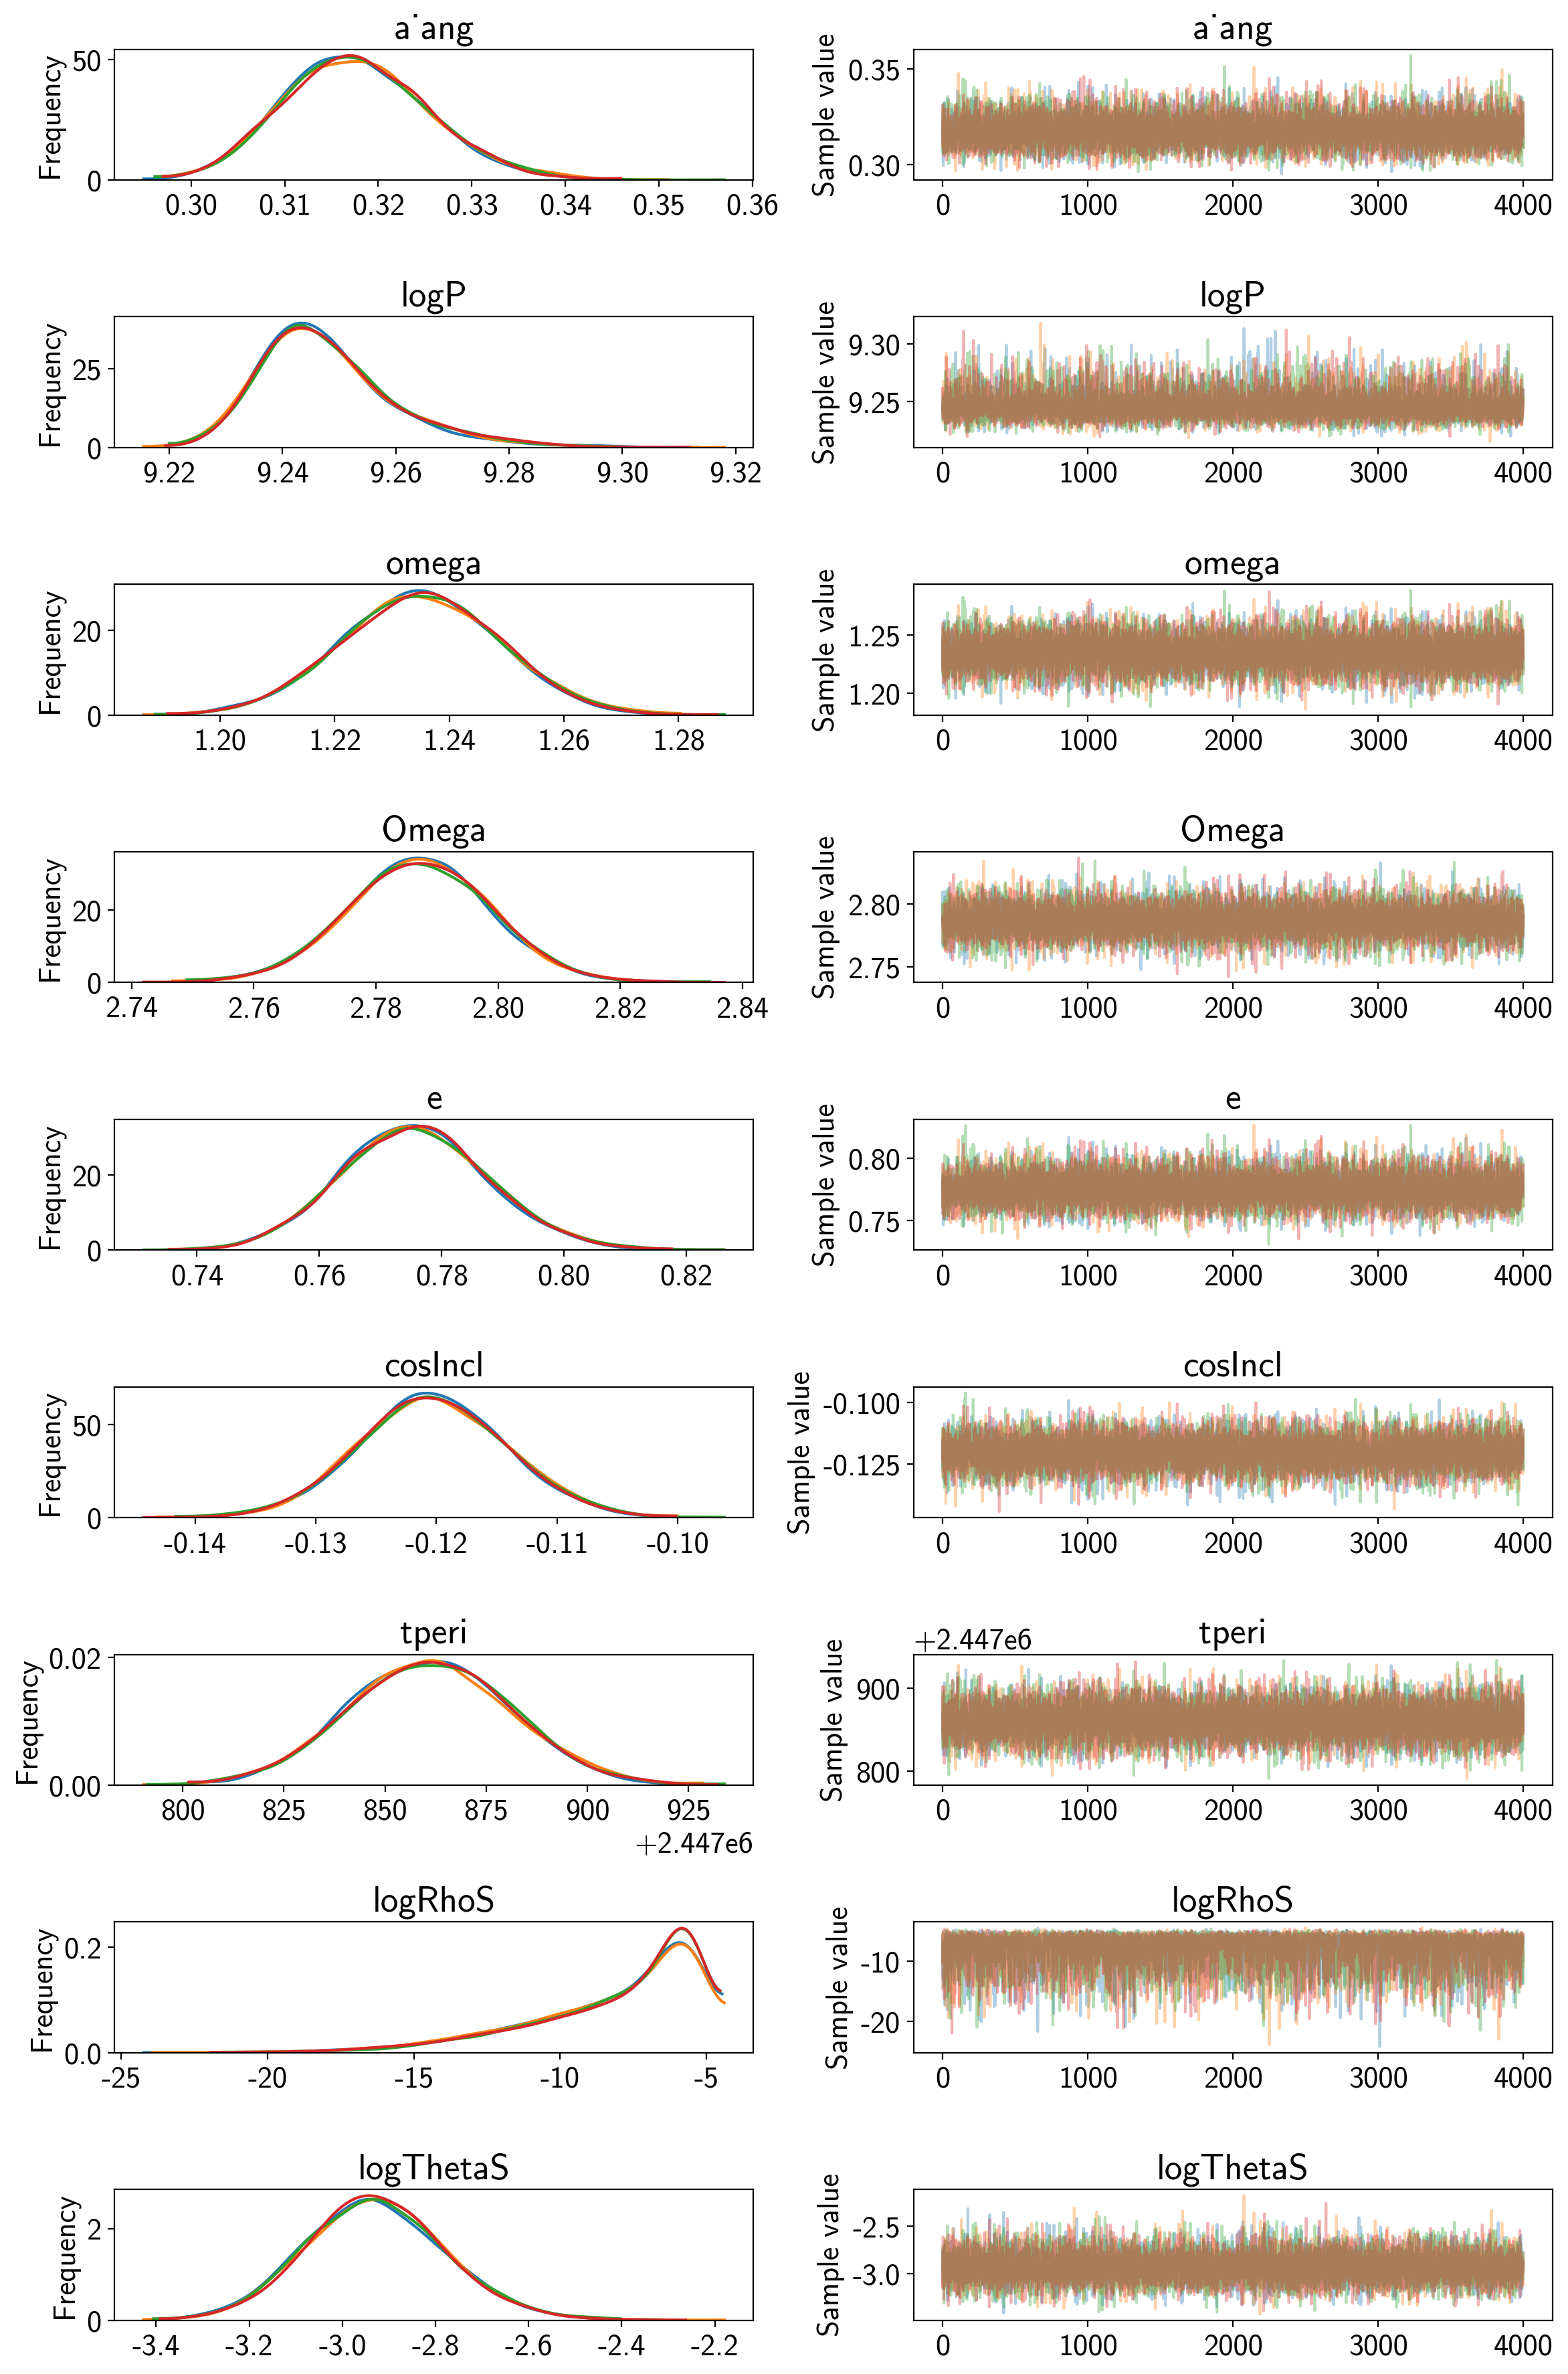

In [18]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", "logRhoS", "logThetaS"])

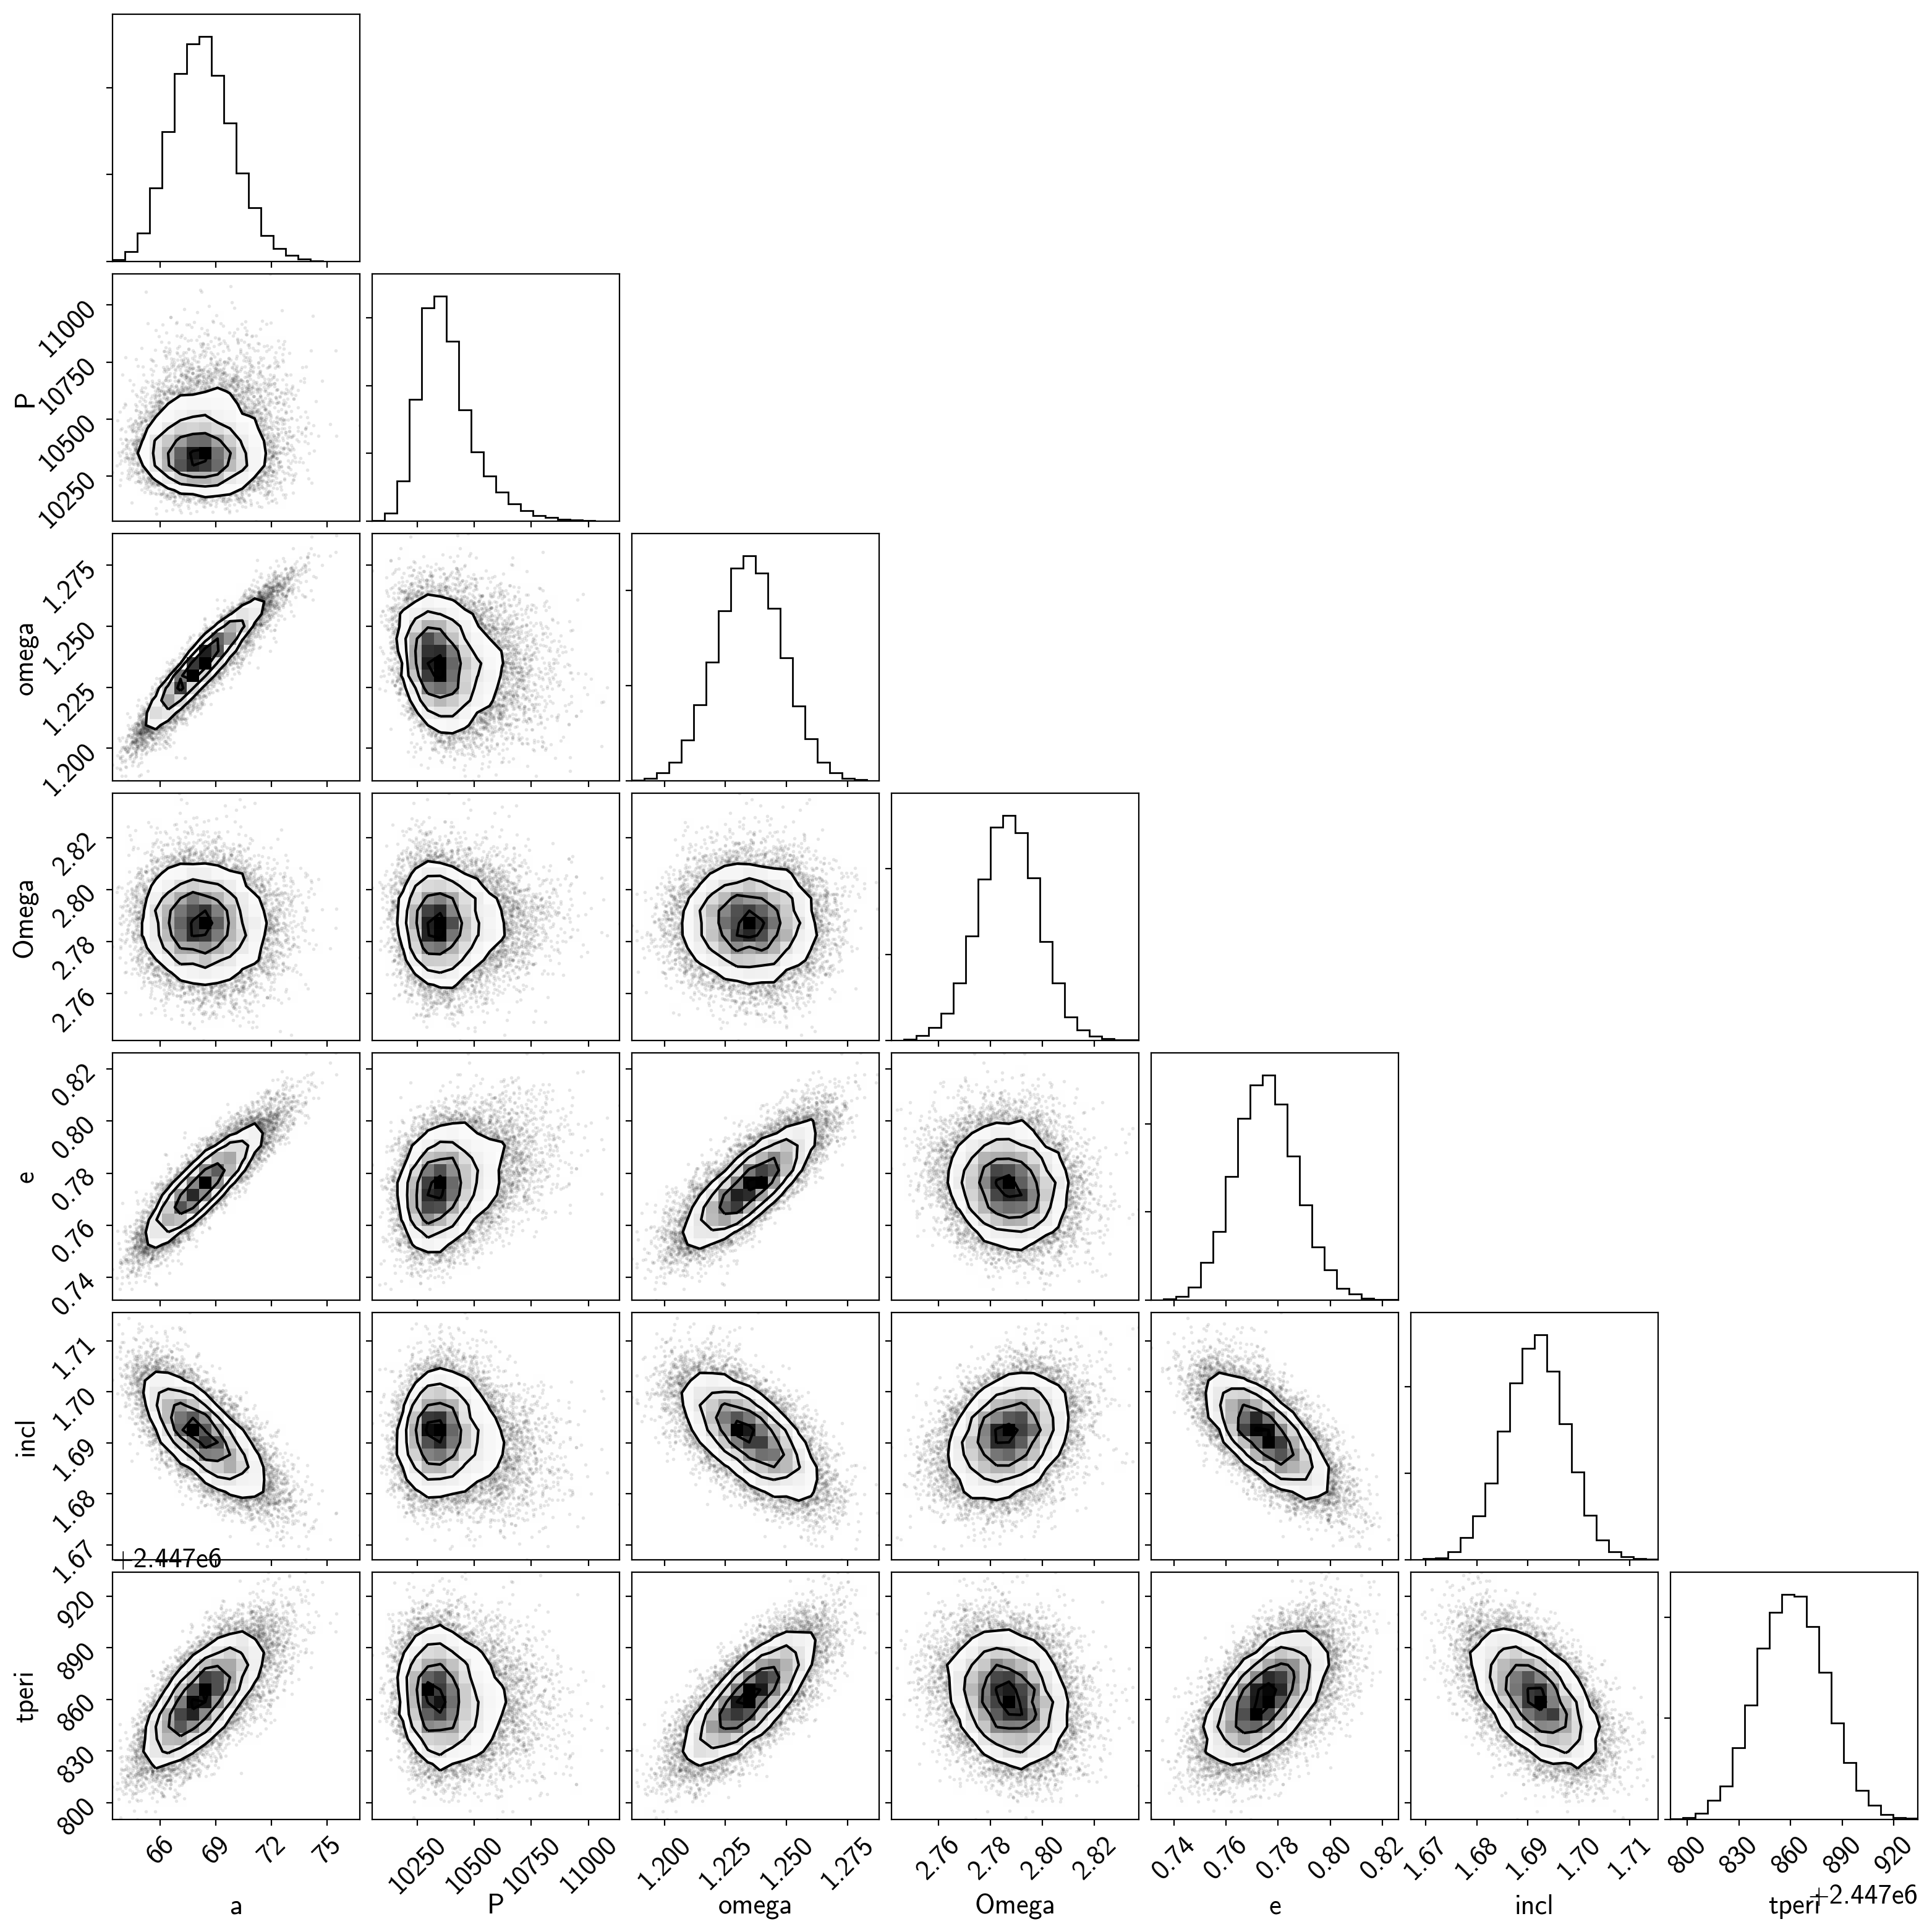

In [19]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["a", "P", "omega", "Omega", "e", "incl", "tperi"])
corner.corner(samples);

Great, it looks like we have a converged posterior, and in a pretty reasonable amount of time too. The semi-major axis and $\omega$ are quite correlated, which underscores the need for using the tuning schedule.


Note that there is also another (degenerate) solution at $\Omega + \pi$ and $\omega + \pi$ that we've missed, because we initialized the sampler deep in the potential well of our preferred peak. If you really do have an astrometric-only orbit, for this reason it can more efficient to sample in $p = \Omega + \omega$ and $m = \Omega - \omega$, since these will yield unambiguous constraints on $p$ and $m$, and $\Omega$ and $\omega$ can be backed out of them.

Let's plot the data with draws of the potential orbit, which we saved during the sampling of the model.

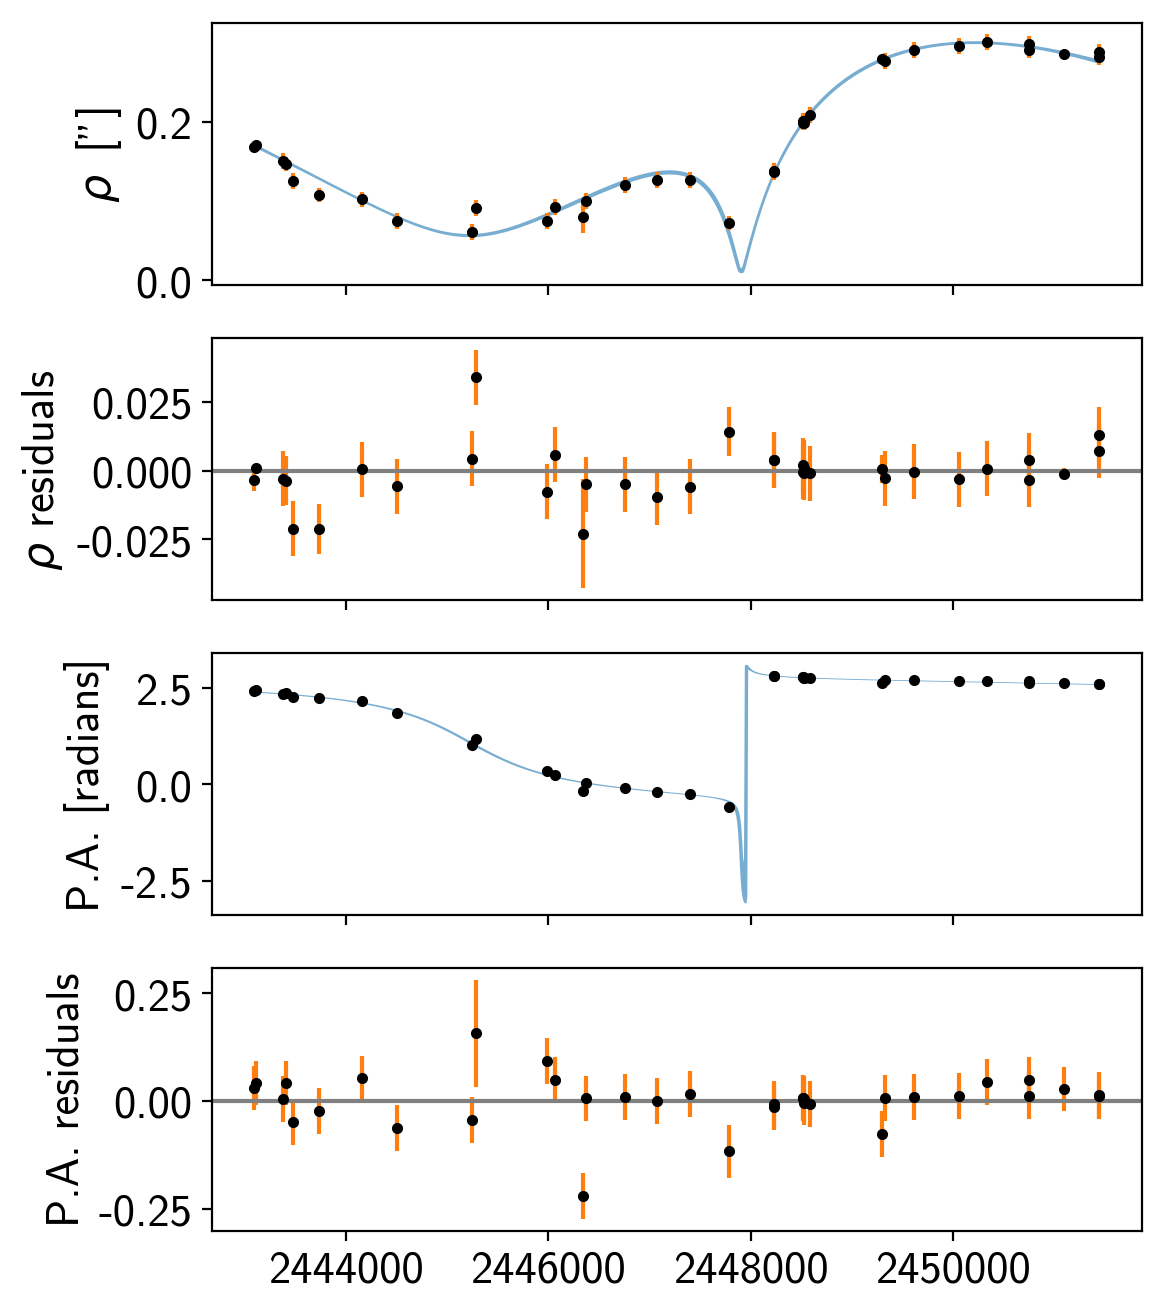

In [20]:
# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

# Compute the posterior predictions for the RV model
rho_pred = np.percentile(trace["rhoSave"], [16, 50, 84], axis=0)
theta_pred = np.percentile(trace["thetaSave"], [16, 50, 84], axis=0)

with model:
    tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_sol["logRhoS"]))
    tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_sol["logThetaS"]))
        
        
    art = ax[0].fill_between(t_fine, rho_pred[0], rho_pred[2], color="C0", alpha=0.6)
    art.set_edgecolor("none")

    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
    ax[1].axhline(0.0, color="0.5")
    ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), **pkw)
    ax[1].errorbar(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), yerr=tot_rho_err, **ekw)
    
    art = ax[2].fill_between(t_fine, theta_pred[0], theta_pred[2], color="C0", alpha=0.6)
    art.set_edgecolor("none")

    ax[2].plot(astro_jds, theta_data, **pkw)
    ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
    ax[3].axhline(0.0, color="0.5")
    ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), **pkw)
    ax[3].errorbar(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), yerr=tot_theta_err, **ekw) 

As we can see from the narrow range of orbits (the blue swath appears like a thin blue line), the orbit is actually highly constrained by the astrometry. We also see two clear outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit. It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points. We can address these with a jitter model.

# Orbital fit with parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.


In [21]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [22]:
# Set up the model in PyMC3

with pm.Model() as parallax_model:

    # A setup for a basic astrometric binary orbit
    # We'll include the parallax data as a prior on the parallax value 
    
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec 
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

In [23]:
with parallax_model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'logP_interval__', 'a_ang_interval__', 'mparallax']


message: Optimization terminated successfully.
logp: 105.44710376647738 -> 195.16465253896746


In [24]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with parallax_model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:07, 106.09draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:00<00:11, 69.13draws/s] 

Sampling 4 chains:   3%|▎         | 22/808 [00:00<00:14, 53.03draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:00<00:17, 43.45draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:00<00:19, 40.42draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:00<00:21, 36.34draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:22, 34.20draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:01<00:23, 33.24draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:01<00:23, 31.80draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:01<00:24, 30.85draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:01<00:23, 32.46draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:01<00:22, 33.01draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:01<00:23, 31.58draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:01<00:23, 31.74draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:01<00:22, 32.81draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:02<00:22, 32.98draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:02<00:22, 32.76draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:02<00:23, 31.12draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:02<00:20, 34.62draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:02<00:21, 33.68draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:02<00:21, 33.42draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:02<00:21, 33.04draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:02<00:22, 31.18draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:03<00:22, 30.73draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:03<00:21, 32.78draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:03<00:20, 34.57draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:03<00:19, 35.56draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:03<00:19, 35.09draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:03<00:19, 34.59draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:03<00:19, 34.39draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:03<00:18, 35.39draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:03<00:20, 32.88draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:04<00:20, 32.32draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:04<00:20, 32.83draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:04<00:20, 32.42draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:04<00:19, 33.12draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:04<00:18, 34.35draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:04<00:18, 34.60draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:04<00:20, 31.30draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:04<00:20, 31.35draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:05<00:19, 33.08draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:05<00:19, 32.66draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:05<00:18, 33.96draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:05<00:18, 33.86draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:05<00:17, 34.26draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:05<00:18, 32.64draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:05<00:18, 32.28draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:05<00:18, 31.91draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:06<00:18, 33.27draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:06<00:17, 33.89draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:06<00:17, 34.50draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:06<00:15, 37.15draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:06<00:16, 34.26draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:06<00:16, 34.51draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:06<00:16, 34.62draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:06<00:17, 32.56draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:07<00:17, 32.41draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:07<00:18, 30.96draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:07<00:17, 32.08draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:07<00:17, 30.89draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:07<00:18, 30.19draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:07<00:17, 31.86draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:07<00:17, 30.77draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:07<00:16, 32.21draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:08<00:16, 32.89draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:08<00:15, 33.36draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:08<00:15, 32.82draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:08<00:15, 33.91draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:08<00:16, 31.79draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:08<00:15, 33.02draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:08<00:14, 34.40draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:09<00:15, 32.57draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:09<00:15, 31.57draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:09<00:14, 33.58draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:09<00:15, 32.12draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:09<00:15, 32.25draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:09<00:15, 31.99draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:09<00:14, 32.59draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:09<00:14, 32.98draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:10<00:14, 33.29draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:10<00:14, 31.37draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:10<00:14, 31.67draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:10<00:14, 30.63draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:10<00:15, 30.08draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:10<00:14, 31.95draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:10<00:12, 34.11draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:10<00:13, 33.03draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:11<00:12, 33.99draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:11<00:12, 34.40draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:11<00:12, 33.00draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:11<00:13, 31.51draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:11<00:13, 30.84draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:11<00:13, 30.66draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:11<00:13, 30.58draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:11<00:12, 31.44draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:12<00:12, 31.99draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:12<00:12, 31.39draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:12<00:12, 32.25draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:12<00:11, 32.86draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:12<00:11, 33.49draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:12<00:11, 33.80draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:12<00:11, 31.91draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:13<00:11, 33.34draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:13<00:11, 33.00draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:13<00:11, 32.21draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:13<00:11, 32.38draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:13<00:10, 33.30draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:13<00:10, 32.09draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:13<00:11, 30.60draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:13<00:11, 29.71draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:14<00:11, 28.68draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:14<00:11, 29.77draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:14<00:10, 30.53draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:14<00:10, 31.54draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:14<00:10, 31.65draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:14<00:10, 30.69draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:14<00:10, 31.01draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:15<00:09, 31.20draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:15<00:09, 33.37draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:15<00:09, 31.36draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:15<00:09, 29.79draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:15<00:09, 29.91draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:15<00:09, 30.30draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:15<00:09, 30.88draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:15<00:08, 32.61draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:16<00:08, 31.82draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:16<00:08, 31.10draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:16<00:08, 32.03draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [00:16<00:08, 31.63draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:16<00:08, 30.75draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [00:16<00:08, 31.49draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:16<00:08, 30.36draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:17<00:07, 31.25draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [00:17<00:08, 30.13draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:17<00:07, 31.29draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:17<00:07, 30.25draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:17<00:07, 31.99draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:17<00:06, 35.21draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:17<00:06, 35.28draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:17<00:06, 32.18draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:18<00:06, 33.33draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:18<00:06, 33.54draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:18<00:06, 32.26draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:18<00:06, 31.10draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:18<00:06, 29.75draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:18<00:06, 31.33draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:18<00:05, 32.13draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:18<00:05, 31.75draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [00:19<00:05, 30.82draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:19<00:05, 32.78draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [00:19<00:05, 32.26draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:19<00:05, 33.04draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:19<00:04, 33.44draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:19<00:05, 31.61draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:19<00:04, 31.87draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [00:19<00:04, 32.96draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:20<00:04, 33.01draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:20<00:04, 32.20draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:20<00:04, 31.77draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:20<00:04, 31.73draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:20<00:03, 33.93draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:20<00:03, 32.84draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:20<00:03, 31.44draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:20<00:03, 30.44draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:21<00:03, 30.62draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:21<00:03, 32.33draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:21<00:03, 33.69draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:21<00:03, 33.57draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:21<00:03, 31.70draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:21<00:03, 31.80draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [00:21<00:02, 32.00draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:21<00:02, 30.39draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:22<00:02, 30.11draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:22<00:02, 29.88draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:22<00:02, 30.32draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:22<00:02, 31.59draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:22<00:02, 33.06draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [00:22<00:01, 33.29draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:22<00:01, 32.64draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:23<00:01, 32.06draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [00:23<00:01, 32.71draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [00:23<00:01, 29.99draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:23<00:01, 31.29draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:23<00:01, 27.74draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:23<00:01, 27.03draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:23<00:01, 23.46draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:24<00:01, 20.18draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:24<00:01, 19.55draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:24<00:01, 18.12draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:24<00:01, 15.16draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:24<00:01, 11.04draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:25<00:01,  9.28draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:25<00:01,  8.49draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:25<00:01,  8.20draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:25<00:01,  8.24draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:26<00:01,  8.21draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:26<00:01,  8.26draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:26<00:00,  8.48draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:26<00:00,  8.63draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:26<00:00,  8.22draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:26<00:00,  7.97draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:26<00:00,  8.23draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:26<00:00,  8.49draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:27<00:00,  8.33draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:27<00:00,  4.42draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:28<00:00,  3.11draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:04, 92.72draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:00<00:06, 61.04draws/s]

Sampling 4 chains:   6%|▋         | 26/408 [00:00<00:08, 47.34draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:00<00:08, 43.15draws/s]

Sampling 4 chains:   9%|▊         | 35/408 [00:00<00:08, 44.78draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:00<00:09, 40.85draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:08, 40.84draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:01<00:10, 35.54draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:01<00:10, 32.38draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:01<00:09, 35.63draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:01<00:11, 30.22draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:01<00:10, 32.80draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:01<00:09, 33.81draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:01<00:10, 31.98draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:02<00:10, 32.66draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:02<00:09, 32.94draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:02<00:10, 31.46draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:02<00:10, 30.57draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:02<00:09, 31.84draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:02<00:09, 33.13draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:02<00:08, 35.54draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:02<00:07, 38.68draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:03<00:07, 40.78draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:03<00:07, 39.94draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:03<00:06, 40.33draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:03<00:06, 42.94draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:03<00:06, 41.11draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:03<00:06, 42.20draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:03<00:06, 40.68draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:03<00:05, 42.51draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:04<00:05, 41.56draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:04<00:05, 42.31draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:04<00:06, 38.63draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:04<00:05, 41.49draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:04<00:05, 39.37draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:04<00:06, 32.70draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:04<00:06, 33.86draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:05<00:06, 32.94draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:05<00:05, 35.69draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:05<00:05, 34.44draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:05<00:05, 36.78draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:05<00:05, 36.13draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:05<00:05, 36.44draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:05<00:04, 40.21draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:05<00:04, 35.66draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:06<00:04, 38.70draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:06<00:04, 37.39draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:06<00:04, 37.00draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:06<00:04, 35.73draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:06<00:04, 37.45draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:06<00:04, 36.57draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:06<00:04, 35.74draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:06<00:03, 38.64draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:07<00:03, 40.51draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:07<00:03, 42.12draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:07<00:02, 43.43draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:07<00:02, 45.96draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:07<00:02, 48.68draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:07<00:02, 48.24draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:07<00:01, 51.06draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:07<00:01, 53.00draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:07<00:01, 53.01draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:08<00:01, 48.22draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:08<00:01, 47.19draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:08<00:01, 47.69draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:08<00:01, 44.57draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:08<00:01, 45.52draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:08<00:01, 43.40draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:08<00:01, 45.39draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:08<00:01, 39.98draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:09<00:00, 42.24draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:09<00:00, 40.81draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:09<00:00, 39.65draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:09<00:00, 34.12draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:09<00:00, 31.67draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:09<00:00, 33.46draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:10<00:00, 27.13draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:10<00:00, 22.62draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:10<00:00, 13.68draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:11<00:00, 36.74draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:05, 146.42draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:10, 72.12draws/s] 

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:15, 51.11draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:19, 40.65draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:00<00:22, 35.09draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:23, 32.56draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:01<00:24, 30.70draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:01<00:25, 29.47draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:01<00:23, 31.94draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:01<00:22, 33.24draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:01<00:20, 35.69draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:01<00:19, 38.99draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:18, 40.42draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:01<00:15, 47.27draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:01<00:12, 57.34draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:02<00:09, 71.84draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:02<00:07, 88.68draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:02<00:05, 109.89draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:02<00:04, 127.21draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:02<00:04, 142.89draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:02<00:03, 155.58draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:02<00:03, 167.75draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:02<00:02, 185.20draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:02<00:02, 199.89draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:02<00:02, 204.65draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:03<00:02, 213.69draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:03<00:02, 216.65draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:03<00:01, 237.95draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:03<00:01, 240.05draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:03<00:01, 249.89draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:03<00:01, 257.78draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:03<00:01, 263.70draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:03<00:01, 269.89draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:03<00:00, 287.47draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:04<00:00, 292.00draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:04<00:00, 290.17draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:04<00:00, 280.17draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:04<00:00, 284.29draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:04<00:00, 270.16draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:04<00:00, 277.82draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:04<00:00, 282.63draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:04<00:00, 208.02draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 164.18draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:00<00:12, 128.86draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:00<00:27, 58.23draws/s] 

Sampling 4 chains:   1%|▏         | 22/1608 [00:00<00:36, 43.21draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:00<00:41, 38.36draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:00<00:43, 36.04draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:00<00:46, 33.75draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:00<00:49, 31.62draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:01<00:54, 28.58draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:01<00:57, 27.22draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:01<00:54, 28.56draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:01<00:49, 31.13draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:01<00:50, 31.00draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:01<00:43, 35.43draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:01<00:37, 41.40draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:01<00:30, 49.78draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:01<00:24, 62.17draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:02<00:18, 78.83draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:02<00:14, 98.02draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:02<00:12, 116.92draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:02<00:10, 141.80draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:02<00:08, 161.59draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:02<00:07, 178.17draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:02<00:06, 197.77draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:02<00:06, 207.57draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:02<00:06, 202.11draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:03<00:05, 217.69draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:03<00:05, 225.75draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:03<00:05, 224.08draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:03<00:05, 221.48draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:03<00:05, 225.86draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [00:03<00:05, 224.29draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [00:03<00:05, 222.97draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:03<00:04, 234.89draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:03<00:04, 237.53draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:04<00:04, 232.68draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [00:04<00:04, 234.50draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [00:04<00:04, 236.79draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [00:04<00:04, 237.83draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [00:04<00:03, 251.26draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [00:04<00:03, 258.87draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [00:04<00:03, 260.13draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [00:04<00:03, 259.06draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [00:04<00:03, 257.98draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [00:04<00:03, 257.78draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [00:05<00:03, 241.17draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [00:05<00:03, 246.67draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [00:05<00:02, 241.85draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [00:05<00:02, 239.02draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [00:05<00:03, 220.35draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [00:05<00:03, 202.35draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [00:05<00:03, 207.43draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [00:05<00:02, 215.96draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [00:05<00:02, 221.27draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [00:06<00:02, 237.92draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [00:06<00:02, 232.81draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [00:06<00:02, 230.75draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [00:06<00:02, 231.94draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [00:06<00:01, 241.21draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [00:06<00:01, 256.74draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [00:06<00:01, 262.95draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [00:06<00:01, 261.55draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [00:06<00:01, 241.21draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [00:07<00:01, 227.99draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [00:07<00:01, 222.43draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [00:07<00:01, 224.57draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [00:07<00:00, 240.59draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [00:07<00:00, 227.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [00:07<00:00, 219.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [00:07<00:00, 221.16draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [00:07<00:00, 225.37draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [00:07<00:00, 224.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [00:08<00:00, 207.35draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [00:08<00:00, 181.56draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [00:08<00:00, 164.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [00:08<00:00, 156.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [00:08<00:00, 116.01draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [00:08<00:00, 97.10draws/s] 

Sampling 4 chains: 100%|██████████| 1608/1608 [00:09<00:00, 178.35draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:00<00:22, 142.97draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:00<00:43, 73.42draws/s] 

Sampling 4 chains:   1%|          | 25/3208 [00:00<01:01, 51.47draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:00<01:13, 43.39draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:00<01:25, 37.23draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:00<01:31, 34.83draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:00<01:37, 32.64draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:01<01:35, 33.02draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:01<01:43, 30.58draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:01<01:36, 32.84draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:01<01:27, 35.84draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:01<01:15, 41.88draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:01<01:02, 50.22draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:01<00:50, 61.47draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:01<00:40, 75.85draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:02<00:32, 93.36draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:02<00:29, 104.86draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:02<00:25, 121.52draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:02<00:23, 129.56draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:02<00:20, 144.50draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:02<00:18, 160.34draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:02<00:16, 183.51draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:02<00:14, 204.58draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:02<00:14, 200.36draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:02<00:14, 205.23draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:03<00:13, 213.21draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:03<00:12, 221.30draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:03<00:12, 227.94draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:03<00:12, 224.93draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [00:03<00:12, 225.90draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [00:03<00:12, 225.86draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [00:03<00:12, 216.55draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [00:03<00:12, 208.70draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [00:03<00:12, 206.02draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [00:04<00:12, 213.59draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [00:04<00:12, 212.75draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [00:04<00:11, 220.49draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [00:04<00:11, 230.13draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [00:04<00:10, 235.27draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [00:04<00:10, 243.17draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [00:04<00:10, 243.47draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [00:04<00:09, 247.95draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [00:04<00:09, 261.21draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [00:04<00:09, 262.16draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [00:05<00:08, 273.16draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [00:05<00:08, 265.54draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [00:05<00:09, 251.12draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [00:05<00:08, 256.18draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [00:05<00:08, 256.30draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [00:05<00:09, 239.26draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [00:05<00:09, 235.35draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [00:05<00:09, 238.92draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [00:05<00:09, 231.79draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [00:06<00:09, 231.07draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [00:06<00:09, 227.29draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [00:06<00:09, 231.52draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [00:06<00:08, 247.03draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [00:06<00:08, 250.05draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [00:06<00:08, 239.54draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [00:06<00:08, 228.03draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [00:06<00:08, 229.86draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [00:06<00:08, 238.78draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [00:07<00:07, 238.88draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [00:07<00:07, 240.42draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [00:07<00:07, 247.12draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [00:07<00:07, 254.70draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [00:07<00:07, 249.80draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [00:07<00:07, 252.53draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [00:07<00:07, 242.31draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [00:07<00:07, 232.77draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [00:07<00:07, 233.02draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [00:08<00:07, 233.58draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [00:08<00:07, 228.64draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [00:08<00:06, 240.02draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [00:08<00:06, 250.88draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [00:08<00:05, 263.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [00:08<00:05, 261.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [00:08<00:05, 252.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [00:08<00:05, 253.34draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [00:08<00:05, 263.94draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [00:08<00:05, 260.12draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [00:09<00:05, 265.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [00:09<00:05, 264.70draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [00:09<00:05, 265.90draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [00:09<00:04, 269.97draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [00:09<00:04, 269.10draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [00:09<00:04, 276.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [00:09<00:04, 287.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [00:09<00:04, 292.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [00:09<00:04, 285.93draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [00:10<00:04, 280.20draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [00:10<00:03, 289.37draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [00:10<00:03, 276.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [00:10<00:04, 259.79draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [00:10<00:03, 260.53draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [00:10<00:03, 276.55draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [00:10<00:03, 295.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [00:10<00:03, 280.17draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [00:10<00:03, 268.17draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [00:11<00:03, 259.75draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [00:11<00:03, 254.68draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [00:11<00:03, 255.01draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [00:11<00:03, 251.18draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [00:11<00:03, 238.63draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [00:11<00:03, 232.41draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [00:11<00:03, 225.30draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [00:11<00:03, 226.16draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [00:11<00:02, 221.31draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [00:12<00:02, 226.25draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [00:12<00:02, 228.61draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [00:12<00:02, 230.37draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [00:12<00:02, 246.82draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [00:12<00:02, 259.19draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [00:12<00:01, 252.60draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [00:12<00:01, 259.84draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [00:12<00:01, 262.29draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [00:12<00:01, 269.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [00:12<00:01, 241.53draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [00:13<00:01, 241.10draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [00:13<00:01, 234.46draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [00:13<00:01, 238.70draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [00:13<00:01, 245.41draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [00:13<00:01, 229.92draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [00:13<00:01, 217.43draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [00:13<00:01, 203.82draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [00:13<00:00, 198.89draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [00:14<00:00, 197.03draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [00:14<00:00, 180.63draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [00:14<00:00, 175.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [00:14<00:00, 185.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [00:14<00:00, 172.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [00:14<00:00, 160.38draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [00:14<00:00, 110.93draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [00:15<00:00, 87.35draws/s] 

Sampling 4 chains:  99%|█████████▉| 3186/3208 [00:15<00:00, 78.21draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [00:15<00:00, 73.25draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [00:15<00:00, 65.55draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:15<00:00, 203.74draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 15/9208 [00:00<01:09, 131.37draws/s]

Sampling 4 chains:   0%|          | 19/9208 [00:00<02:36, 58.89draws/s] 

Sampling 4 chains:   0%|          | 23/9208 [00:00<03:21, 45.59draws/s]

Sampling 4 chains:   0%|          | 27/9208 [00:00<03:51, 39.64draws/s]

Sampling 4 chains:   0%|          | 31/9208 [00:00<04:00, 38.15draws/s]

Sampling 4 chains:   0%|          | 35/9208 [00:00<04:25, 34.52draws/s]

Sampling 4 chains:   0%|          | 39/9208 [00:00<04:55, 31.07draws/s]

Sampling 4 chains:   0%|          | 42/9208 [00:01<05:02, 30.33draws/s]

Sampling 4 chains:   0%|          | 45/9208 [00:01<05:16, 28.94draws/s]

Sampling 4 chains:   1%|          | 49/9208 [00:01<05:20, 28.55draws/s]

Sampling 4 chains:   1%|          | 53/9208 [00:01<04:59, 30.53draws/s]

Sampling 4 chains:   1%|          | 59/9208 [00:01<04:20, 35.14draws/s]

Sampling 4 chains:   1%|          | 65/9208 [00:01<03:55, 38.86draws/s]

Sampling 4 chains:   1%|          | 75/9208 [00:01<03:13, 47.31draws/s]

Sampling 4 chains:   1%|          | 87/9208 [00:01<02:38, 57.54draws/s]

Sampling 4 chains:   1%|          | 99/9208 [00:01<02:15, 67.12draws/s]

Sampling 4 chains:   1%|▏         | 118/9208 [00:02<01:50, 82.40draws/s]

Sampling 4 chains:   2%|▏         | 141/9208 [00:02<01:29, 101.10draws/s]

Sampling 4 chains:   2%|▏         | 157/9208 [00:02<01:21, 111.52draws/s]

Sampling 4 chains:   2%|▏         | 172/9208 [00:02<01:20, 112.76draws/s]

Sampling 4 chains:   2%|▏         | 188/9208 [00:02<01:13, 122.93draws/s]

Sampling 4 chains:   2%|▏         | 207/9208 [00:02<01:07, 133.97draws/s]

Sampling 4 chains:   2%|▏         | 223/9208 [00:02<01:06, 135.11draws/s]

Sampling 4 chains:   3%|▎         | 242/9208 [00:02<01:00, 147.66draws/s]

Sampling 4 chains:   3%|▎         | 260/9208 [00:02<00:58, 153.51draws/s]

Sampling 4 chains:   3%|▎         | 278/9208 [00:03<00:56, 157.77draws/s]

Sampling 4 chains:   3%|▎         | 295/9208 [00:03<00:55, 160.17draws/s]

Sampling 4 chains:   3%|▎         | 317/9208 [00:03<00:51, 172.33draws/s]

Sampling 4 chains:   4%|▎         | 337/9208 [00:03<00:49, 178.55draws/s]

Sampling 4 chains:   4%|▍         | 360/9208 [00:03<00:46, 191.06draws/s]

Sampling 4 chains:   4%|▍         | 382/9208 [00:03<00:44, 197.29draws/s]

Sampling 4 chains:   4%|▍         | 404/9208 [00:03<00:43, 201.64draws/s]

Sampling 4 chains:   5%|▍         | 426/9208 [00:03<00:43, 203.49draws/s]

Sampling 4 chains:   5%|▍         | 449/9208 [00:03<00:41, 210.60draws/s]

Sampling 4 chains:   5%|▌         | 474/9208 [00:03<00:40, 216.23draws/s]

Sampling 4 chains:   5%|▌         | 497/9208 [00:04<00:39, 219.54draws/s]

Sampling 4 chains:   6%|▌         | 521/9208 [00:04<00:38, 224.85draws/s]

Sampling 4 chains:   6%|▌         | 544/9208 [00:04<00:39, 221.28draws/s]

Sampling 4 chains:   6%|▌         | 567/9208 [00:04<00:43, 199.89draws/s]

Sampling 4 chains:   6%|▋         | 588/9208 [00:04<00:43, 197.01draws/s]

Sampling 4 chains:   7%|▋         | 609/9208 [00:04<00:44, 191.59draws/s]

Sampling 4 chains:   7%|▋         | 630/9208 [00:04<00:44, 192.71draws/s]

Sampling 4 chains:   7%|▋         | 650/9208 [00:04<00:45, 188.97draws/s]

Sampling 4 chains:   7%|▋         | 672/9208 [00:04<00:43, 196.74draws/s]

Sampling 4 chains:   8%|▊         | 697/9208 [00:05<00:40, 208.29draws/s]

Sampling 4 chains:   8%|▊         | 730/9208 [00:05<00:36, 229.28draws/s]

Sampling 4 chains:   8%|▊         | 759/9208 [00:05<00:34, 242.25draws/s]

Sampling 4 chains:   9%|▊         | 788/9208 [00:05<00:33, 253.64draws/s]

Sampling 4 chains:   9%|▉         | 815/9208 [00:05<00:33, 251.28draws/s]

Sampling 4 chains:   9%|▉         | 841/9208 [00:05<00:35, 237.57draws/s]

Sampling 4 chains:   9%|▉         | 870/9208 [00:05<00:33, 245.83draws/s]

Sampling 4 chains:  10%|▉         | 896/9208 [00:05<00:33, 248.49draws/s]

Sampling 4 chains:  10%|█         | 922/9208 [00:05<00:33, 246.63draws/s]

Sampling 4 chains:  10%|█         | 947/9208 [00:06<00:33, 244.41draws/s]

Sampling 4 chains:  11%|█         | 976/9208 [00:06<00:32, 254.33draws/s]

Sampling 4 chains:  11%|█         | 1004/9208 [00:06<00:31, 260.71draws/s]

Sampling 4 chains:  11%|█         | 1031/9208 [00:06<00:31, 257.60draws/s]

Sampling 4 chains:  12%|█▏        | 1061/9208 [00:06<00:30, 266.64draws/s]

Sampling 4 chains:  12%|█▏        | 1088/9208 [00:06<00:32, 253.62draws/s]

Sampling 4 chains:  12%|█▏        | 1115/9208 [00:06<00:31, 257.50draws/s]

Sampling 4 chains:  12%|█▏        | 1141/9208 [00:06<00:34, 231.92draws/s]

Sampling 4 chains:  13%|█▎        | 1165/9208 [00:06<00:38, 211.00draws/s]

Sampling 4 chains:  13%|█▎        | 1187/9208 [00:07<00:38, 208.88draws/s]

Sampling 4 chains:  13%|█▎        | 1212/9208 [00:07<00:36, 217.41draws/s]

Sampling 4 chains:  13%|█▎        | 1237/9208 [00:07<00:35, 224.10draws/s]

Sampling 4 chains:  14%|█▎        | 1261/9208 [00:07<00:34, 227.97draws/s]

Sampling 4 chains:  14%|█▍        | 1285/9208 [00:07<00:34, 230.28draws/s]

Sampling 4 chains:  14%|█▍        | 1309/9208 [00:07<00:36, 219.04draws/s]

Sampling 4 chains:  14%|█▍        | 1332/9208 [00:07<00:35, 222.14draws/s]

Sampling 4 chains:  15%|█▍        | 1361/9208 [00:07<00:32, 238.14draws/s]

Sampling 4 chains:  15%|█▌        | 1391/9208 [00:07<00:31, 251.06draws/s]

Sampling 4 chains:  15%|█▌        | 1417/9208 [00:08<00:31, 247.20draws/s]

Sampling 4 chains:  16%|█▌        | 1443/9208 [00:08<00:31, 246.69draws/s]

Sampling 4 chains:  16%|█▌        | 1468/9208 [00:08<00:33, 234.47draws/s]

Sampling 4 chains:  16%|█▌        | 1492/9208 [00:08<00:34, 223.82draws/s]

Sampling 4 chains:  16%|█▋        | 1519/9208 [00:08<00:32, 233.84draws/s]

Sampling 4 chains:  17%|█▋        | 1551/9208 [00:08<00:30, 251.10draws/s]

Sampling 4 chains:  17%|█▋        | 1577/9208 [00:08<00:30, 247.98draws/s]

Sampling 4 chains:  17%|█▋        | 1603/9208 [00:08<00:31, 238.69draws/s]

Sampling 4 chains:  18%|█▊        | 1631/9208 [00:08<00:30, 247.58draws/s]

Sampling 4 chains:  18%|█▊        | 1657/9208 [00:09<00:30, 246.81draws/s]

Sampling 4 chains:  18%|█▊        | 1682/9208 [00:09<00:30, 246.29draws/s]

Sampling 4 chains:  19%|█▊        | 1707/9208 [00:09<00:30, 246.52draws/s]

Sampling 4 chains:  19%|█▉        | 1732/9208 [00:09<00:31, 237.22draws/s]

Sampling 4 chains:  19%|█▉        | 1756/9208 [00:09<00:32, 231.58draws/s]

Sampling 4 chains:  19%|█▉        | 1780/9208 [00:09<00:34, 216.79draws/s]

Sampling 4 chains:  20%|█▉        | 1804/9208 [00:09<00:33, 223.10draws/s]

Sampling 4 chains:  20%|█▉        | 1827/9208 [00:09<00:33, 223.20draws/s]

Sampling 4 chains:  20%|██        | 1850/9208 [00:09<00:33, 217.56draws/s]

Sampling 4 chains:  20%|██        | 1874/9208 [00:09<00:33, 221.89draws/s]

Sampling 4 chains:  21%|██        | 1899/9208 [00:10<00:31, 228.84draws/s]

Sampling 4 chains:  21%|██        | 1926/9208 [00:10<00:30, 239.50draws/s]

Sampling 4 chains:  21%|██▏       | 1958/9208 [00:10<00:28, 257.03draws/s]

Sampling 4 chains:  22%|██▏       | 1985/9208 [00:10<00:29, 243.52draws/s]

Sampling 4 chains:  22%|██▏       | 2010/9208 [00:10<00:31, 229.60draws/s]

Sampling 4 chains:  22%|██▏       | 2036/9208 [00:10<00:30, 237.36draws/s]

Sampling 4 chains:  22%|██▏       | 2061/9208 [00:10<00:29, 239.21draws/s]

Sampling 4 chains:  23%|██▎       | 2086/9208 [00:10<00:30, 235.12draws/s]

Sampling 4 chains:  23%|██▎       | 2114/9208 [00:10<00:28, 245.67draws/s]

Sampling 4 chains:  23%|██▎       | 2139/9208 [00:11<00:29, 239.41draws/s]

Sampling 4 chains:  24%|██▎       | 2164/9208 [00:11<00:30, 232.09draws/s]

Sampling 4 chains:  24%|██▍       | 2191/9208 [00:11<00:29, 240.90draws/s]

Sampling 4 chains:  24%|██▍       | 2216/9208 [00:11<00:29, 236.68draws/s]

Sampling 4 chains:  24%|██▍       | 2240/9208 [00:11<00:30, 231.86draws/s]

Sampling 4 chains:  25%|██▍       | 2264/9208 [00:11<00:30, 225.11draws/s]

Sampling 4 chains:  25%|██▍       | 2288/9208 [00:11<00:30, 228.14draws/s]

Sampling 4 chains:  25%|██▌       | 2313/9208 [00:11<00:30, 225.22draws/s]

Sampling 4 chains:  25%|██▌       | 2336/9208 [00:11<00:30, 224.83draws/s]

Sampling 4 chains:  26%|██▌       | 2363/9208 [00:12<00:29, 234.98draws/s]

Sampling 4 chains:  26%|██▌       | 2387/9208 [00:12<00:29, 234.58draws/s]

Sampling 4 chains:  26%|██▌       | 2411/9208 [00:12<00:29, 233.54draws/s]

Sampling 4 chains:  26%|██▋       | 2437/9208 [00:12<00:28, 239.10draws/s]

Sampling 4 chains:  27%|██▋       | 2463/9208 [00:12<00:27, 243.76draws/s]

Sampling 4 chains:  27%|██▋       | 2491/9208 [00:12<00:26, 250.05draws/s]

Sampling 4 chains:  27%|██▋       | 2517/9208 [00:12<00:28, 232.51draws/s]

Sampling 4 chains:  28%|██▊       | 2541/9208 [00:12<00:28, 233.99draws/s]

Sampling 4 chains:  28%|██▊       | 2565/9208 [00:12<00:28, 230.25draws/s]

Sampling 4 chains:  28%|██▊       | 2589/9208 [00:13<00:29, 224.43draws/s]

Sampling 4 chains:  28%|██▊       | 2613/9208 [00:13<00:29, 224.43draws/s]

Sampling 4 chains:  29%|██▊       | 2638/9208 [00:13<00:28, 231.37draws/s]

Sampling 4 chains:  29%|██▉       | 2665/9208 [00:13<00:27, 238.68draws/s]

Sampling 4 chains:  29%|██▉       | 2690/9208 [00:13<00:27, 240.02draws/s]

Sampling 4 chains:  29%|██▉       | 2716/9208 [00:13<00:26, 242.90draws/s]

Sampling 4 chains:  30%|██▉       | 2741/9208 [00:13<00:27, 238.30draws/s]

Sampling 4 chains:  30%|███       | 2767/9208 [00:13<00:26, 242.03draws/s]

Sampling 4 chains:  30%|███       | 2792/9208 [00:13<00:27, 236.12draws/s]

Sampling 4 chains:  31%|███       | 2816/9208 [00:13<00:27, 229.91draws/s]

Sampling 4 chains:  31%|███       | 2842/9208 [00:14<00:26, 236.19draws/s]

Sampling 4 chains:  31%|███       | 2867/9208 [00:14<00:26, 240.05draws/s]

Sampling 4 chains:  31%|███▏      | 2894/9208 [00:14<00:25, 245.56draws/s]

Sampling 4 chains:  32%|███▏      | 2924/9208 [00:14<00:24, 258.43draws/s]

Sampling 4 chains:  32%|███▏      | 2951/9208 [00:14<00:24, 259.39draws/s]

Sampling 4 chains:  32%|███▏      | 2979/9208 [00:14<00:23, 264.71draws/s]

Sampling 4 chains:  33%|███▎      | 3006/9208 [00:14<00:23, 264.22draws/s]

Sampling 4 chains:  33%|███▎      | 3033/9208 [00:14<00:25, 246.71draws/s]

Sampling 4 chains:  33%|███▎      | 3058/9208 [00:14<00:25, 237.52draws/s]

Sampling 4 chains:  33%|███▎      | 3083/9208 [00:15<00:26, 233.42draws/s]

Sampling 4 chains:  34%|███▍      | 3113/9208 [00:15<00:24, 249.01draws/s]

Sampling 4 chains:  34%|███▍      | 3144/9208 [00:15<00:23, 261.09draws/s]

Sampling 4 chains:  34%|███▍      | 3171/9208 [00:15<00:23, 260.92draws/s]

Sampling 4 chains:  35%|███▍      | 3198/9208 [00:15<00:23, 251.85draws/s]

Sampling 4 chains:  35%|███▌      | 3224/9208 [00:15<00:24, 244.10draws/s]

Sampling 4 chains:  35%|███▌      | 3249/9208 [00:15<00:24, 243.17draws/s]

Sampling 4 chains:  36%|███▌      | 3274/9208 [00:15<00:24, 241.01draws/s]

Sampling 4 chains:  36%|███▌      | 3299/9208 [00:15<00:25, 234.18draws/s]

Sampling 4 chains:  36%|███▌      | 3324/9208 [00:16<00:24, 237.82draws/s]

Sampling 4 chains:  36%|███▋      | 3354/9208 [00:16<00:23, 249.90draws/s]

Sampling 4 chains:  37%|███▋      | 3381/9208 [00:16<00:22, 254.74draws/s]

Sampling 4 chains:  37%|███▋      | 3407/9208 [00:16<00:22, 253.54draws/s]

Sampling 4 chains:  37%|███▋      | 3433/9208 [00:16<00:23, 250.77draws/s]

Sampling 4 chains:  38%|███▊      | 3466/9208 [00:16<00:21, 268.76draws/s]

Sampling 4 chains:  38%|███▊      | 3494/9208 [00:16<00:21, 271.84draws/s]

Sampling 4 chains:  38%|███▊      | 3528/9208 [00:16<00:19, 285.92draws/s]

Sampling 4 chains:  39%|███▊      | 3558/9208 [00:16<00:20, 279.62draws/s]

Sampling 4 chains:  39%|███▉      | 3587/9208 [00:16<00:21, 261.22draws/s]

Sampling 4 chains:  39%|███▉      | 3614/9208 [00:17<00:21, 259.83draws/s]

Sampling 4 chains:  40%|███▉      | 3641/9208 [00:17<00:21, 254.79draws/s]

Sampling 4 chains:  40%|███▉      | 3667/9208 [00:17<00:22, 250.87draws/s]

Sampling 4 chains:  40%|████      | 3693/9208 [00:17<00:21, 252.27draws/s]

Sampling 4 chains:  40%|████      | 3719/9208 [00:17<00:21, 251.14draws/s]

Sampling 4 chains:  41%|████      | 3745/9208 [00:17<00:21, 249.73draws/s]

Sampling 4 chains:  41%|████      | 3771/9208 [00:17<00:21, 250.20draws/s]

Sampling 4 chains:  41%|████      | 3798/9208 [00:17<00:21, 255.04draws/s]

Sampling 4 chains:  42%|████▏     | 3824/9208 [00:17<00:21, 255.74draws/s]

Sampling 4 chains:  42%|████▏     | 3850/9208 [00:18<00:21, 254.10draws/s]

Sampling 4 chains:  42%|████▏     | 3876/9208 [00:18<00:21, 252.85draws/s]

Sampling 4 chains:  42%|████▏     | 3902/9208 [00:18<00:20, 252.81draws/s]

Sampling 4 chains:  43%|████▎     | 3929/9208 [00:18<00:20, 255.91draws/s]

Sampling 4 chains:  43%|████▎     | 3955/9208 [00:18<00:20, 253.48draws/s]

Sampling 4 chains:  43%|████▎     | 3982/9208 [00:18<00:20, 255.87draws/s]

Sampling 4 chains:  44%|████▎     | 4008/9208 [00:18<00:21, 239.81draws/s]

Sampling 4 chains:  44%|████▍     | 4033/9208 [00:18<00:21, 235.65draws/s]

Sampling 4 chains:  44%|████▍     | 4057/9208 [00:18<00:22, 231.97draws/s]

Sampling 4 chains:  44%|████▍     | 4081/9208 [00:18<00:22, 228.33draws/s]

Sampling 4 chains:  45%|████▍     | 4109/9208 [00:19<00:21, 236.09draws/s]

Sampling 4 chains:  45%|████▍     | 4141/9208 [00:19<00:19, 254.46draws/s]

Sampling 4 chains:  45%|████▌     | 4174/9208 [00:19<00:18, 271.17draws/s]

Sampling 4 chains:  46%|████▌     | 4205/9208 [00:19<00:17, 280.61draws/s]

Sampling 4 chains:  46%|████▌     | 4234/9208 [00:19<00:19, 261.77draws/s]

Sampling 4 chains:  46%|████▋     | 4263/9208 [00:19<00:18, 267.38draws/s]

Sampling 4 chains:  47%|████▋     | 4291/9208 [00:19<00:19, 258.41draws/s]

Sampling 4 chains:  47%|████▋     | 4318/9208 [00:19<00:20, 238.78draws/s]

Sampling 4 chains:  47%|████▋     | 4343/9208 [00:20<00:21, 227.37draws/s]

Sampling 4 chains:  47%|████▋     | 4367/9208 [00:20<00:21, 221.89draws/s]

Sampling 4 chains:  48%|████▊     | 4391/9208 [00:20<00:22, 218.65draws/s]

Sampling 4 chains:  48%|████▊     | 4414/9208 [00:20<00:21, 219.99draws/s]

Sampling 4 chains:  48%|████▊     | 4437/9208 [00:20<00:21, 221.56draws/s]

Sampling 4 chains:  48%|████▊     | 4460/9208 [00:20<00:21, 222.59draws/s]

Sampling 4 chains:  49%|████▊     | 4485/9208 [00:20<00:20, 227.12draws/s]

Sampling 4 chains:  49%|████▉     | 4510/9208 [00:20<00:20, 230.27draws/s]

Sampling 4 chains:  49%|████▉     | 4538/9208 [00:20<00:19, 241.08draws/s]

Sampling 4 chains:  50%|████▉     | 4563/9208 [00:20<00:19, 237.70draws/s]

Sampling 4 chains:  50%|████▉     | 4587/9208 [00:21<00:20, 226.46draws/s]

Sampling 4 chains:  50%|█████     | 4612/9208 [00:21<00:19, 232.31draws/s]

Sampling 4 chains:  50%|█████     | 4641/9208 [00:21<00:18, 244.03draws/s]

Sampling 4 chains:  51%|█████     | 4666/9208 [00:21<00:19, 236.72draws/s]

Sampling 4 chains:  51%|█████     | 4690/9208 [00:21<00:19, 233.94draws/s]

Sampling 4 chains:  51%|█████     | 4716/9208 [00:21<00:18, 237.37draws/s]

Sampling 4 chains:  51%|█████▏    | 4741/9208 [00:21<00:18, 239.15draws/s]

Sampling 4 chains:  52%|█████▏    | 4766/9208 [00:21<00:18, 241.36draws/s]

Sampling 4 chains:  52%|█████▏    | 4794/9208 [00:21<00:17, 251.56draws/s]

Sampling 4 chains:  52%|█████▏    | 4823/9208 [00:22<00:16, 260.72draws/s]

Sampling 4 chains:  53%|█████▎    | 4850/9208 [00:22<00:17, 253.35draws/s]

Sampling 4 chains:  53%|█████▎    | 4876/9208 [00:22<00:17, 246.96draws/s]

Sampling 4 chains:  53%|█████▎    | 4902/9208 [00:22<00:17, 246.02draws/s]

Sampling 4 chains:  54%|█████▎    | 4927/9208 [00:22<00:17, 240.94draws/s]

Sampling 4 chains:  54%|█████▍    | 4953/9208 [00:22<00:17, 245.78draws/s]

Sampling 4 chains:  54%|█████▍    | 4981/9208 [00:22<00:16, 251.79draws/s]

Sampling 4 chains:  54%|█████▍    | 5007/9208 [00:22<00:16, 249.64draws/s]

Sampling 4 chains:  55%|█████▍    | 5033/9208 [00:22<00:17, 233.25draws/s]

Sampling 4 chains:  55%|█████▍    | 5057/9208 [00:23<00:18, 226.93draws/s]

Sampling 4 chains:  55%|█████▌    | 5081/9208 [00:23<00:18, 229.14draws/s]

Sampling 4 chains:  55%|█████▌    | 5108/9208 [00:23<00:17, 238.30draws/s]

Sampling 4 chains:  56%|█████▌    | 5136/9208 [00:23<00:16, 248.23draws/s]

Sampling 4 chains:  56%|█████▌    | 5164/9208 [00:23<00:15, 255.32draws/s]

Sampling 4 chains:  56%|█████▋    | 5190/9208 [00:23<00:16, 245.36draws/s]

Sampling 4 chains:  57%|█████▋    | 5215/9208 [00:23<00:16, 244.52draws/s]

Sampling 4 chains:  57%|█████▋    | 5243/9208 [00:23<00:15, 252.66draws/s]

Sampling 4 chains:  57%|█████▋    | 5269/9208 [00:23<00:15, 251.33draws/s]

Sampling 4 chains:  58%|█████▊    | 5295/9208 [00:23<00:15, 248.12draws/s]

Sampling 4 chains:  58%|█████▊    | 5320/9208 [00:24<00:16, 234.95draws/s]

Sampling 4 chains:  58%|█████▊    | 5344/9208 [00:24<00:17, 223.54draws/s]

Sampling 4 chains:  58%|█████▊    | 5367/9208 [00:24<00:17, 218.96draws/s]

Sampling 4 chains:  59%|█████▊    | 5392/9208 [00:24<00:16, 224.60draws/s]

Sampling 4 chains:  59%|█████▉    | 5417/9208 [00:24<00:16, 230.77draws/s]

Sampling 4 chains:  59%|█████▉    | 5443/9208 [00:24<00:15, 235.80draws/s]

Sampling 4 chains:  59%|█████▉    | 5471/9208 [00:24<00:15, 246.07draws/s]

Sampling 4 chains:  60%|█████▉    | 5497/9208 [00:24<00:14, 247.53draws/s]

Sampling 4 chains:  60%|█████▉    | 5522/9208 [00:24<00:14, 247.67draws/s]

Sampling 4 chains:  60%|██████    | 5547/9208 [00:25<00:15, 232.87draws/s]

Sampling 4 chains:  61%|██████    | 5571/9208 [00:25<00:15, 227.76draws/s]

Sampling 4 chains:  61%|██████    | 5594/9208 [00:25<00:16, 224.01draws/s]

Sampling 4 chains:  61%|██████    | 5617/9208 [00:25<00:16, 217.76draws/s]

Sampling 4 chains:  61%|██████    | 5639/9208 [00:25<00:16, 217.34draws/s]

Sampling 4 chains:  61%|██████▏   | 5662/9208 [00:25<00:16, 219.21draws/s]

Sampling 4 chains:  62%|██████▏   | 5688/9208 [00:25<00:15, 228.37draws/s]

Sampling 4 chains:  62%|██████▏   | 5713/9208 [00:25<00:14, 233.32draws/s]

Sampling 4 chains:  62%|██████▏   | 5740/9208 [00:25<00:14, 243.03draws/s]

Sampling 4 chains:  63%|██████▎   | 5768/9208 [00:25<00:13, 249.95draws/s]

Sampling 4 chains:  63%|██████▎   | 5794/9208 [00:26<00:14, 240.55draws/s]

Sampling 4 chains:  63%|██████▎   | 5819/9208 [00:26<00:14, 241.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5844/9208 [00:26<00:13, 243.02draws/s]

Sampling 4 chains:  64%|██████▎   | 5869/9208 [00:26<00:14, 230.94draws/s]

Sampling 4 chains:  64%|██████▍   | 5896/9208 [00:26<00:13, 237.41draws/s]

Sampling 4 chains:  64%|██████▍   | 5924/9208 [00:26<00:13, 247.79draws/s]

Sampling 4 chains:  65%|██████▍   | 5950/9208 [00:26<00:13, 243.14draws/s]

Sampling 4 chains:  65%|██████▍   | 5975/9208 [00:26<00:13, 233.02draws/s]

Sampling 4 chains:  65%|██████▌   | 5999/9208 [00:26<00:13, 232.68draws/s]

Sampling 4 chains:  65%|██████▌   | 6023/9208 [00:27<00:13, 230.44draws/s]

Sampling 4 chains:  66%|██████▌   | 6053/9208 [00:27<00:13, 240.63draws/s]

Sampling 4 chains:  66%|██████▌   | 6081/9208 [00:27<00:12, 250.25draws/s]

Sampling 4 chains:  66%|██████▋   | 6107/9208 [00:27<00:12, 243.79draws/s]

Sampling 4 chains:  67%|██████▋   | 6134/9208 [00:27<00:12, 246.19draws/s]

Sampling 4 chains:  67%|██████▋   | 6160/9208 [00:27<00:12, 244.59draws/s]

Sampling 4 chains:  67%|██████▋   | 6185/9208 [00:27<00:12, 239.30draws/s]

Sampling 4 chains:  67%|██████▋   | 6213/9208 [00:27<00:12, 247.06draws/s]

Sampling 4 chains:  68%|██████▊   | 6238/9208 [00:27<00:12, 247.26draws/s]

Sampling 4 chains:  68%|██████▊   | 6263/9208 [00:28<00:12, 239.13draws/s]

Sampling 4 chains:  68%|██████▊   | 6288/9208 [00:28<00:12, 241.44draws/s]

Sampling 4 chains:  69%|██████▊   | 6314/9208 [00:28<00:11, 244.52draws/s]

Sampling 4 chains:  69%|██████▉   | 6339/9208 [00:28<00:12, 237.51draws/s]

Sampling 4 chains:  69%|██████▉   | 6364/9208 [00:28<00:11, 237.22draws/s]

Sampling 4 chains:  69%|██████▉   | 6392/9208 [00:28<00:11, 248.12draws/s]

Sampling 4 chains:  70%|██████▉   | 6417/9208 [00:28<00:11, 245.36draws/s]

Sampling 4 chains:  70%|██████▉   | 6442/9208 [00:28<00:11, 241.83draws/s]

Sampling 4 chains:  70%|███████   | 6468/9208 [00:28<00:11, 244.34draws/s]

Sampling 4 chains:  71%|███████   | 6493/9208 [00:28<00:11, 245.18draws/s]

Sampling 4 chains:  71%|███████   | 6519/9208 [00:29<00:10, 246.96draws/s]

Sampling 4 chains:  71%|███████   | 6544/9208 [00:29<00:10, 244.56draws/s]

Sampling 4 chains:  71%|███████▏  | 6569/9208 [00:29<00:10, 246.05draws/s]

Sampling 4 chains:  72%|███████▏  | 6594/9208 [00:29<00:10, 240.10draws/s]

Sampling 4 chains:  72%|███████▏  | 6621/9208 [00:29<00:10, 248.27draws/s]

Sampling 4 chains:  72%|███████▏  | 6647/9208 [00:29<00:10, 250.08draws/s]

Sampling 4 chains:  72%|███████▏  | 6673/9208 [00:29<00:10, 251.33draws/s]

Sampling 4 chains:  73%|███████▎  | 6699/9208 [00:29<00:10, 248.38draws/s]

Sampling 4 chains:  73%|███████▎  | 6724/9208 [00:29<00:10, 245.27draws/s]

Sampling 4 chains:  73%|███████▎  | 6749/9208 [00:30<00:10, 243.89draws/s]

Sampling 4 chains:  74%|███████▎  | 6776/9208 [00:30<00:09, 248.04draws/s]

Sampling 4 chains:  74%|███████▍  | 6801/9208 [00:30<00:09, 241.09draws/s]

Sampling 4 chains:  74%|███████▍  | 6828/9208 [00:30<00:09, 243.11draws/s]

Sampling 4 chains:  74%|███████▍  | 6853/9208 [00:30<00:09, 238.64draws/s]

Sampling 4 chains:  75%|███████▍  | 6879/9208 [00:30<00:09, 241.64draws/s]

Sampling 4 chains:  75%|███████▍  | 6904/9208 [00:30<00:09, 235.92draws/s]

Sampling 4 chains:  75%|███████▌  | 6928/9208 [00:30<00:10, 224.14draws/s]

Sampling 4 chains:  75%|███████▌  | 6952/9208 [00:30<00:09, 225.89draws/s]

Sampling 4 chains:  76%|███████▌  | 6980/9208 [00:30<00:09, 236.34draws/s]

Sampling 4 chains:  76%|███████▌  | 7004/9208 [00:31<00:09, 230.19draws/s]

Sampling 4 chains:  76%|███████▋  | 7029/9208 [00:31<00:09, 234.60draws/s]

Sampling 4 chains:  77%|███████▋  | 7058/9208 [00:31<00:08, 248.78draws/s]

Sampling 4 chains:  77%|███████▋  | 7084/9208 [00:31<00:08, 248.96draws/s]

Sampling 4 chains:  77%|███████▋  | 7112/9208 [00:31<00:08, 255.48draws/s]

Sampling 4 chains:  78%|███████▊  | 7138/9208 [00:31<00:08, 243.92draws/s]

Sampling 4 chains:  78%|███████▊  | 7163/9208 [00:31<00:08, 238.38draws/s]

Sampling 4 chains:  78%|███████▊  | 7188/9208 [00:31<00:08, 229.87draws/s]

Sampling 4 chains:  78%|███████▊  | 7212/9208 [00:31<00:08, 222.16draws/s]

Sampling 4 chains:  79%|███████▊  | 7236/9208 [00:32<00:08, 226.38draws/s]

Sampling 4 chains:  79%|███████▉  | 7259/9208 [00:32<00:08, 221.37draws/s]

Sampling 4 chains:  79%|███████▉  | 7282/9208 [00:32<00:08, 221.98draws/s]

Sampling 4 chains:  79%|███████▉  | 7305/9208 [00:32<00:08, 219.59draws/s]

Sampling 4 chains:  80%|███████▉  | 7329/9208 [00:32<00:08, 221.50draws/s]

Sampling 4 chains:  80%|███████▉  | 7354/9208 [00:32<00:08, 228.06draws/s]

Sampling 4 chains:  80%|████████  | 7378/9208 [00:32<00:07, 230.56draws/s]

Sampling 4 chains:  80%|████████  | 7402/9208 [00:32<00:07, 228.64draws/s]

Sampling 4 chains:  81%|████████  | 7425/9208 [00:32<00:07, 223.19draws/s]

Sampling 4 chains:  81%|████████  | 7448/9208 [00:33<00:07, 220.46draws/s]

Sampling 4 chains:  81%|████████  | 7475/9208 [00:33<00:07, 232.98draws/s]

Sampling 4 chains:  81%|████████▏ | 7503/9208 [00:33<00:07, 238.78draws/s]

Sampling 4 chains:  82%|████████▏ | 7528/9208 [00:33<00:07, 237.58draws/s]

Sampling 4 chains:  82%|████████▏ | 7552/9208 [00:33<00:07, 231.83draws/s]

Sampling 4 chains:  82%|████████▏ | 7577/9208 [00:33<00:06, 236.11draws/s]

Sampling 4 chains:  83%|████████▎ | 7604/9208 [00:33<00:06, 242.72draws/s]

Sampling 4 chains:  83%|████████▎ | 7629/9208 [00:33<00:06, 242.45draws/s]

Sampling 4 chains:  83%|████████▎ | 7654/9208 [00:33<00:06, 244.10draws/s]

Sampling 4 chains:  83%|████████▎ | 7680/9208 [00:33<00:06, 243.39draws/s]

Sampling 4 chains:  84%|████████▎ | 7707/9208 [00:34<00:06, 248.05draws/s]

Sampling 4 chains:  84%|████████▍ | 7737/9208 [00:34<00:05, 261.55draws/s]

Sampling 4 chains:  84%|████████▍ | 7764/9208 [00:34<00:05, 263.20draws/s]

Sampling 4 chains:  85%|████████▍ | 7791/9208 [00:34<00:05, 255.83draws/s]

Sampling 4 chains:  85%|████████▍ | 7817/9208 [00:34<00:05, 254.67draws/s]

Sampling 4 chains:  85%|████████▌ | 7843/9208 [00:34<00:05, 255.85draws/s]

Sampling 4 chains:  85%|████████▌ | 7869/9208 [00:34<00:05, 245.18draws/s]

Sampling 4 chains:  86%|████████▌ | 7895/9208 [00:34<00:05, 245.06draws/s]

Sampling 4 chains:  86%|████████▌ | 7921/9208 [00:34<00:05, 242.90draws/s]

Sampling 4 chains:  86%|████████▋ | 7946/9208 [00:35<00:05, 244.18draws/s]

Sampling 4 chains:  87%|████████▋ | 7971/9208 [00:35<00:05, 241.03draws/s]

Sampling 4 chains:  87%|████████▋ | 7996/9208 [00:35<00:05, 235.82draws/s]

Sampling 4 chains:  87%|████████▋ | 8022/9208 [00:35<00:04, 240.94draws/s]

Sampling 4 chains:  87%|████████▋ | 8047/9208 [00:35<00:04, 238.27draws/s]

Sampling 4 chains:  88%|████████▊ | 8072/9208 [00:35<00:04, 235.75draws/s]

Sampling 4 chains:  88%|████████▊ | 8096/9208 [00:35<00:04, 234.05draws/s]

Sampling 4 chains:  88%|████████▊ | 8120/9208 [00:35<00:04, 232.67draws/s]

Sampling 4 chains:  88%|████████▊ | 8144/9208 [00:35<00:04, 225.71draws/s]

Sampling 4 chains:  89%|████████▊ | 8170/9208 [00:35<00:04, 234.03draws/s]

Sampling 4 chains:  89%|████████▉ | 8194/9208 [00:36<00:04, 233.08draws/s]

Sampling 4 chains:  89%|████████▉ | 8218/9208 [00:36<00:04, 224.37draws/s]

Sampling 4 chains:  90%|████████▉ | 8245/9208 [00:36<00:04, 236.32draws/s]

Sampling 4 chains:  90%|████████▉ | 8271/9208 [00:36<00:03, 239.69draws/s]

Sampling 4 chains:  90%|█████████ | 8301/9208 [00:36<00:03, 253.81draws/s]

Sampling 4 chains:  90%|█████████ | 8329/9208 [00:36<00:03, 259.78draws/s]

Sampling 4 chains:  91%|█████████ | 8356/9208 [00:36<00:03, 247.45draws/s]

Sampling 4 chains:  91%|█████████ | 8382/9208 [00:36<00:03, 250.31draws/s]

Sampling 4 chains:  91%|█████████▏| 8411/9208 [00:36<00:03, 260.70draws/s]

Sampling 4 chains:  92%|█████████▏| 8438/9208 [00:37<00:02, 262.75draws/s]

Sampling 4 chains:  92%|█████████▏| 8465/9208 [00:37<00:02, 260.82draws/s]

Sampling 4 chains:  92%|█████████▏| 8492/9208 [00:37<00:02, 260.07draws/s]

Sampling 4 chains:  93%|█████████▎| 8519/9208 [00:37<00:02, 256.72draws/s]

Sampling 4 chains:  93%|█████████▎| 8550/9208 [00:37<00:02, 264.01draws/s]

Sampling 4 chains:  93%|█████████▎| 8578/9208 [00:37<00:02, 260.46draws/s]

Sampling 4 chains:  93%|█████████▎| 8605/9208 [00:37<00:02, 231.49draws/s]

Sampling 4 chains:  94%|█████████▎| 8629/9208 [00:37<00:02, 229.42draws/s]

Sampling 4 chains:  94%|█████████▍| 8653/9208 [00:38<00:02, 186.35draws/s]

Sampling 4 chains:  94%|█████████▍| 8674/9208 [00:38<00:03, 163.63draws/s]

Sampling 4 chains:  94%|█████████▍| 8693/9208 [00:38<00:03, 145.37draws/s]

Sampling 4 chains:  95%|█████████▍| 8710/9208 [00:38<00:03, 129.88draws/s]

Sampling 4 chains:  95%|█████████▍| 8725/9208 [00:38<00:03, 124.99draws/s]

Sampling 4 chains:  95%|█████████▍| 8739/9208 [00:38<00:03, 122.58draws/s]

Sampling 4 chains:  95%|█████████▌| 8752/9208 [00:38<00:03, 117.76draws/s]

Sampling 4 chains:  95%|█████████▌| 8765/9208 [00:38<00:03, 119.34draws/s]

Sampling 4 chains:  95%|█████████▌| 8778/9208 [00:39<00:03, 117.38draws/s]

Sampling 4 chains:  95%|█████████▌| 8791/9208 [00:39<00:03, 119.71draws/s]

Sampling 4 chains:  96%|█████████▌| 8804/9208 [00:39<00:03, 115.18draws/s]

Sampling 4 chains:  96%|█████████▌| 8816/9208 [00:39<00:03, 115.30draws/s]

Sampling 4 chains:  96%|█████████▌| 8828/9208 [00:39<00:03, 110.28draws/s]

Sampling 4 chains:  96%|█████████▌| 8840/9208 [00:39<00:03, 105.91draws/s]

Sampling 4 chains:  96%|█████████▌| 8851/9208 [00:39<00:03, 106.51draws/s]

Sampling 4 chains:  96%|█████████▌| 8862/9208 [00:39<00:03, 103.15draws/s]

Sampling 4 chains:  96%|█████████▋| 8874/9208 [00:40<00:03, 104.84draws/s]

Sampling 4 chains:  96%|█████████▋| 8885/9208 [00:40<00:03, 105.25draws/s]

Sampling 4 chains:  97%|█████████▋| 8896/9208 [00:40<00:03, 102.24draws/s]

Sampling 4 chains:  97%|█████████▋| 8907/9208 [00:40<00:02, 102.58draws/s]

Sampling 4 chains:  97%|█████████▋| 8919/9208 [00:40<00:02, 106.70draws/s]

Sampling 4 chains:  97%|█████████▋| 8930/9208 [00:40<00:02, 106.54draws/s]

Sampling 4 chains:  97%|█████████▋| 8941/9208 [00:40<00:02, 104.29draws/s]

Sampling 4 chains:  97%|█████████▋| 8952/9208 [00:40<00:02, 101.69draws/s]

Sampling 4 chains:  97%|█████████▋| 8963/9208 [00:40<00:02, 92.56draws/s] 

Sampling 4 chains:  97%|█████████▋| 8973/9208 [00:41<00:02, 93.73draws/s]

Sampling 4 chains:  98%|█████████▊| 8985/9208 [00:41<00:02, 96.41draws/s]

Sampling 4 chains:  98%|█████████▊| 8996/9208 [00:41<00:02, 99.54draws/s]

Sampling 4 chains:  98%|█████████▊| 9009/9208 [00:41<00:01, 102.88draws/s]

Sampling 4 chains:  98%|█████████▊| 9020/9208 [00:41<00:01, 103.36draws/s]

Sampling 4 chains:  98%|█████████▊| 9032/9208 [00:41<00:01, 107.33draws/s]

Sampling 4 chains:  98%|█████████▊| 9043/9208 [00:41<00:01, 107.66draws/s]

Sampling 4 chains:  98%|█████████▊| 9054/9208 [00:41<00:01, 105.88draws/s]

Sampling 4 chains:  98%|█████████▊| 9067/9208 [00:41<00:01, 107.42draws/s]

Sampling 4 chains:  99%|█████████▊| 9079/9208 [00:41<00:01, 109.91draws/s]

Sampling 4 chains:  99%|█████████▊| 9091/9208 [00:42<00:01, 107.81draws/s]

Sampling 4 chains:  99%|█████████▉| 9103/9208 [00:42<00:00, 109.15draws/s]

Sampling 4 chains:  99%|█████████▉| 9116/9208 [00:42<00:00, 113.24draws/s]

Sampling 4 chains:  99%|█████████▉| 9130/9208 [00:42<00:00, 119.62draws/s]

Sampling 4 chains:  99%|█████████▉| 9144/9208 [00:42<00:00, 120.04draws/s]

Sampling 4 chains:  99%|█████████▉| 9157/9208 [00:42<00:00, 101.27draws/s]

Sampling 4 chains: 100%|█████████▉| 9168/9208 [00:42<00:00, 85.85draws/s] 

Sampling 4 chains: 100%|█████████▉| 9178/9208 [00:43<00:00, 75.05draws/s]

Sampling 4 chains: 100%|█████████▉| 9187/9208 [00:43<00:00, 71.56draws/s]

Sampling 4 chains: 100%|█████████▉| 9195/9208 [00:43<00:00, 68.55draws/s]

Sampling 4 chains: 100%|█████████▉| 9203/9208 [00:43<00:00, 65.91draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:43<00:00, 211.19draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 13/1208 [00:00<00:11, 101.54draws/s]

Sampling 4 chains:   1%|▏         | 18/1208 [00:00<00:18, 66.06draws/s] 

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:25, 47.35draws/s]

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:28, 41.77draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:00<00:31, 37.84draws/s]

Sampling 4 chains:   3%|▎         | 34/1208 [00:00<00:34, 34.17draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:00<00:36, 32.27draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:01<00:37, 30.86draws/s]

Sampling 4 chains:   4%|▍         | 46/1208 [00:01<00:36, 31.46draws/s]

Sampling 4 chains:   4%|▍         | 50/1208 [00:01<00:37, 30.75draws/s]

Sampling 4 chains:   5%|▍         | 55/1208 [00:01<00:34, 33.49draws/s]

Sampling 4 chains:   5%|▌         | 62/1208 [00:01<00:30, 38.07draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:01<00:24, 46.00draws/s]

Sampling 4 chains:   7%|▋         | 82/1208 [00:01<00:20, 55.48draws/s]

Sampling 4 chains:   8%|▊         | 100/1208 [00:01<00:15, 69.93draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:01<00:11, 90.13draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:02<00:09, 108.59draws/s]

Sampling 4 chains:  14%|█▍        | 171/1208 [00:02<00:08, 127.71draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [00:02<00:06, 152.16draws/s]

Sampling 4 chains:  19%|█▉        | 229/1208 [00:02<00:05, 178.50draws/s]

Sampling 4 chains:  21%|██        | 253/1208 [00:02<00:05, 188.45draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [00:02<00:04, 208.80draws/s]

Sampling 4 chains:  26%|██▌       | 309/1208 [00:02<00:04, 207.61draws/s]

Sampling 4 chains:  28%|██▊       | 333/1208 [00:02<00:04, 215.22draws/s]

Sampling 4 chains:  30%|██▉       | 359/1208 [00:02<00:03, 226.69draws/s]

Sampling 4 chains:  32%|███▏      | 385/1208 [00:03<00:03, 234.34draws/s]

Sampling 4 chains:  34%|███▍      | 410/1208 [00:03<00:03, 211.89draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [00:03<00:03, 214.82draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [00:03<00:03, 218.07draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [00:03<00:03, 222.75draws/s]

Sampling 4 chains:  42%|████▏     | 504/1208 [00:03<00:03, 218.84draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [00:03<00:03, 215.04draws/s]

Sampling 4 chains:  45%|████▌     | 549/1208 [00:03<00:03, 215.85draws/s]

Sampling 4 chains:  47%|████▋     | 571/1208 [00:03<00:02, 216.19draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [00:04<00:02, 211.52draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [00:04<00:02, 209.64draws/s]

Sampling 4 chains:  53%|█████▎    | 637/1208 [00:04<00:02, 206.14draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [00:04<00:02, 200.44draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [00:04<00:02, 186.16draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [00:04<00:02, 192.50draws/s]

Sampling 4 chains:  60%|██████    | 730/1208 [00:04<00:02, 212.22draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [00:04<00:02, 216.25draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [00:04<00:02, 213.19draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [00:05<00:01, 214.46draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [00:05<00:01, 221.96draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [00:05<00:01, 236.27draws/s]

Sampling 4 chains:  73%|███████▎  | 876/1208 [00:05<00:01, 213.07draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [00:05<00:01, 213.55draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [00:05<00:01, 204.38draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [00:05<00:01, 202.00draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [00:05<00:01, 205.46draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [00:05<00:01, 216.30draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [00:06<00:00, 235.51draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [00:06<00:00, 236.48draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [00:06<00:00, 209.08draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [00:06<00:00, 168.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [00:06<00:00, 161.68draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [00:06<00:00, 156.21draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [00:06<00:00, 150.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [00:06<00:00, 151.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [00:07<00:00, 142.61draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [00:07<00:00, 120.60draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [00:07<00:00, 113.96draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:07<00:00, 162.48draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, logP, a_ang, mparallax]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 19/16000 [00:00<01:24, 188.88draws/s]

Sampling 4 chains:   0%|          | 42/16000 [00:00<01:20, 198.32draws/s]

Sampling 4 chains:   0%|          | 65/16000 [00:00<01:17, 205.65draws/s]

Sampling 4 chains:   1%|          | 89/16000 [00:00<01:14, 213.68draws/s]

Sampling 4 chains:   1%|          | 112/16000 [00:00<01:13, 215.96draws/s]

Sampling 4 chains:   1%|          | 134/16000 [00:00<01:13, 217.11draws/s]

Sampling 4 chains:   1%|          | 158/16000 [00:00<01:11, 221.04draws/s]

Sampling 4 chains:   1%|          | 181/16000 [00:00<01:11, 220.94draws/s]

Sampling 4 chains:   1%|▏         | 203/16000 [00:00<01:11, 220.05draws/s]

Sampling 4 chains:   1%|▏         | 229/16000 [00:01<01:08, 228.57draws/s]

Sampling 4 chains:   2%|▏         | 252/16000 [00:01<01:15, 209.37draws/s]

Sampling 4 chains:   2%|▏         | 275/16000 [00:01<01:13, 214.95draws/s]

Sampling 4 chains:   2%|▏         | 297/16000 [00:01<01:14, 211.83draws/s]

Sampling 4 chains:   2%|▏         | 320/16000 [00:01<01:13, 214.16draws/s]

Sampling 4 chains:   2%|▏         | 345/16000 [00:01<01:10, 222.70draws/s]

Sampling 4 chains:   2%|▏         | 368/16000 [00:01<01:11, 217.48draws/s]

Sampling 4 chains:   2%|▏         | 391/16000 [00:01<01:12, 216.54draws/s]

Sampling 4 chains:   3%|▎         | 415/16000 [00:01<01:10, 221.59draws/s]

Sampling 4 chains:   3%|▎         | 439/16000 [00:01<01:09, 225.18draws/s]

Sampling 4 chains:   3%|▎         | 462/16000 [00:02<01:11, 218.10draws/s]

Sampling 4 chains:   3%|▎         | 487/16000 [00:02<01:08, 225.06draws/s]

Sampling 4 chains:   3%|▎         | 511/16000 [00:02<01:08, 226.78draws/s]

Sampling 4 chains:   3%|▎         | 535/16000 [00:02<01:08, 225.87draws/s]

Sampling 4 chains:   3%|▎         | 559/16000 [00:02<01:07, 229.58draws/s]

Sampling 4 chains:   4%|▎         | 587/16000 [00:02<01:04, 239.93draws/s]

Sampling 4 chains:   4%|▍         | 612/16000 [00:02<01:05, 236.16draws/s]

Sampling 4 chains:   4%|▍         | 636/16000 [00:02<01:06, 230.58draws/s]

Sampling 4 chains:   4%|▍         | 660/16000 [00:02<01:06, 231.51draws/s]

Sampling 4 chains:   4%|▍         | 684/16000 [00:03<01:08, 223.53draws/s]

Sampling 4 chains:   4%|▍         | 707/16000 [00:03<01:09, 219.77draws/s]

Sampling 4 chains:   5%|▍         | 733/16000 [00:03<01:06, 229.55draws/s]

Sampling 4 chains:   5%|▍         | 757/16000 [00:03<01:07, 224.24draws/s]

Sampling 4 chains:   5%|▍         | 780/16000 [00:03<01:08, 222.24draws/s]

Sampling 4 chains:   5%|▌         | 803/16000 [00:03<01:09, 219.95draws/s]

Sampling 4 chains:   5%|▌         | 826/16000 [00:03<01:08, 221.23draws/s]

Sampling 4 chains:   5%|▌         | 849/16000 [00:03<01:09, 217.78draws/s]

Sampling 4 chains:   5%|▌         | 871/16000 [00:03<01:11, 212.68draws/s]

Sampling 4 chains:   6%|▌         | 895/16000 [00:04<01:09, 218.31draws/s]

Sampling 4 chains:   6%|▌         | 918/16000 [00:04<01:08, 219.37draws/s]

Sampling 4 chains:   6%|▌         | 940/16000 [00:04<01:11, 210.97draws/s]

Sampling 4 chains:   6%|▌         | 962/16000 [00:04<01:12, 208.08draws/s]

Sampling 4 chains:   6%|▌         | 983/16000 [00:04<01:12, 206.33draws/s]

Sampling 4 chains:   6%|▋         | 1004/16000 [00:04<01:12, 206.83draws/s]

Sampling 4 chains:   6%|▋         | 1029/16000 [00:04<01:08, 218.00draws/s]

Sampling 4 chains:   7%|▋         | 1051/16000 [00:04<01:09, 216.04draws/s]

Sampling 4 chains:   7%|▋         | 1073/16000 [00:04<01:11, 210.00draws/s]

Sampling 4 chains:   7%|▋         | 1095/16000 [00:04<01:11, 208.17draws/s]

Sampling 4 chains:   7%|▋         | 1117/16000 [00:05<01:11, 208.93draws/s]

Sampling 4 chains:   7%|▋         | 1140/16000 [00:05<01:10, 211.71draws/s]

Sampling 4 chains:   7%|▋         | 1163/16000 [00:05<01:10, 210.91draws/s]

Sampling 4 chains:   7%|▋         | 1186/16000 [00:05<01:08, 216.23draws/s]

Sampling 4 chains:   8%|▊         | 1208/16000 [00:05<01:09, 212.49draws/s]

Sampling 4 chains:   8%|▊         | 1233/16000 [00:05<01:07, 219.09draws/s]

Sampling 4 chains:   8%|▊         | 1261/16000 [00:05<01:03, 231.58draws/s]

Sampling 4 chains:   8%|▊         | 1285/16000 [00:05<01:05, 223.44draws/s]

Sampling 4 chains:   8%|▊         | 1308/16000 [00:05<01:07, 217.64draws/s]

Sampling 4 chains:   8%|▊         | 1330/16000 [00:06<01:08, 215.12draws/s]

Sampling 4 chains:   8%|▊         | 1352/16000 [00:06<01:09, 212.12draws/s]

Sampling 4 chains:   9%|▊         | 1375/16000 [00:06<01:07, 215.48draws/s]

Sampling 4 chains:   9%|▊         | 1398/16000 [00:06<01:07, 215.14draws/s]

Sampling 4 chains:   9%|▉         | 1422/16000 [00:06<01:06, 217.92draws/s]

Sampling 4 chains:   9%|▉         | 1444/16000 [00:06<01:08, 213.13draws/s]

Sampling 4 chains:   9%|▉         | 1466/16000 [00:06<01:07, 214.74draws/s]

Sampling 4 chains:   9%|▉         | 1490/16000 [00:06<01:07, 214.94draws/s]

Sampling 4 chains:   9%|▉         | 1512/16000 [00:06<01:06, 216.43draws/s]

Sampling 4 chains:  10%|▉         | 1535/16000 [00:06<01:05, 219.92draws/s]

Sampling 4 chains:  10%|▉         | 1558/16000 [00:07<01:06, 217.46draws/s]

Sampling 4 chains:  10%|▉         | 1582/16000 [00:07<01:06, 218.18draws/s]

Sampling 4 chains:  10%|█         | 1607/16000 [00:07<01:04, 223.92draws/s]

Sampling 4 chains:  10%|█         | 1630/16000 [00:07<01:04, 221.56draws/s]

Sampling 4 chains:  10%|█         | 1653/16000 [00:07<01:06, 216.68draws/s]

Sampling 4 chains:  10%|█         | 1678/16000 [00:07<01:03, 225.13draws/s]

Sampling 4 chains:  11%|█         | 1702/16000 [00:07<01:03, 225.24draws/s]

Sampling 4 chains:  11%|█         | 1725/16000 [00:07<01:03, 224.53draws/s]

Sampling 4 chains:  11%|█         | 1748/16000 [00:07<01:04, 220.42draws/s]

Sampling 4 chains:  11%|█         | 1771/16000 [00:08<01:03, 222.41draws/s]

Sampling 4 chains:  11%|█         | 1794/16000 [00:08<01:05, 217.54draws/s]

Sampling 4 chains:  11%|█▏        | 1816/16000 [00:08<01:05, 218.01draws/s]

Sampling 4 chains:  11%|█▏        | 1839/16000 [00:08<01:05, 216.71draws/s]

Sampling 4 chains:  12%|█▏        | 1863/16000 [00:08<01:03, 221.12draws/s]

Sampling 4 chains:  12%|█▏        | 1886/16000 [00:08<01:04, 219.35draws/s]

Sampling 4 chains:  12%|█▏        | 1910/16000 [00:08<01:03, 222.45draws/s]

Sampling 4 chains:  12%|█▏        | 1933/16000 [00:08<01:03, 223.27draws/s]

Sampling 4 chains:  12%|█▏        | 1956/16000 [00:08<01:03, 222.72draws/s]

Sampling 4 chains:  12%|█▏        | 1979/16000 [00:09<01:04, 219.07draws/s]

Sampling 4 chains:  13%|█▎        | 2001/16000 [00:09<01:04, 216.35draws/s]

Sampling 4 chains:  13%|█▎        | 2023/16000 [00:09<01:06, 208.91draws/s]

Sampling 4 chains:  13%|█▎        | 2044/16000 [00:09<01:06, 209.12draws/s]

Sampling 4 chains:  13%|█▎        | 2068/16000 [00:09<01:05, 212.50draws/s]

Sampling 4 chains:  13%|█▎        | 2090/16000 [00:09<01:07, 206.00draws/s]

Sampling 4 chains:  13%|█▎        | 2111/16000 [00:09<01:08, 204.05draws/s]

Sampling 4 chains:  13%|█▎        | 2132/16000 [00:09<01:08, 202.66draws/s]

Sampling 4 chains:  13%|█▎        | 2154/16000 [00:09<01:06, 206.76draws/s]

Sampling 4 chains:  14%|█▎        | 2175/16000 [00:09<01:07, 205.22draws/s]

Sampling 4 chains:  14%|█▎        | 2196/16000 [00:10<01:06, 206.22draws/s]

Sampling 4 chains:  14%|█▍        | 2220/16000 [00:10<01:04, 215.01draws/s]

Sampling 4 chains:  14%|█▍        | 2245/16000 [00:10<01:02, 218.91draws/s]

Sampling 4 chains:  14%|█▍        | 2267/16000 [00:10<01:02, 218.59draws/s]

Sampling 4 chains:  14%|█▍        | 2292/16000 [00:10<01:00, 226.00draws/s]

Sampling 4 chains:  14%|█▍        | 2315/16000 [00:10<01:00, 226.89draws/s]

Sampling 4 chains:  15%|█▍        | 2338/16000 [00:10<01:00, 225.78draws/s]

Sampling 4 chains:  15%|█▍        | 2362/16000 [00:10<00:59, 228.50draws/s]

Sampling 4 chains:  15%|█▍        | 2386/16000 [00:10<00:59, 229.50draws/s]

Sampling 4 chains:  15%|█▌        | 2411/16000 [00:10<00:58, 230.57draws/s]

Sampling 4 chains:  15%|█▌        | 2435/16000 [00:11<00:59, 229.69draws/s]

Sampling 4 chains:  15%|█▌        | 2458/16000 [00:11<01:00, 225.53draws/s]

Sampling 4 chains:  16%|█▌        | 2482/16000 [00:11<00:59, 225.91draws/s]

Sampling 4 chains:  16%|█▌        | 2507/16000 [00:11<01:00, 224.53draws/s]

Sampling 4 chains:  16%|█▌        | 2530/16000 [00:11<01:00, 224.36draws/s]

Sampling 4 chains:  16%|█▌        | 2553/16000 [00:11<00:59, 225.31draws/s]

Sampling 4 chains:  16%|█▌        | 2578/16000 [00:11<00:58, 231.10draws/s]

Sampling 4 chains:  16%|█▋        | 2602/16000 [00:11<01:01, 218.72draws/s]

Sampling 4 chains:  16%|█▋        | 2627/16000 [00:11<00:59, 224.59draws/s]

Sampling 4 chains:  17%|█▋        | 2650/16000 [00:12<01:00, 221.02draws/s]

Sampling 4 chains:  17%|█▋        | 2673/16000 [00:12<00:59, 223.29draws/s]

Sampling 4 chains:  17%|█▋        | 2697/16000 [00:12<00:58, 226.91draws/s]

Sampling 4 chains:  17%|█▋        | 2720/16000 [00:12<00:59, 223.62draws/s]

Sampling 4 chains:  17%|█▋        | 2744/16000 [00:12<00:58, 225.59draws/s]

Sampling 4 chains:  17%|█▋        | 2767/16000 [00:12<00:58, 225.82draws/s]

Sampling 4 chains:  17%|█▋        | 2790/16000 [00:12<01:00, 219.54draws/s]

Sampling 4 chains:  18%|█▊        | 2813/16000 [00:12<00:59, 220.18draws/s]

Sampling 4 chains:  18%|█▊        | 2836/16000 [00:12<00:59, 221.97draws/s]

Sampling 4 chains:  18%|█▊        | 2860/16000 [00:12<00:58, 224.60draws/s]

Sampling 4 chains:  18%|█▊        | 2883/16000 [00:13<00:59, 218.66draws/s]

Sampling 4 chains:  18%|█▊        | 2905/16000 [00:13<01:00, 218.15draws/s]

Sampling 4 chains:  18%|█▊        | 2928/16000 [00:13<00:59, 221.55draws/s]

Sampling 4 chains:  18%|█▊        | 2951/16000 [00:13<00:58, 221.64draws/s]

Sampling 4 chains:  19%|█▊        | 2975/16000 [00:13<00:58, 223.67draws/s]

Sampling 4 chains:  19%|█▊        | 2998/16000 [00:13<00:58, 222.56draws/s]

Sampling 4 chains:  19%|█▉        | 3021/16000 [00:13<00:58, 223.02draws/s]

Sampling 4 chains:  19%|█▉        | 3044/16000 [00:13<00:57, 223.82draws/s]

Sampling 4 chains:  19%|█▉        | 3067/16000 [00:13<00:58, 220.55draws/s]

Sampling 4 chains:  19%|█▉        | 3090/16000 [00:14<00:59, 216.09draws/s]

Sampling 4 chains:  19%|█▉        | 3112/16000 [00:14<01:00, 214.50draws/s]

Sampling 4 chains:  20%|█▉        | 3136/16000 [00:14<00:59, 218.01draws/s]

Sampling 4 chains:  20%|█▉        | 3160/16000 [00:14<00:57, 221.64draws/s]

Sampling 4 chains:  20%|█▉        | 3186/16000 [00:14<00:55, 230.36draws/s]

Sampling 4 chains:  20%|██        | 3210/16000 [00:14<00:56, 228.08draws/s]

Sampling 4 chains:  20%|██        | 3234/16000 [00:14<00:55, 231.28draws/s]

Sampling 4 chains:  20%|██        | 3259/16000 [00:14<00:54, 234.54draws/s]

Sampling 4 chains:  21%|██        | 3284/16000 [00:14<00:53, 238.23draws/s]

Sampling 4 chains:  21%|██        | 3309/16000 [00:14<00:52, 241.57draws/s]

Sampling 4 chains:  21%|██        | 3337/16000 [00:15<00:50, 251.18draws/s]

Sampling 4 chains:  21%|██        | 3363/16000 [00:15<00:50, 249.76draws/s]

Sampling 4 chains:  21%|██        | 3389/16000 [00:15<00:50, 247.78draws/s]

Sampling 4 chains:  21%|██▏       | 3414/16000 [00:15<00:51, 244.57draws/s]

Sampling 4 chains:  22%|██▏       | 3442/16000 [00:15<00:50, 249.54draws/s]

Sampling 4 chains:  22%|██▏       | 3470/16000 [00:15<00:48, 256.59draws/s]

Sampling 4 chains:  22%|██▏       | 3496/16000 [00:15<00:50, 248.50draws/s]

Sampling 4 chains:  22%|██▏       | 3523/16000 [00:15<00:50, 248.35draws/s]

Sampling 4 chains:  22%|██▏       | 3550/16000 [00:15<00:49, 253.64draws/s]

Sampling 4 chains:  22%|██▏       | 3576/16000 [00:16<00:48, 254.93draws/s]

Sampling 4 chains:  23%|██▎       | 3604/16000 [00:16<00:48, 255.76draws/s]

Sampling 4 chains:  23%|██▎       | 3630/16000 [00:16<00:48, 252.86draws/s]

Sampling 4 chains:  23%|██▎       | 3656/16000 [00:16<00:48, 254.55draws/s]

Sampling 4 chains:  23%|██▎       | 3682/16000 [00:16<00:50, 244.97draws/s]

Sampling 4 chains:  23%|██▎       | 3708/16000 [00:16<00:50, 245.72draws/s]

Sampling 4 chains:  23%|██▎       | 3734/16000 [00:16<00:49, 247.43draws/s]

Sampling 4 chains:  23%|██▎       | 3759/16000 [00:16<00:49, 245.87draws/s]

Sampling 4 chains:  24%|██▎       | 3785/16000 [00:16<00:49, 247.47draws/s]

Sampling 4 chains:  24%|██▍       | 3810/16000 [00:16<00:49, 244.34draws/s]

Sampling 4 chains:  24%|██▍       | 3835/16000 [00:17<00:50, 240.94draws/s]

Sampling 4 chains:  24%|██▍       | 3860/16000 [00:17<00:52, 231.62draws/s]

Sampling 4 chains:  24%|██▍       | 3885/16000 [00:17<00:51, 234.26draws/s]

Sampling 4 chains:  24%|██▍       | 3909/16000 [00:17<00:52, 232.46draws/s]

Sampling 4 chains:  25%|██▍       | 3933/16000 [00:17<00:52, 228.41draws/s]

Sampling 4 chains:  25%|██▍       | 3957/16000 [00:17<00:53, 226.11draws/s]

Sampling 4 chains:  25%|██▍       | 3982/16000 [00:17<00:52, 230.43draws/s]

Sampling 4 chains:  25%|██▌       | 4008/16000 [00:17<00:52, 230.04draws/s]

Sampling 4 chains:  25%|██▌       | 4033/16000 [00:17<00:51, 231.89draws/s]

Sampling 4 chains:  25%|██▌       | 4057/16000 [00:18<00:52, 227.98draws/s]

Sampling 4 chains:  26%|██▌       | 4080/16000 [00:18<00:52, 227.53draws/s]

Sampling 4 chains:  26%|██▌       | 4103/16000 [00:18<00:53, 221.56draws/s]

Sampling 4 chains:  26%|██▌       | 4128/16000 [00:18<00:52, 225.89draws/s]

Sampling 4 chains:  26%|██▌       | 4153/16000 [00:18<00:51, 231.78draws/s]

Sampling 4 chains:  26%|██▌       | 4177/16000 [00:18<00:52, 225.64draws/s]

Sampling 4 chains:  26%|██▋       | 4202/16000 [00:18<00:50, 231.49draws/s]

Sampling 4 chains:  26%|██▋       | 4226/16000 [00:18<00:50, 232.66draws/s]

Sampling 4 chains:  27%|██▋       | 4250/16000 [00:18<00:51, 227.92draws/s]

Sampling 4 chains:  27%|██▋       | 4273/16000 [00:19<00:51, 226.12draws/s]

Sampling 4 chains:  27%|██▋       | 4296/16000 [00:19<00:52, 222.75draws/s]

Sampling 4 chains:  27%|██▋       | 4319/16000 [00:19<00:53, 219.41draws/s]

Sampling 4 chains:  27%|██▋       | 4341/16000 [00:19<00:54, 215.78draws/s]

Sampling 4 chains:  27%|██▋       | 4363/16000 [00:19<00:53, 215.53draws/s]

Sampling 4 chains:  27%|██▋       | 4388/16000 [00:19<00:52, 222.87draws/s]

Sampling 4 chains:  28%|██▊       | 4412/16000 [00:19<00:50, 227.63draws/s]

Sampling 4 chains:  28%|██▊       | 4435/16000 [00:19<00:51, 224.34draws/s]

Sampling 4 chains:  28%|██▊       | 4458/16000 [00:19<00:52, 221.42draws/s]

Sampling 4 chains:  28%|██▊       | 4481/16000 [00:19<00:53, 217.28draws/s]

Sampling 4 chains:  28%|██▊       | 4504/16000 [00:20<00:52, 220.28draws/s]

Sampling 4 chains:  28%|██▊       | 4527/16000 [00:20<00:52, 216.50draws/s]

Sampling 4 chains:  28%|██▊       | 4551/16000 [00:20<00:52, 219.73draws/s]

Sampling 4 chains:  29%|██▊       | 4576/16000 [00:20<00:50, 225.58draws/s]

Sampling 4 chains:  29%|██▊       | 4599/16000 [00:20<00:51, 223.13draws/s]

Sampling 4 chains:  29%|██▉       | 4625/16000 [00:20<00:49, 230.85draws/s]

Sampling 4 chains:  29%|██▉       | 4649/16000 [00:20<00:49, 227.14draws/s]

Sampling 4 chains:  29%|██▉       | 4672/16000 [00:20<00:50, 226.12draws/s]

Sampling 4 chains:  29%|██▉       | 4696/16000 [00:20<00:50, 224.82draws/s]

Sampling 4 chains:  29%|██▉       | 4719/16000 [00:21<00:50, 223.50draws/s]

Sampling 4 chains:  30%|██▉       | 4742/16000 [00:21<00:50, 224.62draws/s]

Sampling 4 chains:  30%|██▉       | 4765/16000 [00:21<00:50, 223.17draws/s]

Sampling 4 chains:  30%|██▉       | 4788/16000 [00:21<00:50, 219.96draws/s]

Sampling 4 chains:  30%|███       | 4811/16000 [00:21<00:50, 222.05draws/s]

Sampling 4 chains:  30%|███       | 4834/16000 [00:21<00:50, 219.43draws/s]

Sampling 4 chains:  30%|███       | 4857/16000 [00:21<00:50, 220.38draws/s]

Sampling 4 chains:  31%|███       | 4881/16000 [00:21<00:49, 222.55draws/s]

Sampling 4 chains:  31%|███       | 4906/16000 [00:21<00:48, 228.52draws/s]

Sampling 4 chains:  31%|███       | 4929/16000 [00:21<00:49, 223.41draws/s]

Sampling 4 chains:  31%|███       | 4953/16000 [00:22<00:48, 227.30draws/s]

Sampling 4 chains:  31%|███       | 4977/16000 [00:22<00:47, 229.84draws/s]

Sampling 4 chains:  31%|███▏      | 5001/16000 [00:22<00:47, 232.59draws/s]

Sampling 4 chains:  31%|███▏      | 5027/16000 [00:22<00:45, 239.06draws/s]

Sampling 4 chains:  32%|███▏      | 5052/16000 [00:22<00:45, 240.53draws/s]

Sampling 4 chains:  32%|███▏      | 5078/16000 [00:22<00:44, 244.63draws/s]

Sampling 4 chains:  32%|███▏      | 5103/16000 [00:22<00:44, 242.52draws/s]

Sampling 4 chains:  32%|███▏      | 5128/16000 [00:22<00:45, 241.19draws/s]

Sampling 4 chains:  32%|███▏      | 5153/16000 [00:22<00:47, 229.24draws/s]

Sampling 4 chains:  32%|███▏      | 5177/16000 [00:23<00:46, 232.04draws/s]

Sampling 4 chains:  33%|███▎      | 5203/16000 [00:23<00:45, 237.69draws/s]

Sampling 4 chains:  33%|███▎      | 5227/16000 [00:23<00:45, 235.05draws/s]

Sampling 4 chains:  33%|███▎      | 5251/16000 [00:23<00:46, 231.75draws/s]

Sampling 4 chains:  33%|███▎      | 5275/16000 [00:23<00:46, 228.85draws/s]

Sampling 4 chains:  33%|███▎      | 5298/16000 [00:23<00:47, 225.50draws/s]

Sampling 4 chains:  33%|███▎      | 5321/16000 [00:23<00:47, 225.79draws/s]

Sampling 4 chains:  33%|███▎      | 5344/16000 [00:23<00:47, 224.91draws/s]

Sampling 4 chains:  34%|███▎      | 5367/16000 [00:23<00:47, 222.83draws/s]

Sampling 4 chains:  34%|███▎      | 5391/16000 [00:23<00:47, 225.16draws/s]

Sampling 4 chains:  34%|███▍      | 5415/16000 [00:24<00:46, 226.04draws/s]

Sampling 4 chains:  34%|███▍      | 5438/16000 [00:24<00:47, 222.99draws/s]

Sampling 4 chains:  34%|███▍      | 5462/16000 [00:24<00:46, 227.57draws/s]

Sampling 4 chains:  34%|███▍      | 5486/16000 [00:24<00:45, 230.73draws/s]

Sampling 4 chains:  34%|███▍      | 5510/16000 [00:24<00:47, 222.52draws/s]

Sampling 4 chains:  35%|███▍      | 5534/16000 [00:24<00:46, 223.99draws/s]

Sampling 4 chains:  35%|███▍      | 5557/16000 [00:24<00:47, 221.25draws/s]

Sampling 4 chains:  35%|███▍      | 5580/16000 [00:24<00:49, 212.61draws/s]

Sampling 4 chains:  35%|███▌      | 5603/16000 [00:24<00:48, 216.35draws/s]

Sampling 4 chains:  35%|███▌      | 5625/16000 [00:25<00:48, 212.41draws/s]

Sampling 4 chains:  35%|███▌      | 5648/16000 [00:25<00:47, 217.09draws/s]

Sampling 4 chains:  35%|███▌      | 5670/16000 [00:25<00:49, 209.63draws/s]

Sampling 4 chains:  36%|███▌      | 5693/16000 [00:25<00:48, 211.16draws/s]

Sampling 4 chains:  36%|███▌      | 5719/16000 [00:25<00:46, 220.11draws/s]

Sampling 4 chains:  36%|███▌      | 5743/16000 [00:25<00:46, 221.85draws/s]

Sampling 4 chains:  36%|███▌      | 5766/16000 [00:25<00:46, 221.91draws/s]

Sampling 4 chains:  36%|███▌      | 5789/16000 [00:25<00:46, 217.63draws/s]

Sampling 4 chains:  36%|███▋      | 5816/16000 [00:25<00:44, 229.02draws/s]

Sampling 4 chains:  36%|███▋      | 5840/16000 [00:25<00:44, 230.73draws/s]

Sampling 4 chains:  37%|███▋      | 5864/16000 [00:26<00:44, 226.40draws/s]

Sampling 4 chains:  37%|███▋      | 5887/16000 [00:26<00:44, 226.91draws/s]

Sampling 4 chains:  37%|███▋      | 5911/16000 [00:26<00:44, 226.10draws/s]

Sampling 4 chains:  37%|███▋      | 5937/16000 [00:26<00:42, 235.02draws/s]

Sampling 4 chains:  37%|███▋      | 5961/16000 [00:26<00:43, 232.17draws/s]

Sampling 4 chains:  37%|███▋      | 5985/16000 [00:26<00:44, 225.18draws/s]

Sampling 4 chains:  38%|███▊      | 6011/16000 [00:26<00:43, 231.34draws/s]

Sampling 4 chains:  38%|███▊      | 6035/16000 [00:26<00:43, 228.78draws/s]

Sampling 4 chains:  38%|███▊      | 6059/16000 [00:26<00:43, 230.78draws/s]

Sampling 4 chains:  38%|███▊      | 6083/16000 [00:27<00:43, 225.76draws/s]

Sampling 4 chains:  38%|███▊      | 6106/16000 [00:27<00:43, 225.76draws/s]

Sampling 4 chains:  38%|███▊      | 6129/16000 [00:27<00:43, 224.89draws/s]

Sampling 4 chains:  38%|███▊      | 6152/16000 [00:27<00:43, 224.80draws/s]

Sampling 4 chains:  39%|███▊      | 6176/16000 [00:27<00:43, 226.76draws/s]

Sampling 4 chains:  39%|███▊      | 6199/16000 [00:27<00:44, 220.60draws/s]

Sampling 4 chains:  39%|███▉      | 6222/16000 [00:27<00:44, 220.26draws/s]

Sampling 4 chains:  39%|███▉      | 6245/16000 [00:27<00:43, 222.27draws/s]

Sampling 4 chains:  39%|███▉      | 6268/16000 [00:27<00:44, 217.95draws/s]

Sampling 4 chains:  39%|███▉      | 6290/16000 [00:27<00:45, 215.73draws/s]

Sampling 4 chains:  39%|███▉      | 6312/16000 [00:28<00:45, 212.49draws/s]

Sampling 4 chains:  40%|███▉      | 6335/16000 [00:28<00:44, 216.86draws/s]

Sampling 4 chains:  40%|███▉      | 6358/16000 [00:28<00:44, 217.48draws/s]

Sampling 4 chains:  40%|███▉      | 6380/16000 [00:28<00:44, 215.58draws/s]

Sampling 4 chains:  40%|████      | 6404/16000 [00:28<00:45, 212.88draws/s]

Sampling 4 chains:  40%|████      | 6428/16000 [00:28<00:43, 220.00draws/s]

Sampling 4 chains:  40%|████      | 6452/16000 [00:28<00:42, 223.95draws/s]

Sampling 4 chains:  40%|████      | 6475/16000 [00:28<00:42, 221.98draws/s]

Sampling 4 chains:  41%|████      | 6500/16000 [00:28<00:42, 225.98draws/s]

Sampling 4 chains:  41%|████      | 6523/16000 [00:29<00:43, 219.38draws/s]

Sampling 4 chains:  41%|████      | 6548/16000 [00:29<00:42, 224.52draws/s]

Sampling 4 chains:  41%|████      | 6573/16000 [00:29<00:41, 227.04draws/s]

Sampling 4 chains:  41%|████      | 6596/16000 [00:29<00:41, 227.38draws/s]

Sampling 4 chains:  41%|████▏     | 6620/16000 [00:29<00:41, 227.78draws/s]

Sampling 4 chains:  42%|████▏     | 6644/16000 [00:29<00:40, 229.65draws/s]

Sampling 4 chains:  42%|████▏     | 6667/16000 [00:29<00:40, 228.83draws/s]

Sampling 4 chains:  42%|████▏     | 6690/16000 [00:29<00:41, 226.95draws/s]

Sampling 4 chains:  42%|████▏     | 6714/16000 [00:29<00:41, 226.16draws/s]

Sampling 4 chains:  42%|████▏     | 6739/16000 [00:29<00:40, 230.05draws/s]

Sampling 4 chains:  42%|████▏     | 6764/16000 [00:30<00:39, 235.01draws/s]

Sampling 4 chains:  42%|████▏     | 6788/16000 [00:30<00:40, 228.82draws/s]

Sampling 4 chains:  43%|████▎     | 6811/16000 [00:30<00:41, 223.98draws/s]

Sampling 4 chains:  43%|████▎     | 6837/16000 [00:30<00:39, 231.74draws/s]

Sampling 4 chains:  43%|████▎     | 6862/16000 [00:30<00:38, 236.10draws/s]

Sampling 4 chains:  43%|████▎     | 6889/16000 [00:30<00:37, 243.62draws/s]

Sampling 4 chains:  43%|████▎     | 6914/16000 [00:30<00:37, 244.88draws/s]

Sampling 4 chains:  43%|████▎     | 6939/16000 [00:30<00:37, 243.57draws/s]

Sampling 4 chains:  44%|████▎     | 6964/16000 [00:30<00:37, 240.37draws/s]

Sampling 4 chains:  44%|████▎     | 6990/16000 [00:31<00:37, 243.17draws/s]

Sampling 4 chains:  44%|████▍     | 7015/16000 [00:31<00:38, 232.50draws/s]

Sampling 4 chains:  44%|████▍     | 7039/16000 [00:31<00:39, 226.99draws/s]

Sampling 4 chains:  44%|████▍     | 7062/16000 [00:31<00:39, 225.65draws/s]

Sampling 4 chains:  44%|████▍     | 7085/16000 [00:31<00:40, 219.82draws/s]

Sampling 4 chains:  44%|████▍     | 7108/16000 [00:31<00:40, 221.82draws/s]

Sampling 4 chains:  45%|████▍     | 7132/16000 [00:31<00:39, 226.08draws/s]

Sampling 4 chains:  45%|████▍     | 7155/16000 [00:31<00:40, 220.34draws/s]

Sampling 4 chains:  45%|████▍     | 7178/16000 [00:31<00:40, 218.81draws/s]

Sampling 4 chains:  45%|████▌     | 7202/16000 [00:31<00:39, 222.28draws/s]

Sampling 4 chains:  45%|████▌     | 7228/16000 [00:32<00:37, 232.02draws/s]

Sampling 4 chains:  45%|████▌     | 7253/16000 [00:32<00:37, 235.29draws/s]

Sampling 4 chains:  45%|████▌     | 7278/16000 [00:32<00:37, 233.48draws/s]

Sampling 4 chains:  46%|████▌     | 7302/16000 [00:32<00:36, 235.17draws/s]

Sampling 4 chains:  46%|████▌     | 7326/16000 [00:32<00:36, 235.13draws/s]

Sampling 4 chains:  46%|████▌     | 7350/16000 [00:32<00:36, 234.74draws/s]

Sampling 4 chains:  46%|████▌     | 7374/16000 [00:32<00:37, 227.53draws/s]

Sampling 4 chains:  46%|████▌     | 7397/16000 [00:32<00:37, 227.57draws/s]

Sampling 4 chains:  46%|████▋     | 7420/16000 [00:32<00:38, 221.26draws/s]

Sampling 4 chains:  47%|████▋     | 7444/16000 [00:33<00:38, 223.34draws/s]

Sampling 4 chains:  47%|████▋     | 7467/16000 [00:33<00:38, 218.96draws/s]

Sampling 4 chains:  47%|████▋     | 7492/16000 [00:33<00:37, 225.38draws/s]

Sampling 4 chains:  47%|████▋     | 7515/16000 [00:33<00:38, 220.10draws/s]

Sampling 4 chains:  47%|████▋     | 7540/16000 [00:33<00:38, 221.41draws/s]

Sampling 4 chains:  47%|████▋     | 7563/16000 [00:33<00:37, 223.90draws/s]

Sampling 4 chains:  47%|████▋     | 7590/16000 [00:33<00:35, 234.53draws/s]

Sampling 4 chains:  48%|████▊     | 7614/16000 [00:33<00:36, 230.50draws/s]

Sampling 4 chains:  48%|████▊     | 7638/16000 [00:33<00:36, 227.12draws/s]

Sampling 4 chains:  48%|████▊     | 7664/16000 [00:33<00:35, 235.46draws/s]

Sampling 4 chains:  48%|████▊     | 7688/16000 [00:34<00:35, 235.85draws/s]

Sampling 4 chains:  48%|████▊     | 7712/16000 [00:34<00:35, 233.09draws/s]

Sampling 4 chains:  48%|████▊     | 7738/16000 [00:34<00:34, 237.36draws/s]

Sampling 4 chains:  49%|████▊     | 7762/16000 [00:34<00:35, 229.69draws/s]

Sampling 4 chains:  49%|████▊     | 7786/16000 [00:34<00:35, 231.67draws/s]

Sampling 4 chains:  49%|████▉     | 7810/16000 [00:34<00:35, 230.04draws/s]

Sampling 4 chains:  49%|████▉     | 7836/16000 [00:34<00:34, 238.10draws/s]

Sampling 4 chains:  49%|████▉     | 7862/16000 [00:34<00:33, 244.25draws/s]

Sampling 4 chains:  49%|████▉     | 7887/16000 [00:34<00:33, 240.76draws/s]

Sampling 4 chains:  49%|████▉     | 7912/16000 [00:35<00:33, 242.28draws/s]

Sampling 4 chains:  50%|████▉     | 7937/16000 [00:35<00:33, 238.83draws/s]

Sampling 4 chains:  50%|████▉     | 7961/16000 [00:35<00:34, 234.86draws/s]

Sampling 4 chains:  50%|████▉     | 7985/16000 [00:35<00:34, 234.71draws/s]

Sampling 4 chains:  50%|█████     | 8009/16000 [00:35<00:35, 228.21draws/s]

Sampling 4 chains:  50%|█████     | 8033/16000 [00:35<00:34, 229.47draws/s]

Sampling 4 chains:  50%|█████     | 8057/16000 [00:35<00:34, 232.35draws/s]

Sampling 4 chains:  51%|█████     | 8082/16000 [00:35<00:33, 236.32draws/s]

Sampling 4 chains:  51%|█████     | 8106/16000 [00:35<00:34, 232.02draws/s]

Sampling 4 chains:  51%|█████     | 8130/16000 [00:35<00:33, 233.29draws/s]

Sampling 4 chains:  51%|█████     | 8156/16000 [00:36<00:33, 236.22draws/s]

Sampling 4 chains:  51%|█████     | 8180/16000 [00:36<00:33, 236.72draws/s]

Sampling 4 chains:  51%|█████▏    | 8204/16000 [00:36<00:33, 230.96draws/s]

Sampling 4 chains:  51%|█████▏    | 8228/16000 [00:36<00:33, 230.94draws/s]

Sampling 4 chains:  52%|█████▏    | 8252/16000 [00:36<00:33, 232.48draws/s]

Sampling 4 chains:  52%|█████▏    | 8276/16000 [00:36<00:33, 232.72draws/s]

Sampling 4 chains:  52%|█████▏    | 8300/16000 [00:36<00:33, 232.14draws/s]

Sampling 4 chains:  52%|█████▏    | 8325/16000 [00:36<00:33, 232.23draws/s]

Sampling 4 chains:  52%|█████▏    | 8349/16000 [00:36<00:33, 231.48draws/s]

Sampling 4 chains:  52%|█████▏    | 8374/16000 [00:37<00:32, 236.71draws/s]

Sampling 4 chains:  52%|█████▏    | 8398/16000 [00:37<00:32, 230.68draws/s]

Sampling 4 chains:  53%|█████▎    | 8422/16000 [00:37<00:33, 225.52draws/s]

Sampling 4 chains:  53%|█████▎    | 8446/16000 [00:37<00:33, 228.64draws/s]

Sampling 4 chains:  53%|█████▎    | 8470/16000 [00:37<00:32, 229.72draws/s]

Sampling 4 chains:  53%|█████▎    | 8494/16000 [00:37<00:33, 226.35draws/s]

Sampling 4 chains:  53%|█████▎    | 8518/16000 [00:37<00:32, 228.90draws/s]

Sampling 4 chains:  53%|█████▎    | 8542/16000 [00:37<00:32, 231.68draws/s]

Sampling 4 chains:  54%|█████▎    | 8566/16000 [00:37<00:32, 232.29draws/s]

Sampling 4 chains:  54%|█████▎    | 8590/16000 [00:37<00:31, 232.68draws/s]

Sampling 4 chains:  54%|█████▍    | 8614/16000 [00:38<00:31, 234.66draws/s]

Sampling 4 chains:  54%|█████▍    | 8639/16000 [00:38<00:31, 233.73draws/s]

Sampling 4 chains:  54%|█████▍    | 8663/16000 [00:38<00:32, 224.10draws/s]

Sampling 4 chains:  54%|█████▍    | 8690/16000 [00:38<00:31, 231.80draws/s]

Sampling 4 chains:  54%|█████▍    | 8715/16000 [00:38<00:30, 236.42draws/s]

Sampling 4 chains:  55%|█████▍    | 8739/16000 [00:38<00:30, 234.43draws/s]

Sampling 4 chains:  55%|█████▍    | 8764/16000 [00:38<00:30, 238.04draws/s]

Sampling 4 chains:  55%|█████▍    | 8788/16000 [00:38<00:30, 237.61draws/s]

Sampling 4 chains:  55%|█████▌    | 8812/16000 [00:38<00:31, 230.07draws/s]

Sampling 4 chains:  55%|█████▌    | 8836/16000 [00:39<00:30, 232.49draws/s]

Sampling 4 chains:  55%|█████▌    | 8860/16000 [00:39<00:31, 228.30draws/s]

Sampling 4 chains:  56%|█████▌    | 8884/16000 [00:39<00:30, 229.67draws/s]

Sampling 4 chains:  56%|█████▌    | 8908/16000 [00:39<00:31, 222.64draws/s]

Sampling 4 chains:  56%|█████▌    | 8932/16000 [00:39<00:31, 226.27draws/s]

Sampling 4 chains:  56%|█████▌    | 8956/16000 [00:39<00:30, 228.24draws/s]

Sampling 4 chains:  56%|█████▌    | 8979/16000 [00:39<00:30, 226.66draws/s]

Sampling 4 chains:  56%|█████▋    | 9003/16000 [00:39<00:31, 223.14draws/s]

Sampling 4 chains:  56%|█████▋    | 9027/16000 [00:39<00:30, 225.06draws/s]

Sampling 4 chains:  57%|█████▋    | 9050/16000 [00:39<00:31, 221.36draws/s]

Sampling 4 chains:  57%|█████▋    | 9073/16000 [00:40<00:31, 220.37draws/s]

Sampling 4 chains:  57%|█████▋    | 9098/16000 [00:40<00:30, 228.32draws/s]

Sampling 4 chains:  57%|█████▋    | 9125/16000 [00:40<00:28, 237.78draws/s]

Sampling 4 chains:  57%|█████▋    | 9149/16000 [00:40<00:28, 236.26draws/s]

Sampling 4 chains:  57%|█████▋    | 9175/16000 [00:40<00:28, 240.84draws/s]

Sampling 4 chains:  57%|█████▊    | 9200/16000 [00:40<00:28, 237.91draws/s]

Sampling 4 chains:  58%|█████▊    | 9227/16000 [00:40<00:27, 245.61draws/s]

Sampling 4 chains:  58%|█████▊    | 9252/16000 [00:40<00:28, 240.89draws/s]

Sampling 4 chains:  58%|█████▊    | 9277/16000 [00:40<00:29, 225.65draws/s]

Sampling 4 chains:  58%|█████▊    | 9300/16000 [00:41<00:29, 225.32draws/s]

Sampling 4 chains:  58%|█████▊    | 9323/16000 [00:41<00:30, 221.20draws/s]

Sampling 4 chains:  58%|█████▊    | 9346/16000 [00:41<00:30, 221.23draws/s]

Sampling 4 chains:  59%|█████▊    | 9369/16000 [00:41<00:30, 216.10draws/s]

Sampling 4 chains:  59%|█████▊    | 9391/16000 [00:41<00:31, 211.26draws/s]

Sampling 4 chains:  59%|█████▉    | 9413/16000 [00:41<00:30, 212.66draws/s]

Sampling 4 chains:  59%|█████▉    | 9437/16000 [00:41<00:30, 215.55draws/s]

Sampling 4 chains:  59%|█████▉    | 9459/16000 [00:41<00:30, 215.49draws/s]

Sampling 4 chains:  59%|█████▉    | 9482/16000 [00:41<00:29, 218.22draws/s]

Sampling 4 chains:  59%|█████▉    | 9506/16000 [00:41<00:28, 224.26draws/s]

Sampling 4 chains:  60%|█████▉    | 9532/16000 [00:42<00:28, 230.44draws/s]

Sampling 4 chains:  60%|█████▉    | 9556/16000 [00:42<00:28, 229.61draws/s]

Sampling 4 chains:  60%|█████▉    | 9580/16000 [00:42<00:28, 224.80draws/s]

Sampling 4 chains:  60%|██████    | 9603/16000 [00:42<00:28, 223.77draws/s]

Sampling 4 chains:  60%|██████    | 9627/16000 [00:42<00:28, 226.86draws/s]

Sampling 4 chains:  60%|██████    | 9654/16000 [00:42<00:26, 238.23draws/s]

Sampling 4 chains:  60%|██████    | 9679/16000 [00:42<00:26, 234.21draws/s]

Sampling 4 chains:  61%|██████    | 9703/16000 [00:42<00:26, 233.56draws/s]

Sampling 4 chains:  61%|██████    | 9727/16000 [00:42<00:27, 230.29draws/s]

Sampling 4 chains:  61%|██████    | 9751/16000 [00:43<00:26, 231.63draws/s]

Sampling 4 chains:  61%|██████    | 9779/16000 [00:43<00:25, 243.27draws/s]

Sampling 4 chains:  61%|██████▏   | 9806/16000 [00:43<00:25, 247.71draws/s]

Sampling 4 chains:  61%|██████▏   | 9831/16000 [00:43<00:25, 240.28draws/s]

Sampling 4 chains:  62%|██████▏   | 9858/16000 [00:43<00:25, 244.29draws/s]

Sampling 4 chains:  62%|██████▏   | 9884/16000 [00:43<00:25, 243.10draws/s]

Sampling 4 chains:  62%|██████▏   | 9909/16000 [00:43<00:25, 241.68draws/s]

Sampling 4 chains:  62%|██████▏   | 9934/16000 [00:43<00:25, 238.38draws/s]

Sampling 4 chains:  62%|██████▏   | 9958/16000 [00:43<00:25, 238.10draws/s]

Sampling 4 chains:  62%|██████▏   | 9982/16000 [00:43<00:25, 238.13draws/s]

Sampling 4 chains:  63%|██████▎   | 10007/16000 [00:44<00:25, 239.61draws/s]

Sampling 4 chains:  63%|██████▎   | 10034/16000 [00:44<00:24, 244.74draws/s]

Sampling 4 chains:  63%|██████▎   | 10059/16000 [00:44<00:24, 244.39draws/s]

Sampling 4 chains:  63%|██████▎   | 10086/16000 [00:44<00:23, 250.01draws/s]

Sampling 4 chains:  63%|██████▎   | 10112/16000 [00:44<00:23, 251.08draws/s]

Sampling 4 chains:  63%|██████▎   | 10138/16000 [00:44<00:24, 239.68draws/s]

Sampling 4 chains:  64%|██████▎   | 10163/16000 [00:44<00:24, 233.58draws/s]

Sampling 4 chains:  64%|██████▎   | 10187/16000 [00:44<00:25, 227.65draws/s]

Sampling 4 chains:  64%|██████▍   | 10211/16000 [00:44<00:25, 225.97draws/s]

Sampling 4 chains:  64%|██████▍   | 10235/16000 [00:45<00:25, 227.79draws/s]

Sampling 4 chains:  64%|██████▍   | 10258/16000 [00:45<00:25, 225.66draws/s]

Sampling 4 chains:  64%|██████▍   | 10282/16000 [00:45<00:24, 229.26draws/s]

Sampling 4 chains:  64%|██████▍   | 10307/16000 [00:45<00:24, 234.94draws/s]

Sampling 4 chains:  65%|██████▍   | 10331/16000 [00:45<00:24, 227.52draws/s]

Sampling 4 chains:  65%|██████▍   | 10356/16000 [00:45<00:24, 228.51draws/s]

Sampling 4 chains:  65%|██████▍   | 10379/16000 [00:45<00:24, 226.37draws/s]

Sampling 4 chains:  65%|██████▌   | 10403/16000 [00:45<00:24, 229.43draws/s]

Sampling 4 chains:  65%|██████▌   | 10426/16000 [00:45<00:24, 225.25draws/s]

Sampling 4 chains:  65%|██████▌   | 10449/16000 [00:45<00:24, 225.24draws/s]

Sampling 4 chains:  65%|██████▌   | 10472/16000 [00:46<00:24, 222.57draws/s]

Sampling 4 chains:  66%|██████▌   | 10495/16000 [00:46<00:24, 220.49draws/s]

Sampling 4 chains:  66%|██████▌   | 10521/16000 [00:46<00:24, 226.83draws/s]

Sampling 4 chains:  66%|██████▌   | 10547/16000 [00:46<00:23, 227.79draws/s]

Sampling 4 chains:  66%|██████▌   | 10572/16000 [00:46<00:23, 233.96draws/s]

Sampling 4 chains:  66%|██████▌   | 10596/16000 [00:46<00:23, 233.73draws/s]

Sampling 4 chains:  66%|██████▋   | 10622/16000 [00:46<00:22, 233.85draws/s]

Sampling 4 chains:  67%|██████▋   | 10646/16000 [00:46<00:23, 228.96draws/s]

Sampling 4 chains:  67%|██████▋   | 10670/16000 [00:46<00:23, 231.42draws/s]

Sampling 4 chains:  67%|██████▋   | 10695/16000 [00:47<00:22, 234.41draws/s]

Sampling 4 chains:  67%|██████▋   | 10720/16000 [00:47<00:22, 236.50draws/s]

Sampling 4 chains:  67%|██████▋   | 10744/16000 [00:47<00:22, 234.60draws/s]

Sampling 4 chains:  67%|██████▋   | 10768/16000 [00:47<00:22, 234.15draws/s]

Sampling 4 chains:  67%|██████▋   | 10792/16000 [00:47<00:22, 231.45draws/s]

Sampling 4 chains:  68%|██████▊   | 10816/16000 [00:47<00:22, 228.34draws/s]

Sampling 4 chains:  68%|██████▊   | 10839/16000 [00:47<00:23, 221.89draws/s]

Sampling 4 chains:  68%|██████▊   | 10862/16000 [00:47<00:23, 222.39draws/s]

Sampling 4 chains:  68%|██████▊   | 10886/16000 [00:47<00:22, 225.55draws/s]

Sampling 4 chains:  68%|██████▊   | 10912/16000 [00:48<00:22, 230.24draws/s]

Sampling 4 chains:  68%|██████▊   | 10936/16000 [00:48<00:22, 228.18draws/s]

Sampling 4 chains:  68%|██████▊   | 10959/16000 [00:48<00:22, 223.03draws/s]

Sampling 4 chains:  69%|██████▊   | 10982/16000 [00:48<00:22, 224.69draws/s]

Sampling 4 chains:  69%|██████▉   | 11005/16000 [00:48<00:22, 221.00draws/s]

Sampling 4 chains:  69%|██████▉   | 11029/16000 [00:48<00:22, 224.77draws/s]

Sampling 4 chains:  69%|██████▉   | 11052/16000 [00:48<00:22, 222.07draws/s]

Sampling 4 chains:  69%|██████▉   | 11076/16000 [00:48<00:22, 221.73draws/s]

Sampling 4 chains:  69%|██████▉   | 11099/16000 [00:48<00:22, 221.08draws/s]

Sampling 4 chains:  70%|██████▉   | 11123/16000 [00:48<00:21, 225.84draws/s]

Sampling 4 chains:  70%|██████▉   | 11146/16000 [00:49<00:21, 222.16draws/s]

Sampling 4 chains:  70%|██████▉   | 11169/16000 [00:49<00:22, 217.48draws/s]

Sampling 4 chains:  70%|██████▉   | 11193/16000 [00:49<00:21, 221.30draws/s]

Sampling 4 chains:  70%|███████   | 11216/16000 [00:49<00:22, 213.59draws/s]

Sampling 4 chains:  70%|███████   | 11241/16000 [00:49<00:21, 221.96draws/s]

Sampling 4 chains:  70%|███████   | 11264/16000 [00:49<00:21, 220.89draws/s]

Sampling 4 chains:  71%|███████   | 11287/16000 [00:49<00:21, 218.57draws/s]

Sampling 4 chains:  71%|███████   | 11309/16000 [00:49<00:21, 214.98draws/s]

Sampling 4 chains:  71%|███████   | 11331/16000 [00:49<00:22, 209.16draws/s]

Sampling 4 chains:  71%|███████   | 11357/16000 [00:50<00:21, 221.01draws/s]

Sampling 4 chains:  71%|███████   | 11380/16000 [00:50<00:21, 217.74draws/s]

Sampling 4 chains:  71%|███████▏  | 11405/16000 [00:50<00:20, 223.33draws/s]

Sampling 4 chains:  71%|███████▏  | 11430/16000 [00:50<00:20, 226.01draws/s]

Sampling 4 chains:  72%|███████▏  | 11454/16000 [00:50<00:19, 228.20draws/s]

Sampling 4 chains:  72%|███████▏  | 11477/16000 [00:50<00:20, 225.76draws/s]

Sampling 4 chains:  72%|███████▏  | 11500/16000 [00:50<00:20, 224.61draws/s]

Sampling 4 chains:  72%|███████▏  | 11523/16000 [00:50<00:20, 222.16draws/s]

Sampling 4 chains:  72%|███████▏  | 11548/16000 [00:50<00:19, 229.35draws/s]

Sampling 4 chains:  72%|███████▏  | 11572/16000 [00:50<00:19, 230.84draws/s]

Sampling 4 chains:  72%|███████▏  | 11596/16000 [00:51<00:19, 225.66draws/s]

Sampling 4 chains:  73%|███████▎  | 11619/16000 [00:51<00:19, 222.25draws/s]

Sampling 4 chains:  73%|███████▎  | 11643/16000 [00:51<00:19, 225.90draws/s]

Sampling 4 chains:  73%|███████▎  | 11666/16000 [00:51<00:19, 220.84draws/s]

Sampling 4 chains:  73%|███████▎  | 11689/16000 [00:51<00:19, 218.75draws/s]

Sampling 4 chains:  73%|███████▎  | 11713/16000 [00:51<00:19, 222.61draws/s]

Sampling 4 chains:  73%|███████▎  | 11737/16000 [00:51<00:18, 225.28draws/s]

Sampling 4 chains:  74%|███████▎  | 11760/16000 [00:51<00:18, 226.62draws/s]

Sampling 4 chains:  74%|███████▎  | 11784/16000 [00:51<00:18, 225.25draws/s]

Sampling 4 chains:  74%|███████▍  | 11809/16000 [00:52<00:18, 227.47draws/s]

Sampling 4 chains:  74%|███████▍  | 11835/16000 [00:52<00:17, 235.72draws/s]

Sampling 4 chains:  74%|███████▍  | 11859/16000 [00:52<00:17, 233.75draws/s]

Sampling 4 chains:  74%|███████▍  | 11883/16000 [00:52<00:17, 230.40draws/s]

Sampling 4 chains:  74%|███████▍  | 11907/16000 [00:52<00:17, 229.98draws/s]

Sampling 4 chains:  75%|███████▍  | 11932/16000 [00:52<00:17, 234.78draws/s]

Sampling 4 chains:  75%|███████▍  | 11957/16000 [00:52<00:16, 238.88draws/s]

Sampling 4 chains:  75%|███████▍  | 11981/16000 [00:52<00:17, 228.26draws/s]

Sampling 4 chains:  75%|███████▌  | 12005/16000 [00:52<00:17, 226.41draws/s]

Sampling 4 chains:  75%|███████▌  | 12028/16000 [00:52<00:17, 225.77draws/s]

Sampling 4 chains:  75%|███████▌  | 12051/16000 [00:53<00:17, 224.59draws/s]

Sampling 4 chains:  75%|███████▌  | 12075/16000 [00:53<00:17, 225.37draws/s]

Sampling 4 chains:  76%|███████▌  | 12098/16000 [00:53<00:17, 223.63draws/s]

Sampling 4 chains:  76%|███████▌  | 12122/16000 [00:53<00:17, 224.96draws/s]

Sampling 4 chains:  76%|███████▌  | 12145/16000 [00:53<00:17, 222.02draws/s]

Sampling 4 chains:  76%|███████▌  | 12168/16000 [00:53<00:17, 223.12draws/s]

Sampling 4 chains:  76%|███████▌  | 12191/16000 [00:53<00:17, 223.46draws/s]

Sampling 4 chains:  76%|███████▋  | 12214/16000 [00:53<00:17, 219.38draws/s]

Sampling 4 chains:  76%|███████▋  | 12238/16000 [00:53<00:17, 219.09draws/s]

Sampling 4 chains:  77%|███████▋  | 12264/16000 [00:54<00:16, 228.92draws/s]

Sampling 4 chains:  77%|███████▋  | 12288/16000 [00:54<00:16, 227.45draws/s]

Sampling 4 chains:  77%|███████▋  | 12313/16000 [00:54<00:15, 232.83draws/s]

Sampling 4 chains:  77%|███████▋  | 12340/16000 [00:54<00:15, 242.79draws/s]

Sampling 4 chains:  77%|███████▋  | 12365/16000 [00:54<00:15, 242.30draws/s]

Sampling 4 chains:  77%|███████▋  | 12390/16000 [00:54<00:15, 233.80draws/s]

Sampling 4 chains:  78%|███████▊  | 12417/16000 [00:54<00:14, 239.89draws/s]

Sampling 4 chains:  78%|███████▊  | 12442/16000 [00:54<00:14, 242.05draws/s]

Sampling 4 chains:  78%|███████▊  | 12467/16000 [00:54<00:15, 232.18draws/s]

Sampling 4 chains:  78%|███████▊  | 12493/16000 [00:54<00:14, 239.09draws/s]

Sampling 4 chains:  78%|███████▊  | 12518/16000 [00:55<00:14, 233.82draws/s]

Sampling 4 chains:  78%|███████▊  | 12543/16000 [00:55<00:14, 230.55draws/s]

Sampling 4 chains:  79%|███████▊  | 12567/16000 [00:55<00:15, 227.12draws/s]

Sampling 4 chains:  79%|███████▊  | 12591/16000 [00:55<00:14, 230.42draws/s]

Sampling 4 chains:  79%|███████▉  | 12615/16000 [00:55<00:14, 227.95draws/s]

Sampling 4 chains:  79%|███████▉  | 12638/16000 [00:55<00:15, 224.03draws/s]

Sampling 4 chains:  79%|███████▉  | 12661/16000 [00:55<00:14, 223.49draws/s]

Sampling 4 chains:  79%|███████▉  | 12685/16000 [00:55<00:14, 227.51draws/s]

Sampling 4 chains:  79%|███████▉  | 12708/16000 [00:55<00:14, 227.37draws/s]

Sampling 4 chains:  80%|███████▉  | 12732/16000 [00:56<00:14, 223.91draws/s]

Sampling 4 chains:  80%|███████▉  | 12755/16000 [00:56<00:14, 224.81draws/s]

Sampling 4 chains:  80%|███████▉  | 12779/16000 [00:56<00:14, 228.19draws/s]

Sampling 4 chains:  80%|████████  | 12802/16000 [00:56<00:14, 225.41draws/s]

Sampling 4 chains:  80%|████████  | 12825/16000 [00:56<00:14, 226.14draws/s]

Sampling 4 chains:  80%|████████  | 12848/16000 [00:56<00:13, 226.61draws/s]

Sampling 4 chains:  80%|████████  | 12871/16000 [00:56<00:13, 225.49draws/s]

Sampling 4 chains:  81%|████████  | 12894/16000 [00:56<00:14, 221.52draws/s]

Sampling 4 chains:  81%|████████  | 12919/16000 [00:56<00:13, 227.21draws/s]

Sampling 4 chains:  81%|████████  | 12944/16000 [00:56<00:13, 232.47draws/s]

Sampling 4 chains:  81%|████████  | 12968/16000 [00:57<00:13, 227.40draws/s]

Sampling 4 chains:  81%|████████  | 12991/16000 [00:57<00:13, 224.11draws/s]

Sampling 4 chains:  81%|████████▏ | 13014/16000 [00:57<00:13, 216.54draws/s]

Sampling 4 chains:  81%|████████▏ | 13036/16000 [00:57<00:13, 215.27draws/s]

Sampling 4 chains:  82%|████████▏ | 13060/16000 [00:57<00:13, 220.83draws/s]

Sampling 4 chains:  82%|████████▏ | 13083/16000 [00:57<00:13, 216.64draws/s]

Sampling 4 chains:  82%|████████▏ | 13106/16000 [00:57<00:13, 218.26draws/s]

Sampling 4 chains:  82%|████████▏ | 13128/16000 [00:57<00:13, 217.72draws/s]

Sampling 4 chains:  82%|████████▏ | 13151/16000 [00:57<00:12, 220.60draws/s]

Sampling 4 chains:  82%|████████▏ | 13174/16000 [00:58<00:12, 218.56draws/s]

Sampling 4 chains:  82%|████████▏ | 13197/16000 [00:58<00:12, 221.46draws/s]

Sampling 4 chains:  83%|████████▎ | 13220/16000 [00:58<00:12, 221.29draws/s]

Sampling 4 chains:  83%|████████▎ | 13244/16000 [00:58<00:12, 225.77draws/s]

Sampling 4 chains:  83%|████████▎ | 13268/16000 [00:58<00:11, 229.11draws/s]

Sampling 4 chains:  83%|████████▎ | 13293/16000 [00:58<00:11, 232.05draws/s]

Sampling 4 chains:  83%|████████▎ | 13317/16000 [00:58<00:11, 232.39draws/s]

Sampling 4 chains:  83%|████████▎ | 13341/16000 [00:58<00:11, 227.11draws/s]

Sampling 4 chains:  84%|████████▎ | 13364/16000 [00:58<00:11, 224.71draws/s]

Sampling 4 chains:  84%|████████▎ | 13387/16000 [00:58<00:11, 218.99draws/s]

Sampling 4 chains:  84%|████████▍ | 13409/16000 [00:59<00:11, 218.28draws/s]

Sampling 4 chains:  84%|████████▍ | 13431/16000 [00:59<00:11, 214.78draws/s]

Sampling 4 chains:  84%|████████▍ | 13453/16000 [00:59<00:11, 214.90draws/s]

Sampling 4 chains:  84%|████████▍ | 13478/16000 [00:59<00:11, 221.13draws/s]

Sampling 4 chains:  84%|████████▍ | 13501/16000 [00:59<00:11, 216.09draws/s]

Sampling 4 chains:  85%|████████▍ | 13523/16000 [00:59<00:11, 216.04draws/s]

Sampling 4 chains:  85%|████████▍ | 13545/16000 [00:59<00:11, 216.78draws/s]

Sampling 4 chains:  85%|████████▍ | 13568/16000 [00:59<00:11, 219.12draws/s]

Sampling 4 chains:  85%|████████▍ | 13590/16000 [00:59<00:11, 217.84draws/s]

Sampling 4 chains:  85%|████████▌ | 13615/16000 [01:00<00:10, 223.13draws/s]

Sampling 4 chains:  85%|████████▌ | 13640/16000 [01:00<00:10, 230.02draws/s]

Sampling 4 chains:  85%|████████▌ | 13668/16000 [01:00<00:09, 242.06draws/s]

Sampling 4 chains:  86%|████████▌ | 13694/16000 [01:00<00:09, 246.15draws/s]

Sampling 4 chains:  86%|████████▌ | 13719/16000 [01:00<00:09, 242.48draws/s]

Sampling 4 chains:  86%|████████▌ | 13746/16000 [01:00<00:09, 246.26draws/s]

Sampling 4 chains:  86%|████████▌ | 13771/16000 [01:00<00:09, 245.75draws/s]

Sampling 4 chains:  86%|████████▌ | 13798/16000 [01:00<00:08, 250.94draws/s]

Sampling 4 chains:  86%|████████▋ | 13824/16000 [01:00<00:09, 239.34draws/s]

Sampling 4 chains:  87%|████████▋ | 13849/16000 [01:00<00:08, 240.66draws/s]

Sampling 4 chains:  87%|████████▋ | 13874/16000 [01:01<00:08, 238.30draws/s]

Sampling 4 chains:  87%|████████▋ | 13899/16000 [01:01<00:08, 241.34draws/s]

Sampling 4 chains:  87%|████████▋ | 13924/16000 [01:01<00:09, 229.37draws/s]

Sampling 4 chains:  87%|████████▋ | 13950/16000 [01:01<00:08, 233.16draws/s]

Sampling 4 chains:  87%|████████▋ | 13974/16000 [01:01<00:08, 228.21draws/s]

Sampling 4 chains:  88%|████████▊ | 14003/16000 [01:01<00:08, 242.26draws/s]

Sampling 4 chains:  88%|████████▊ | 14028/16000 [01:01<00:08, 241.63draws/s]

Sampling 4 chains:  88%|████████▊ | 14053/16000 [01:01<00:08, 232.61draws/s]

Sampling 4 chains:  88%|████████▊ | 14077/16000 [01:01<00:08, 231.10draws/s]

Sampling 4 chains:  88%|████████▊ | 14101/16000 [01:02<00:08, 230.96draws/s]

Sampling 4 chains:  88%|████████▊ | 14125/16000 [01:02<00:08, 229.66draws/s]

Sampling 4 chains:  88%|████████▊ | 14149/16000 [01:02<00:08, 230.47draws/s]

Sampling 4 chains:  89%|████████▊ | 14173/16000 [01:02<00:07, 230.99draws/s]

Sampling 4 chains:  89%|████████▊ | 14197/16000 [01:02<00:07, 229.34draws/s]

Sampling 4 chains:  89%|████████▉ | 14223/16000 [01:02<00:07, 236.16draws/s]

Sampling 4 chains:  89%|████████▉ | 14249/16000 [01:02<00:07, 237.71draws/s]

Sampling 4 chains:  89%|████████▉ | 14274/16000 [01:02<00:07, 239.96draws/s]

Sampling 4 chains:  89%|████████▉ | 14301/16000 [01:02<00:06, 246.90draws/s]

Sampling 4 chains:  90%|████████▉ | 14326/16000 [01:02<00:06, 247.73draws/s]

Sampling 4 chains:  90%|████████▉ | 14352/16000 [01:03<00:06, 250.85draws/s]

Sampling 4 chains:  90%|████████▉ | 14378/16000 [01:03<00:06, 252.10draws/s]

Sampling 4 chains:  90%|█████████ | 14404/16000 [01:03<00:06, 234.48draws/s]

Sampling 4 chains:  90%|█████████ | 14428/16000 [01:03<00:06, 231.92draws/s]

Sampling 4 chains:  90%|█████████ | 14452/16000 [01:03<00:06, 226.79draws/s]

Sampling 4 chains:  90%|█████████ | 14476/16000 [01:03<00:06, 230.13draws/s]

Sampling 4 chains:  91%|█████████ | 14500/16000 [01:03<00:06, 223.96draws/s]

Sampling 4 chains:  91%|█████████ | 14523/16000 [01:03<00:06, 220.64draws/s]

Sampling 4 chains:  91%|█████████ | 14548/16000 [01:03<00:06, 228.21draws/s]

Sampling 4 chains:  91%|█████████ | 14573/16000 [01:04<00:06, 233.51draws/s]

Sampling 4 chains:  91%|█████████ | 14597/16000 [01:04<00:06, 229.83draws/s]

Sampling 4 chains:  91%|█████████▏| 14622/16000 [01:04<00:05, 232.75draws/s]

Sampling 4 chains:  92%|█████████▏| 14646/16000 [01:04<00:05, 234.32draws/s]

Sampling 4 chains:  92%|█████████▏| 14670/16000 [01:04<00:05, 230.09draws/s]

Sampling 4 chains:  92%|█████████▏| 14695/16000 [01:04<00:05, 235.40draws/s]

Sampling 4 chains:  92%|█████████▏| 14719/16000 [01:04<00:05, 230.85draws/s]

Sampling 4 chains:  92%|█████████▏| 14743/16000 [01:04<00:05, 225.67draws/s]

Sampling 4 chains:  92%|█████████▏| 14767/16000 [01:04<00:05, 225.20draws/s]

Sampling 4 chains:  92%|█████████▏| 14790/16000 [01:05<00:05, 221.23draws/s]

Sampling 4 chains:  93%|█████████▎| 14813/16000 [01:05<00:05, 220.33draws/s]

Sampling 4 chains:  93%|█████████▎| 14836/16000 [01:05<00:05, 220.33draws/s]

Sampling 4 chains:  93%|█████████▎| 14859/16000 [01:05<00:05, 221.92draws/s]

Sampling 4 chains:  93%|█████████▎| 14882/16000 [01:05<00:05, 217.76draws/s]

Sampling 4 chains:  93%|█████████▎| 14905/16000 [01:05<00:04, 220.37draws/s]

Sampling 4 chains:  93%|█████████▎| 14928/16000 [01:05<00:04, 218.10draws/s]

Sampling 4 chains:  93%|█████████▎| 14950/16000 [01:05<00:04, 210.87draws/s]

Sampling 4 chains:  94%|█████████▎| 14972/16000 [01:05<00:04, 206.55draws/s]

Sampling 4 chains:  94%|█████████▎| 14993/16000 [01:06<00:05, 186.39draws/s]

Sampling 4 chains:  94%|█████████▍| 15013/16000 [01:06<00:06, 156.07draws/s]

Sampling 4 chains:  94%|█████████▍| 15030/16000 [01:06<00:06, 145.11draws/s]

Sampling 4 chains:  94%|█████████▍| 15046/16000 [01:06<00:07, 130.70draws/s]

Sampling 4 chains:  94%|█████████▍| 15061/16000 [01:06<00:07, 123.48draws/s]

Sampling 4 chains:  94%|█████████▍| 15075/16000 [01:06<00:07, 118.76draws/s]

Sampling 4 chains:  94%|█████████▍| 15088/16000 [01:06<00:07, 116.28draws/s]

Sampling 4 chains:  94%|█████████▍| 15103/16000 [01:06<00:07, 122.79draws/s]

Sampling 4 chains:  94%|█████████▍| 15116/16000 [01:07<00:07, 111.05draws/s]

Sampling 4 chains:  95%|█████████▍| 15128/16000 [01:07<00:07, 110.74draws/s]

Sampling 4 chains:  95%|█████████▍| 15140/16000 [01:07<00:07, 110.30draws/s]

Sampling 4 chains:  95%|█████████▍| 15152/16000 [01:07<00:08, 105.65draws/s]

Sampling 4 chains:  95%|█████████▍| 15163/16000 [01:07<00:08, 101.06draws/s]

Sampling 4 chains:  95%|█████████▍| 15174/16000 [01:07<00:08, 101.19draws/s]

Sampling 4 chains:  95%|█████████▍| 15185/16000 [01:07<00:08, 101.39draws/s]

Sampling 4 chains:  95%|█████████▍| 15197/16000 [01:07<00:07, 104.48draws/s]

Sampling 4 chains:  95%|█████████▌| 15209/16000 [01:07<00:07, 106.48draws/s]

Sampling 4 chains:  95%|█████████▌| 15220/16000 [01:08<00:07, 105.60draws/s]

Sampling 4 chains:  95%|█████████▌| 15233/16000 [01:08<00:07, 109.10draws/s]

Sampling 4 chains:  95%|█████████▌| 15246/16000 [01:08<00:06, 110.90draws/s]

Sampling 4 chains:  95%|█████████▌| 15259/16000 [01:08<00:06, 114.91draws/s]

Sampling 4 chains:  95%|█████████▌| 15271/16000 [01:08<00:06, 115.06draws/s]

Sampling 4 chains:  96%|█████████▌| 15284/16000 [01:08<00:06, 116.05draws/s]

Sampling 4 chains:  96%|█████████▌| 15296/16000 [01:08<00:06, 113.33draws/s]

Sampling 4 chains:  96%|█████████▌| 15308/16000 [01:08<00:06, 107.33draws/s]

Sampling 4 chains:  96%|█████████▌| 15319/16000 [01:08<00:06, 104.47draws/s]

Sampling 4 chains:  96%|█████████▌| 15330/16000 [01:09<00:06, 105.51draws/s]

Sampling 4 chains:  96%|█████████▌| 15341/16000 [01:09<00:06, 104.86draws/s]

Sampling 4 chains:  96%|█████████▌| 15352/16000 [01:09<00:06, 101.81draws/s]

Sampling 4 chains:  96%|█████████▌| 15364/16000 [01:09<00:06, 105.38draws/s]

Sampling 4 chains:  96%|█████████▌| 15375/16000 [01:09<00:05, 104.25draws/s]

Sampling 4 chains:  96%|█████████▌| 15387/16000 [01:09<00:05, 106.79draws/s]

Sampling 4 chains:  96%|█████████▌| 15399/16000 [01:09<00:05, 108.86draws/s]

Sampling 4 chains:  96%|█████████▋| 15412/16000 [01:09<00:05, 110.74draws/s]

Sampling 4 chains:  96%|█████████▋| 15424/16000 [01:09<00:05, 107.41draws/s]

Sampling 4 chains:  96%|█████████▋| 15436/16000 [01:10<00:05, 108.52draws/s]

Sampling 4 chains:  97%|█████████▋| 15447/16000 [01:10<00:05, 108.89draws/s]

Sampling 4 chains:  97%|█████████▋| 15461/16000 [01:10<00:04, 116.43draws/s]

Sampling 4 chains:  97%|█████████▋| 15474/16000 [01:10<00:04, 116.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15486/16000 [01:10<00:04, 114.91draws/s]

Sampling 4 chains:  97%|█████████▋| 15500/16000 [01:10<00:04, 117.71draws/s]

Sampling 4 chains:  97%|█████████▋| 15512/16000 [01:10<00:04, 114.94draws/s]

Sampling 4 chains:  97%|█████████▋| 15524/16000 [01:10<00:04, 111.90draws/s]

Sampling 4 chains:  97%|█████████▋| 15536/16000 [01:10<00:04, 112.41draws/s]

Sampling 4 chains:  97%|█████████▋| 15548/16000 [01:11<00:04, 111.74draws/s]

Sampling 4 chains:  97%|█████████▋| 15561/16000 [01:11<00:03, 113.68draws/s]

Sampling 4 chains:  97%|█████████▋| 15574/16000 [01:11<00:03, 114.89draws/s]

Sampling 4 chains:  97%|█████████▋| 15588/16000 [01:11<00:03, 117.89draws/s]

Sampling 4 chains:  98%|█████████▊| 15600/16000 [01:11<00:03, 118.17draws/s]

Sampling 4 chains:  98%|█████████▊| 15612/16000 [01:11<00:03, 114.05draws/s]

Sampling 4 chains:  98%|█████████▊| 15624/16000 [01:11<00:03, 108.14draws/s]

Sampling 4 chains:  98%|█████████▊| 15637/16000 [01:11<00:03, 109.82draws/s]

Sampling 4 chains:  98%|█████████▊| 15649/16000 [01:11<00:03, 110.47draws/s]

Sampling 4 chains:  98%|█████████▊| 15661/16000 [01:12<00:03, 111.53draws/s]

Sampling 4 chains:  98%|█████████▊| 15673/16000 [01:12<00:03, 106.15draws/s]

Sampling 4 chains:  98%|█████████▊| 15684/16000 [01:12<00:03, 103.14draws/s]

Sampling 4 chains:  98%|█████████▊| 15695/16000 [01:12<00:02, 101.85draws/s]

Sampling 4 chains:  98%|█████████▊| 15707/16000 [01:12<00:02, 106.42draws/s]

Sampling 4 chains:  98%|█████████▊| 15718/16000 [01:12<00:02, 103.30draws/s]

Sampling 4 chains:  98%|█████████▊| 15729/16000 [01:12<00:02, 102.01draws/s]

Sampling 4 chains:  98%|█████████▊| 15740/16000 [01:12<00:02, 101.29draws/s]

Sampling 4 chains:  98%|█████████▊| 15753/16000 [01:12<00:02, 106.09draws/s]

Sampling 4 chains:  99%|█████████▊| 15764/16000 [01:13<00:02, 106.08draws/s]

Sampling 4 chains:  99%|█████████▊| 15775/16000 [01:13<00:02, 107.20draws/s]

Sampling 4 chains:  99%|█████████▊| 15787/16000 [01:13<00:01, 109.29draws/s]

Sampling 4 chains:  99%|█████████▊| 15798/16000 [01:13<00:01, 106.27draws/s]

Sampling 4 chains:  99%|█████████▉| 15809/16000 [01:13<00:01, 104.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15820/16000 [01:13<00:01, 101.62draws/s]

Sampling 4 chains:  99%|█████████▉| 15831/16000 [01:13<00:01, 103.06draws/s]

Sampling 4 chains:  99%|█████████▉| 15842/16000 [01:13<00:01, 103.31draws/s]

Sampling 4 chains:  99%|█████████▉| 15854/16000 [01:13<00:01, 104.94draws/s]

Sampling 4 chains:  99%|█████████▉| 15866/16000 [01:14<00:01, 105.07draws/s]

Sampling 4 chains:  99%|█████████▉| 15880/16000 [01:14<00:01, 112.40draws/s]

Sampling 4 chains:  99%|█████████▉| 15892/16000 [01:14<00:00, 112.04draws/s]

Sampling 4 chains:  99%|█████████▉| 15904/16000 [01:14<00:00, 114.24draws/s]

Sampling 4 chains:  99%|█████████▉| 15917/16000 [01:14<00:00, 116.46draws/s]

Sampling 4 chains: 100%|█████████▉| 15930/16000 [01:14<00:00, 119.32draws/s]

Sampling 4 chains: 100%|█████████▉| 15942/16000 [01:14<00:00, 117.65draws/s]

Sampling 4 chains: 100%|█████████▉| 15954/16000 [01:14<00:00, 106.19draws/s]

Sampling 4 chains: 100%|█████████▉| 15965/16000 [01:15<00:00, 79.61draws/s] 

Sampling 4 chains: 100%|█████████▉| 15975/16000 [01:15<00:00, 66.66draws/s]

Sampling 4 chains: 100%|█████████▉| 15983/16000 [01:15<00:00, 62.20draws/s]

Sampling 4 chains: 100%|█████████▉| 15991/16000 [01:15<00:00, 58.17draws/s]

Sampling 4 chains: 100%|█████████▉| 15998/16000 [01:15<00:00, 55.38draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [01:15<00:00, 211.22draws/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c789572e8>,
      dtype=object)

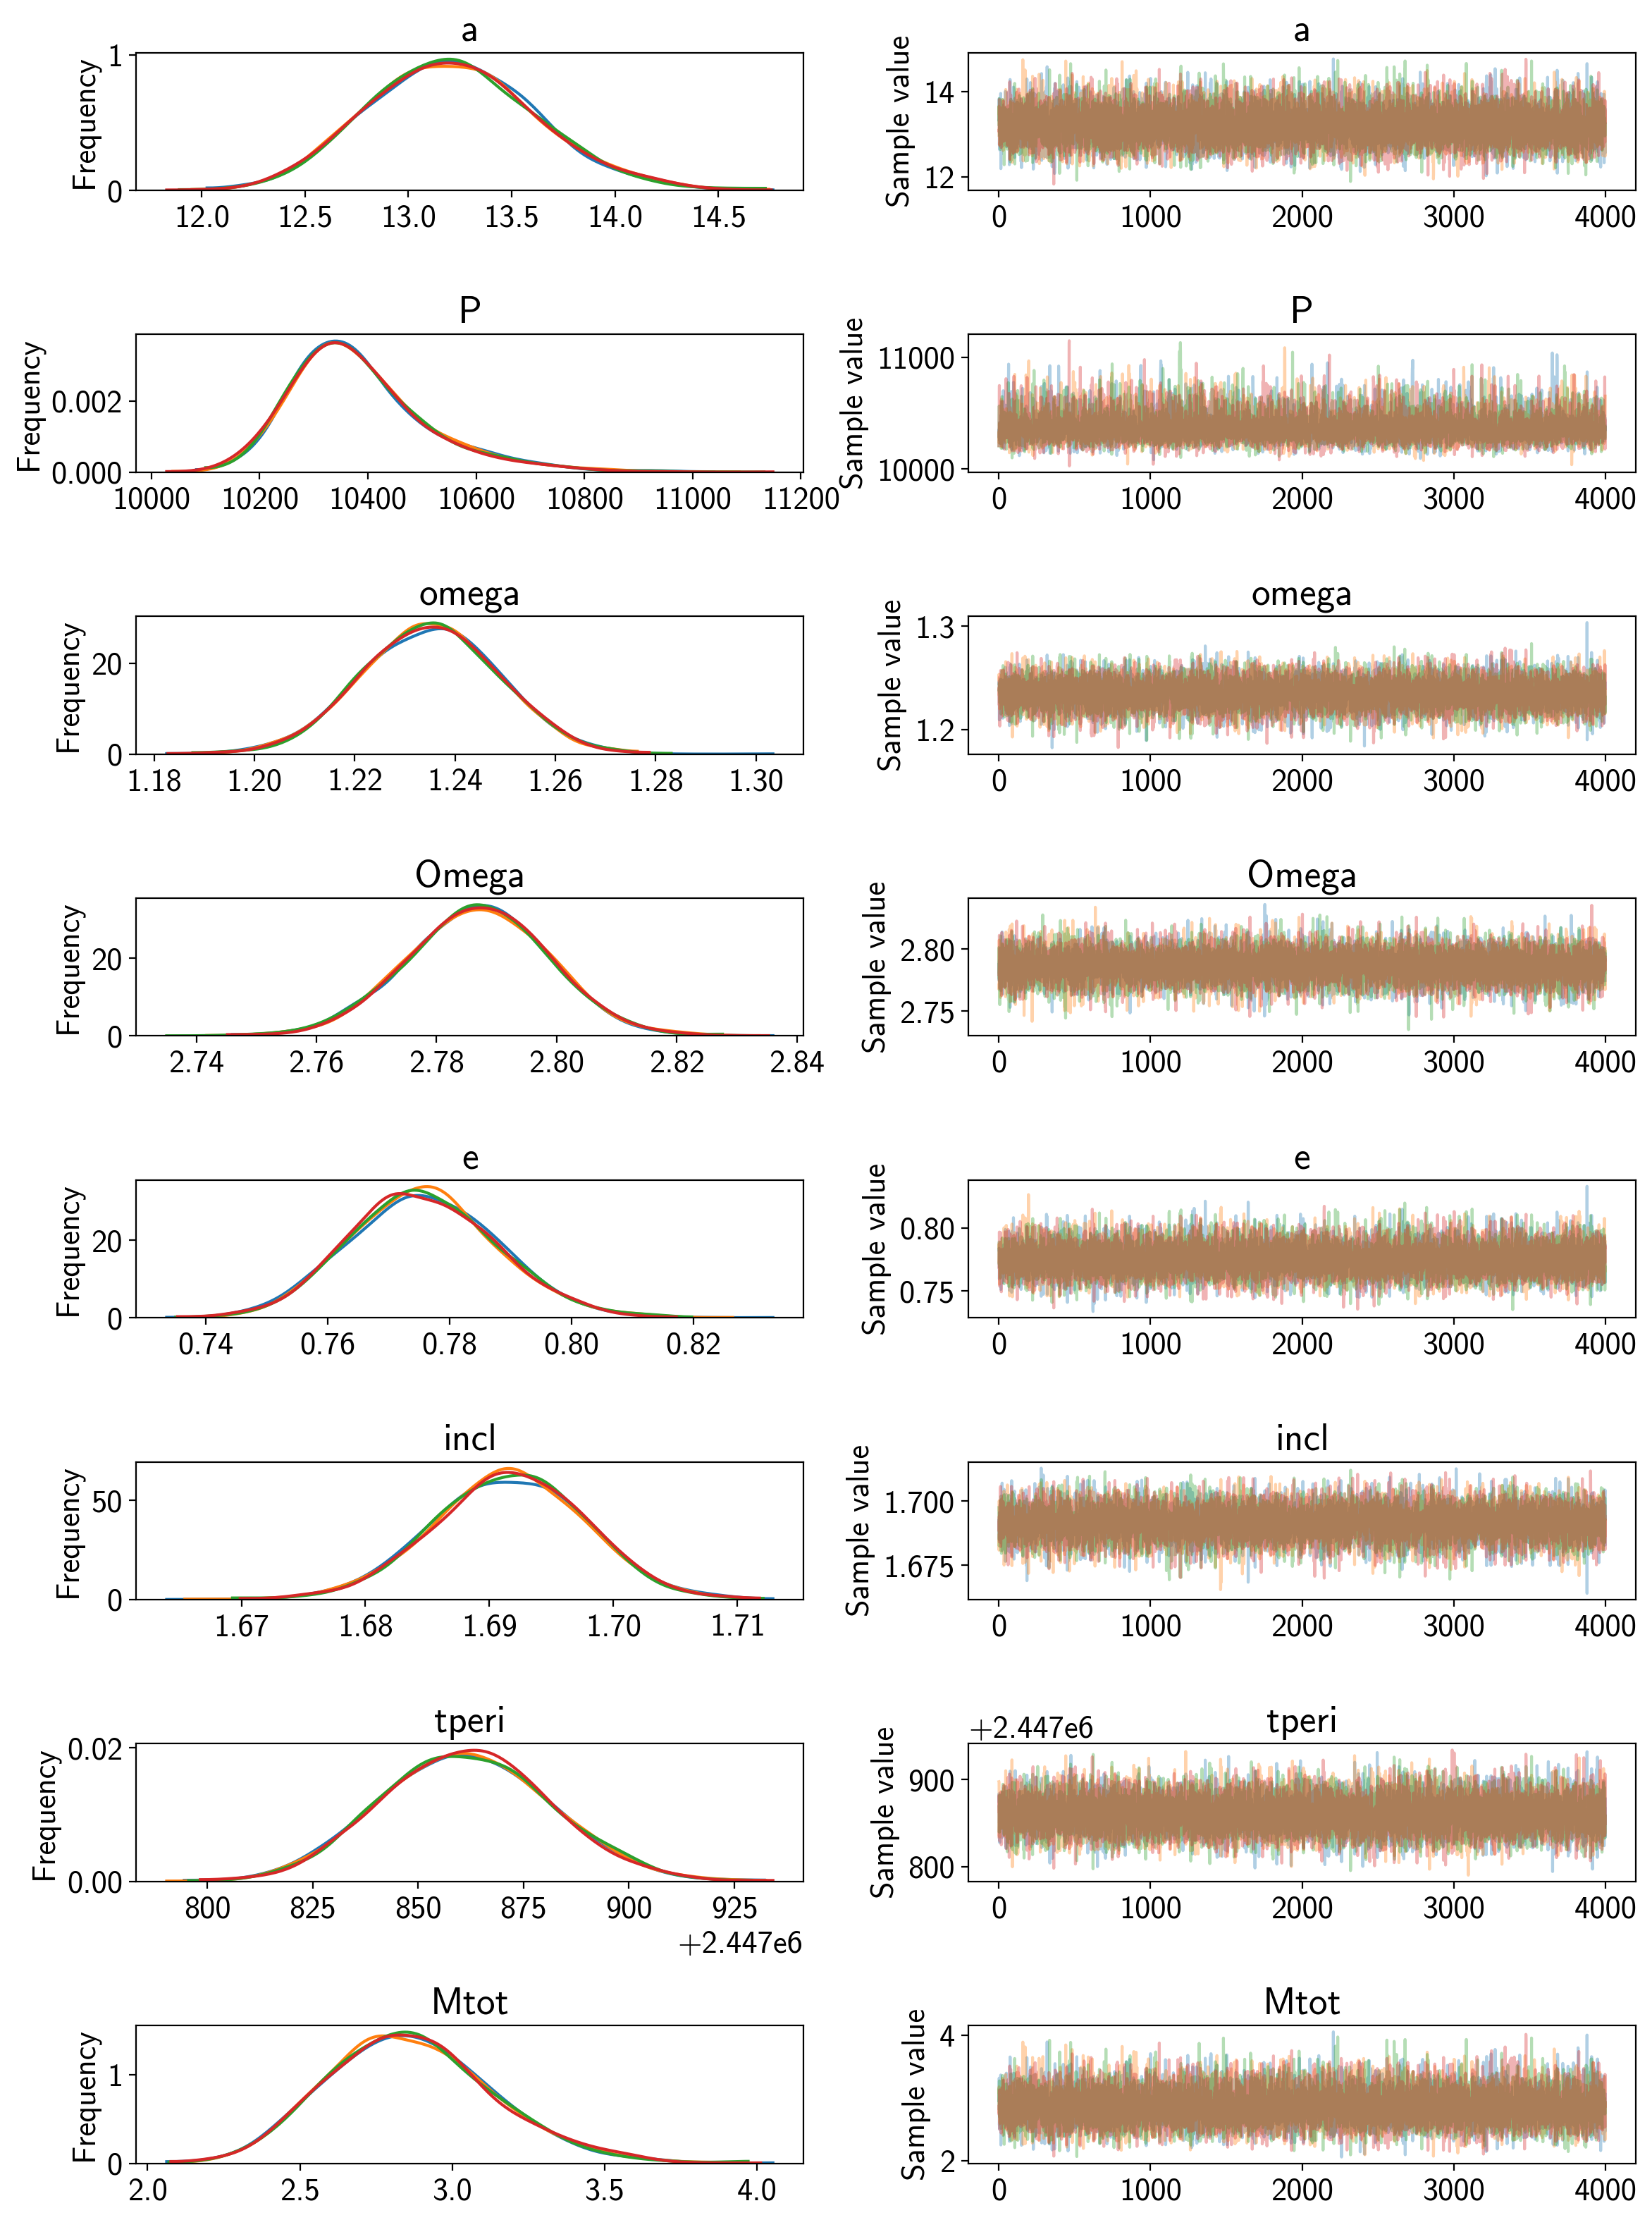

In [25]:
pm.traceplot(trace, varnames=["a", "P", "omega", "Omega", "e", "incl", "tperi", "Mtot"])

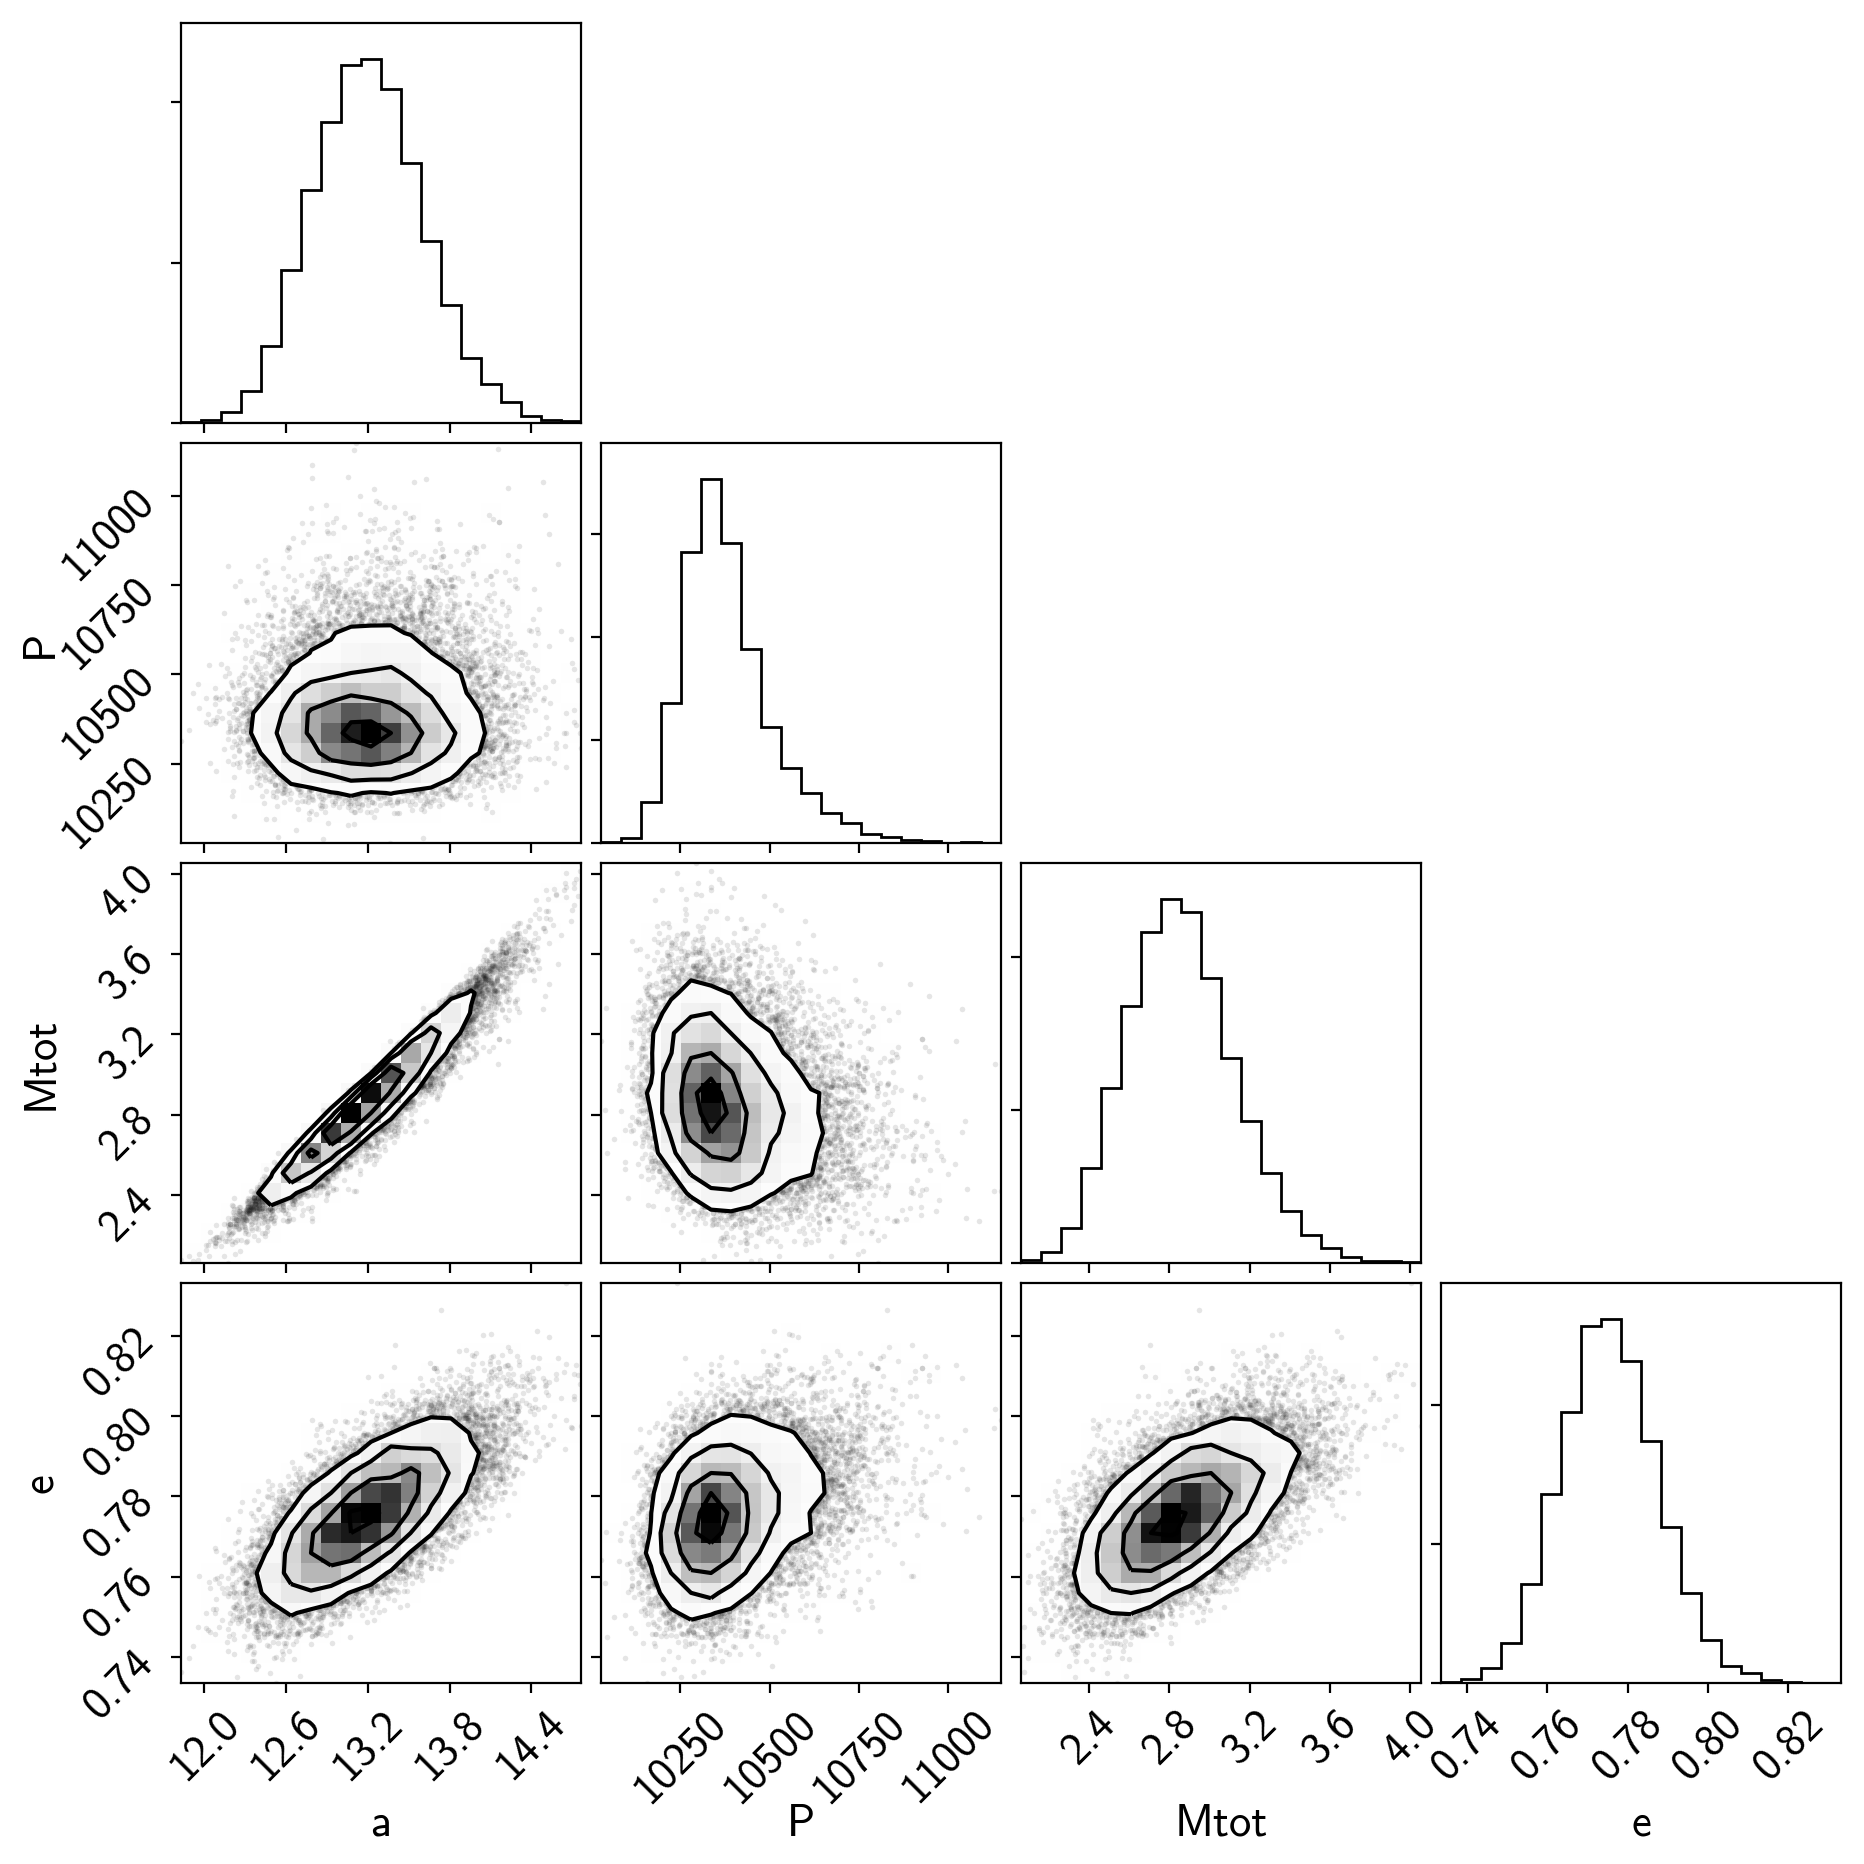

In [26]:
samples = pm.trace_to_dataframe(trace, varnames=["a", "P", "Mtot", "e"])
corner.corner(samples);